In [1]:
import os
os.chdir("/home/tangir/crmbm/python/pastis")

from IPython import get_ipython
get_ipython().magic("clear")

import matplotlib.pylab as plt
import matplotlib.dates as mdates
import mrs.reco as reco
import mrs.sim as sim
import mrs.log as log
import mrs.aliases as xxx
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import suspect
from datetime import datetime
import multiprocessing

plt.close("all")
plt.rcParams['figure.dpi'] = 75
plt.rcParams['figure.max_open_warning'] = 1000
plt.rcParams["figure.figsize"] = [8, 6]
# get_ipython().magic("matplotlib inline")
get_ipython().magic("matplotlib notebook")
log.setLevel(log.INFO)

cm = sns.color_palette("rocket", as_cmap=True)
#pd.set_option('display.max_rows', 50)
#pd.options.mode.chained_assignment = None  # default='warn'

(DEBUG) Loaded backend nbAgg version unknown.


# Load dataframes from files

In [2]:
df_sc_all_reco = pd.read_pickle("/home/tangir/crmbm/acq_db/sc_all_reco_notebook.pkl")
df_brain = pd.read_pickle("/home/tangir/crmbm/acq_db/brain_notebook.pkl")

In [3]:
df_sc_fit = pd.read_pickle("/home/tangir/crmbm/acq_db/sc_fit.pkl")
df_sc_fit["reco_template_name"] = "sc"

df_sc_nodatarej_fit = pd.read_pickle("/home/tangir/crmbm/acq_db/sc_nodatarej_fit.pkl")
df_sc_nodatarej_fit["reco_template_name"] = "sc_nodatarej"

df_sc_nodatarej_norea_fit = pd.read_pickle("/home/tangir/crmbm/acq_db/sc_nodatarej_norea_fit.pkl")
df_sc_nodatarej_norea_fit["reco_template_name"] = "sc_nodatarej_norea"

df_brain_fit = pd.read_pickle("/home/tangir/crmbm/acq_db/brain_fit.pkl")
df_brain_fit["reco_template_name"] = "brain"

# Join dataframes

In [4]:
df_sc_all_reco = df_sc_all_reco.reset_index()
df_brain = df_brain.reset_index()
#
df_sc_fit = pd.concat([df_sc_fit, df_sc_nodatarej_fit, df_sc_nodatarej_norea_fit])
df_sc_fit = df_sc_fit.reset_index()
#
df_brain_fit = df_brain_fit.reset_index()

In [5]:
df_sc_all_reco = pd.merge(df_sc_all_reco, df_sc_fit, left_on=["index", "reco_template_name"], right_on=["fit_ws_data_file_hash", "reco_template_name"], how="inner")
df_sc_all_reco = df_sc_all_reco.rename(columns = {'index': 'data_hash'})
df_sc_all_reco = df_sc_all_reco.set_index(["data_hash", "reco_template_name", "fit_ws_fit_hash"])

df_brain = pd.merge(df_brain, df_brain_fit, left_on=["index", "reco_template_name"], right_on=["fit_ws_data_file_hash", "reco_template_name"], how="inner")
df_brain = df_brain.rename(columns = {'index': 'data_hash'})
df_brain = df_brain.set_index(["data_hash", "reco_template_name", "fit_ws_fit_hash"])

# Recalculate metabolite parameters
## T2 correction

In [6]:
def recalculate_metabolite_concentrations(this_df):
    # fit
    # T2 correction
    this_df["fit_ws_params_fit_t2cor_obj"] = [o.correct_T2s(te) for o,te in zip(this_df["fit_ws_params_fit_obj"], this_df["reco_dataset_raw_data_sequence_te"])]
    this_df["fit_nows_params_fit_t2cor_obj"] = [o.correct_T2s(te) for o,te in zip(this_df["fit_nows_params_fit_obj"], this_df["reco_dataset_raw_data_sequence_te"])]

    return(this_df)

# multiproc run
#pool = multiprocessing.Pool()
#a = pool.map(recalculate_metabolite_concentrations, [df_brain, df_sc_all_reco])
df_brain = recalculate_metabolite_concentrations(df_brain)
df_sc_all_reco = recalculate_metabolite_concentrations(df_sc_all_reco)


## Breakdown params into columns

In [7]:
cols2breakdown_list = ["fit_ws_params_fit_obj",
                       "fit_ws_params_fit_t2cor_obj",
                       "fit_nows_params_fit_t2cor_obj"]

def breakdown_params_into_columns(this_df):

    # remove all params columns
    this_df = this_df.reset_index()
    cols2remove_list = this_df.columns[this_df.columns.str.contains("\|")].to_list()
    this_df = this_df.drop(cols2remove_list, axis=1)

    # for each column, break down, concat
    this_df_new_columns_list = []
    for c in cols2breakdown_list:
        c_prefix = c[:-3]
        print(c_prefix)

        # break down, keep only concentrations
        this_df_list = [o.to_dataframe(c_prefix).filter(regex="cm\|") if(type(o) is not float) else None for o in this_df[c]]

        this_df_new_columns = pd.concat(this_df_list)

        # add to list of new columns
        this_df_new_columns_list.append(this_df_new_columns.reset_index())

    this_df = pd.concat([this_df] + this_df_new_columns_list, axis=1)
    this_df = this_df.set_index(["data_hash", "reco_template_name", "fit_ws_fit_hash"])
    
    # clean-up: remove index and all params_obj columns
    this_df = this_df.drop("index", axis=1) # from previous reset_index
    this_df = this_df.rename(columns = {"fit_ws_params_fit_obj": "final_fit_params_arr"})
    cols2remove = this_df.columns[this_df.columns.str.contains("_params_") & this_df.columns.str.endswith("_obj")]
    this_df = this_df.drop(cols2remove, axis=1)

    return(this_df)

df_brain = breakdown_params_into_columns(df_brain)
df_sc_all_reco = breakdown_params_into_columns(df_sc_all_reco)


fit_ws_params_fit_
fit_ws_params_fit_t2cor_
fit_nows_params_fit_t2cor_
fit_ws_params_fit_
fit_ws_params_fit_t2cor_
fit_nows_params_fit_t2cor_


## Check for nulled concentrations

In [8]:
cm_threshold = 1e-3

def check_nulled_estimates(this_df):

    fit_ws_params_fit_columns_list = this_df.columns[this_df.columns.str.startswith("fit_ws_params_fit") & this_df.columns.str.endswith("|val")].tolist()

    for this_col in fit_ws_params_fit_columns_list:
        
        # find rows for which this col is zero or nan
        badval_rows = ((this_df[this_col] < cm_threshold) | (this_df[this_col] == np.nan))
        
        # set the err col to zero
        this_err_col = this_col.replace("|val", "|err")
        this_df.loc[badval_rows, this_err_col] = 0
        
        # set the val col to zero
        this_df.loc[badval_rows, this_col] = 0
        
    return(this_df)

df_brain = check_nulled_estimates(df_brain)
df_sc_all_reco = check_nulled_estimates(df_sc_all_reco)

## Combine some metabolite estimates

In [9]:
combined_metabolites_dict = {"tNAA": ["NAA", "NAAG"],
                             "tCr": ["Cr_CH3", "PCr"],
                             "tCho": ["GPC", "PC"],
                             "Glx": ["Glu", "Gln"]}  

def additional_columns(this_df):

    for this_param_type in cols2breakdown_list:
        print(this_param_type)
        for this_meta_parent, this_meta_children_list in combined_metabolites_dict.items():

            # init concentration
            this_meta_parent_key = this_param_type[:-3] + "cm|" + this_meta_parent + "|" + "val"
            this_df[this_meta_parent_key] = 0.0
            print(this_meta_parent_key)

            # summing up estimated concentrations
            for this_meta_child in this_meta_children_list:
                this_meta_child_key = this_param_type[:-3] + "cm|" + this_meta_child + "|" + "val"
                this_df[this_meta_parent_key] += this_df[this_meta_child_key]

            # init error
            this_meta_parent_key = this_param_type[:-3] + "cm|" + this_meta_parent + "|" + "err"
            this_df[this_meta_parent_key] = 0.0
            print(this_meta_parent_key)

            # summing up squared of errors
            for this_meta_child in this_meta_children_list:
                this_meta_child_key = this_param_type[:-3] + "cm|" + this_meta_child + "|" + "err"
                this_df[this_meta_parent_key] += this_df[this_meta_child_key]**2

            # sqrt the sum of squares
            this_df[this_meta_parent_key] = [np.sqrt(e) for e in this_df[this_meta_parent_key]]

    return(this_df)

df_brain = additional_columns(df_brain)
df_sc_all_reco = additional_columns(df_sc_all_reco)

fit_ws_params_fit_obj
fit_ws_params_fit_cm|tNAA|val
fit_ws_params_fit_cm|tNAA|err
fit_ws_params_fit_cm|tCr|val
fit_ws_params_fit_cm|tCr|err
fit_ws_params_fit_cm|tCho|val
fit_ws_params_fit_cm|tCho|err
fit_ws_params_fit_cm|Glx|val
fit_ws_params_fit_cm|Glx|err
fit_ws_params_fit_t2cor_obj
fit_ws_params_fit_t2cor_cm|tNAA|val
fit_ws_params_fit_t2cor_cm|tNAA|err
fit_ws_params_fit_t2cor_cm|tCr|val
fit_ws_params_fit_t2cor_cm|tCr|err
fit_ws_params_fit_t2cor_cm|tCho|val
fit_ws_params_fit_t2cor_cm|tCho|err
fit_ws_params_fit_t2cor_cm|Glx|val
fit_ws_params_fit_t2cor_cm|Glx|err
fit_nows_params_fit_t2cor_obj
fit_nows_params_fit_t2cor_cm|tNAA|val
fit_nows_params_fit_t2cor_cm|tNAA|err
fit_nows_params_fit_t2cor_cm|tCr|val
fit_nows_params_fit_t2cor_cm|tCr|err
fit_nows_params_fit_t2cor_cm|tCho|val
fit_nows_params_fit_t2cor_cm|tCho|err
fit_nows_params_fit_t2cor_cm|Glx|val
fit_nows_params_fit_t2cor_cm|Glx|err
fit_ws_params_fit_obj
fit_ws_params_fit_cm|tNAA|val
fit_ws_params_fit_cm|tNAA|err
fit_ws_params_fit_

## Replace nulled concentrations by NaN

In [10]:
def check_nulled_estimates(this_df):

    fit_ws_params_fit_columns_list = this_df.columns[this_df.columns.str.startswith("fit_ws_params_fit") & this_df.columns.str.endswith("|val")].tolist()

    for this_col in fit_ws_params_fit_columns_list:
        
        # find rows for which this col is zero or nan
        badval_rows = ((this_df[this_col] == 0) | (this_df[this_col] == np.nan))
        
        # set the err col to zero
        this_err_col = this_col.replace("|val", "|err")
        this_df.loc[badval_rows, this_err_col] = np.nan
        
        # set the val col to zero
        this_df.loc[badval_rows, this_col] = np.nan
        
    return(this_df)

df_brain = check_nulled_estimates(df_brain)
df_sc_all_reco = check_nulled_estimates(df_sc_all_reco)

## Calculate metabolite absolute and ratio concentrations

In [11]:
water_concentration = 55000.0

def recalculate_metabolite_abs_ratios(this_df):

    fit_ws_params_fit_t2cor_columns_list = this_df.columns[this_df.columns.str.startswith("fit_ws_params_fit_t2cor_cm") & this_df.columns.str.endswith("|val")].tolist()

    for this_col in fit_ws_params_fit_t2cor_columns_list:
        
        # calculate relative CRB errors in (%)
        this_err_col = this_col.replace("|val", "|err")
        this_err_prct_col = this_col.replace("|val", "|err_prct")
        this_df[this_err_prct_col] = this_df[this_err_col] / this_df[this_col] * 100.0

        # absolute concentrations rel. to water
        this_abs_val_col = this_col.replace("fit_ws_params_fit_t2cor_cm", "fit_ws_params_fit_t2cor_abs_cm")
        this_water_val_col = "fit_nows_params_fit_t2cor_cm|Water|val"
        this_df[this_abs_val_col] = this_df[this_col] * water_concentration / this_df[this_water_val_col]
        # and its error: propagating metabolite/water errors
        this_err_col = this_col.replace("|val", "|err")
        this_abs_err_col = this_col.replace("fit_ws_params_fit_t2cor_cm", "fit_ws_params_fit_t2cor_abs_cm").replace("|val", "|err")
        this_abs_err_prct_col = this_col.replace("fit_ws_params_fit_t2cor_cm", "fit_ws_params_fit_t2cor_abs_cm").replace("|val", "|err_prct")
        this_water_err_col = "fit_nows_params_fit_t2cor_cm|Water|err"
        this_df[this_abs_err_col] = [met_abs_cm * np.sqrt((met_err/met_cm)**2 + (water_err/water_cm)**2) for (met_abs_cm, met_cm, met_err, water_cm, water_err) in zip(this_df[this_abs_val_col], this_df[this_col], this_df[this_err_col], this_df[this_water_val_col], this_df[this_water_err_col])]   
        this_df[this_abs_err_prct_col] = this_df[this_abs_err_col] / this_df[this_abs_val_col] * 100.0
        
        # ratio concentrations rel. to tCr
        this_ratio_val_col = this_col.replace("fit_ws_params_fit_t2cor_cm", "fit_ws_params_fit_t2cor_ratio_cm")
        this_tcr_val_col = "fit_ws_params_fit_t2cor_cm|tCr|val"
        this_df[this_ratio_val_col] = this_df[this_col] / this_df[this_tcr_val_col]
        # and its error: propagating metabolite/tCr errors
        this_err_col = this_col.replace("|val", "|err")
        this_ratio_err_col = this_col.replace("fit_ws_params_fit_t2cor_cm", "fit_ws_params_fit_t2cor_ratio_cm").replace("|val", "|err")
        this_ratio_err_prct_col = this_col.replace("fit_ws_params_fit_t2cor_cm", "fit_ws_params_fit_t2cor_ratio_cm").replace("|val", "|err_prct")
        this_tcr_err_col = "fit_ws_params_fit_t2cor_cm|tCr|err"
        this_df[this_ratio_err_col] = [met_ratio_cm * np.sqrt((met_err/met_cm)**2 + (tcr_err/tcr_cm)**2) for (met_ratio_cm, met_cm, met_err, tcr_cm, tcr_err) in zip(this_df[this_ratio_val_col], this_df[this_col], this_df[this_err_col], this_df[this_tcr_val_col], this_df[this_tcr_err_col])]   
        this_df[this_ratio_err_prct_col] = this_df[this_ratio_err_col] / this_df[this_ratio_val_col] * 100.0

    return(this_df)

df_brain = recalculate_metabolite_abs_ratios(df_brain)
df_sc_all_reco = recalculate_metabolite_abs_ratios(df_sc_all_reco)

# Correlation matrix analysis
In case I missed something interesting!

In [12]:
def list_highest_corr(this_df_corr, column_name):

    this_df_corr2 = this_df_corr[column_name]
    this_df_corr2 = this_df_corr2.loc[this_df_corr2.abs() < (1.00 - 1e-6)]
    this_df_corr2 = this_df_corr2.loc[this_df_corr2.abs() > 0.5]
    this_df_corr2 = this_df_corr2.iloc[(-this_df_corr2.abs()).argsort()]
    return(this_df_corr2)

df = df_sc_all_reco
# correlate only numeric fields
df_num = df.select_dtypes(include=np.number)   
df_corr = df_num.corr(min_periods=5)
pd.set_option('display.max_rows', 500)


In [13]:
this_df_corr = list_highest_corr(df_corr, "snr_final")
this_df_corr

reco_dataset_raw_analysis_results_data rejecting_snr            0.956610
reco_dataset_raw_analysis_results_frequency shifting_snr        0.953072
reco_dataset_raw_analysis_results_averaging_snr                 0.948330
reco_dataset_raw_analysis_results_frequency realigning_snr      0.946622
reco_dataset_raw_analysis_results_zero-filling_snr              0.937600
reco_dataset_raw_analysis_results_channel-combining_snr         0.933334
reco_dataset_raw_analysis_results_estimating noise level_snr    0.933334
reco_dataset_raw_analysis_results_phasing_snr                   0.931400
reco_dataset_raw_analysis_results_scaling intensity_snr         0.931400
reco_dataset_dcm_analysis_results_frequency shifting_snr        0.924236
reco_dataset_dcm_analysis_results_frequency realigning_snr      0.901766
reco_dataset_dcm_analysis_results_zero-filling_snr              0.900112
reco_dataset_dcm_analysis_results_averaging_snr                 0.900112
reco_dataset_dcm_analysis_results_scaling intensity

* The SNR is correlated with:
    * water signal intensity
    * phase, amplitude std (negative)

In [14]:
this_df_corr = list_highest_corr(df_corr, "patient_bmi")
this_df_corr

patient_weight                                       0.880361
fit_ws_data_weight                                   0.880361
reco_dataset_dcm_data_weight                         0.880361
fit_nows_data_weight                                 0.880361
reco_dataset_dcm_data_sequence_f0                    0.709327
voxel_pos_y_mm                                      -0.702260
patient_height                                       0.674617
fit_ws_data_height                                   0.674617
reco_dataset_dcm_data_height                         0.674617
fit_nows_data_height                                 0.674617
reco_dataset_raw_data_sequence_tr                    0.658218
reco_dataset_dcm_data_sequence_tr                    0.658218
fit_ws_data_sequence_tr                              0.658218
csde_y                                               0.652347
csde_z                                               0.652347
reco_dataset_dcm_data_sequence_vref                  0.637977
reco_dat

* BMI is correlated with:
    * patient weight/height etc.
    * f0 frequency !
    * voxel Y position
    * sequence TR
    * CSDEs
    * SNR (negative)
    * sequence Vref
    * sequence pulse duration
    * shim n*4 (ZX)

In [15]:
this_df_corr = list_highest_corr(df_corr, "lw_final")
this_df_corr

reco_dataset_raw_analysis_results_frequency shifting_lw        0.954922
reco_dataset_raw_analysis_results_data rejecting_lw            0.954204
reco_dataset_raw_analysis_results_averaging_lw                 0.951756
reco_dataset_raw_analysis_results_frequency realigning_lw      0.929332
prerejection_linewidth_mean                                    0.877923
prerejection_linewidth_std                                     0.778376
reco_dataset_raw_analysis_results_phasing_lw                   0.632797
reco_dataset_raw_analysis_results_scaling intensity_lw         0.632797
reco_dataset_raw_analysis_results_channel-combining_lw         0.631369
reco_dataset_raw_analysis_results_estimating noise level_lw    0.631369
reco_dataset_raw_analysis_results_zero-filling_lw              0.631369
reco_dataset_dcm_analysis_results_averaging_lw                 0.623300
reco_dataset_dcm_analysis_results_zero-filling_lw              0.623300
reco_dataset_dcm_analysis_results_channel-combining_lw         0

* Linewidth is correlated with:
    * some small metabolites error
    * metabolites damping factors
    * prejection linewidth std

In [16]:
this_df_corr = list_highest_corr(df_corr, "reco_dataset_raw_data_sequence_vref")
this_df_corr

reco_dataset_raw_data_sequence_tr                    0.963054
reco_dataset_dcm_data_sequence_tr                    0.963054
fit_ws_data_sequence_tr                              0.963054
fit_nows_data_sequence_pulse_exc_duration            0.955548
reco_dataset_raw_data_sequence_pulse_exc_duration    0.955548
fit_ws_data_sequence_pulse_exc_duration              0.955548
reco_dataset_dcm_data_sequence_pulse_exc_duration    0.955548
csde_y                                               0.930190
csde_z                                               0.930190
fit_nows_data_sequence_tr                            0.852669
voxel_pos_y_mm                                      -0.765449
fit_nows_data_weight                                 0.760424
fit_ws_data_weight                                   0.760424
patient_weight                                       0.760424
reco_dataset_dcm_data_weight                         0.760424
fit_ws_data_height                                   0.724624
reco_dat

* Vref is correlated with:
    * sequence TR
    * sequence pulse duration
    * CSDEs
    * voxel Y position (negative)
    * patient BMI/weight/height etc.
    * acquisition duration
    * shims (sum) (negative)
    * shims (2nd order) (negative)

In [17]:
this_df_corr = list_highest_corr(df_corr, "reco_dataset_raw_data_sequence_te")
this_df_corr

fit_nows_data_sequence_te                            0.875267
reco_dataset_raw_data_sequence_pulse_rfc_duration    0.869845
fit_nows_data_sequence_pulse_rfc_duration            0.869845
reco_dataset_dcm_data_sequence_pulse_rfc_duration    0.869845
fit_ws_data_sequence_pulse_rfc_duration              0.869845
reco_dataset_dcm_data_sequence_na                    0.772897
reco_dataset_dcm_data_sequence_fs                    0.766596
reco_dataset_raw_data_sequence_pulse_rfc_r           0.674346
reco_dataset_dcm_data_sequence_pulse_rfc_r           0.674346
fit_nows_data_sequence_pulse_rfc_r                   0.674346
fit_ws_data_sequence_pulse_rfc_r                     0.674346
fit_nows_optim_results_fqn                           0.644832
fit_ws_data_sequence_pulse_rfc_n                    -0.627528
fit_nows_data_sequence_pulse_rfc_n                  -0.627528
reco_dataset_dcm_data_sequence_pulse_rfc_n          -0.627528
reco_dataset_raw_data_sequence_pulse_rfc_n          -0.627528
fit_ws_o

* TE is correlated with:
    * sequence pulse duration
    * sequence pulse R
    * sequence pulse N (negative)

In [18]:
this_df_corr = list_highest_corr(df_corr, "fit_ws_params_fit_cm|NAA_CH3|err")
this_df_corr

Series([], Name: fit_ws_params_fit_cm|NAA_CH3|err, dtype: float64)

* CRB(NAA) is correlated with:
    * other metabolites' CRBs
    * no acquisition parameters

In [19]:
pd.set_option('display.max_rows', 50)

# Free some memory

In [20]:
except_list = ["df_sc_all_reco", "df_brain"]

for var_name in dir():
    if(eval("type(" + var_name + ")") == pd.DataFrame and var_name not in except_list):
        del globals()[var_name]


# Additional columns

In [21]:
def additional_columns(this_df):
    this_df["fit_ws_metabolites_len"] = [len(mbl) if (type(mbl) is not float) else 1 for mbl in this_df["fit_ws_metabolites"]]
    this_df["fit_ws_sequence_str"] = ["press" if("press" in s) else "none" for s in this_df["fit_ws_sequence"].astype(str)]
    this_df["fit_tool_name"] = ["pastis" if("pastis" in s) else "lcmodel" for s in this_df["fit_ws_name"]]
    
    this_df["strategy"] = this_df.index.get_level_values("reco_template_name").astype(str) + "|" + \
                this_df["fit_tool_name"].astype(str) + "|" + \
                this_df["fit_ws_metabolites_len"].astype(str) + "|" + \
                this_df["fit_ws_sequence_str"].astype(str)
    
    return(this_df)

df_brain = additional_columns(df_brain)
df_sc_all_reco = additional_columns(df_sc_all_reco)

# Convert to a long dataframe
in order to be able to do seaborn plots easily

In [22]:
def convert_to_long(this_df):
    
    this_df = this_df.reset_index()
    
    # find all columns not related to params
    id_vars_list = this_df.columns[~this_df.columns.str.contains("\|")]

    # melt all those param columns
    this_df = this_df.melt(id_vars=id_vars_list, var_name="melted_params_name", value_name="param_val")         

    # split columns into metabolite, parameter name, err, etc.
    melted_params_name_col = this_df["melted_params_name"]
    this_df["param_p_type"] = melted_params_name_col.str.split("|").str[0]
    this_df["param_m_name"] = melted_params_name_col.str.split("|").str[1]
    this_df["param_val_err"] = melted_params_name_col.str.split("|").str[2]
    this_df = this_df.drop("melted_params_name", axis=1)
    
    this_df = this_df.set_index(["data_hash", "reco_template_name", "fit_ws_fit_hash"])

    return(this_df)

df_brain = convert_to_long(df_brain)
df_sc_all_reco = convert_to_long(df_sc_all_reco)


# Optimal fit strategy

* Which sequence for simulation?
* How many metabolites?

## Brain data

### Fit strategies vs R2/FQN

<IPython.core.display.Javascript object>


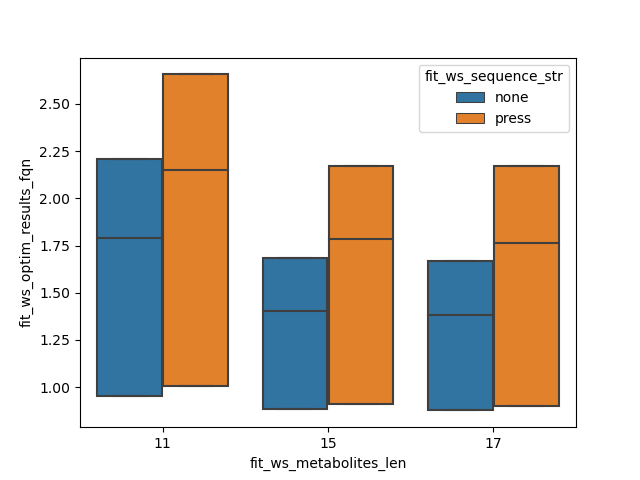

In [23]:
df = df_brain.loc[(df_brain.index.get_level_values("reco_template_name") == "brain") &
                  (df_brain["fit_tool_name"] == "pastis")]

plt.figure()
g = sns.boxplot(x="fit_ws_metabolites_len",  
                y="fit_ws_optim_results_fqn",
                hue="fit_ws_sequence_str",
                data=df)

<IPython.core.display.Javascript object>


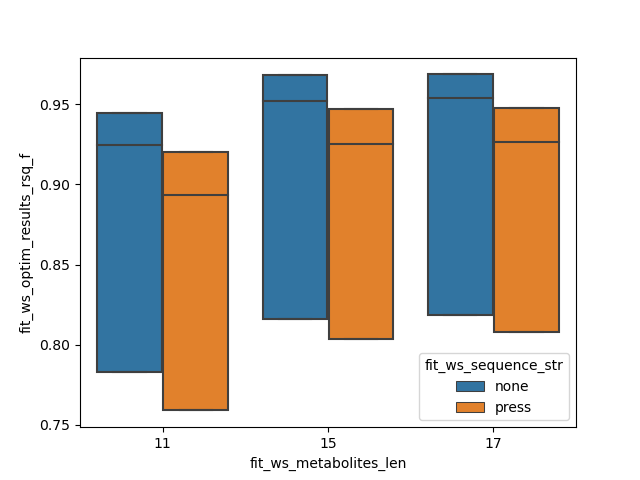

<IPython.core.display.Javascript object>


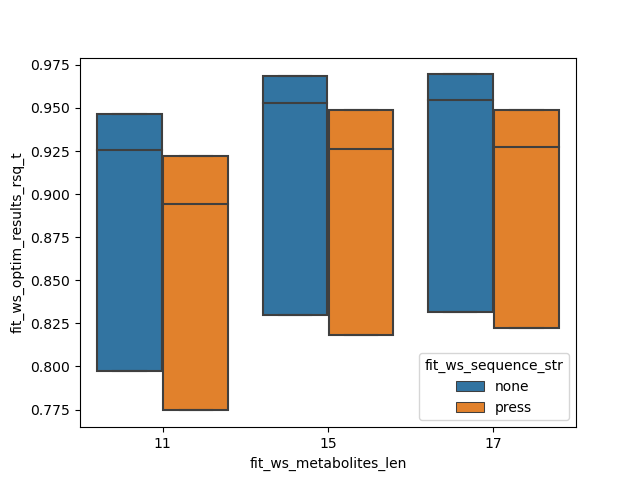

In [24]:
plt.figure()
g = sns.boxplot(x="fit_ws_metabolites_len", 
                y="fit_ws_optim_results_rsq_f",
                hue="fit_ws_sequence_str",
                data=df)

plt.figure()
g = sns.boxplot(x="fit_ws_metabolites_len", 
                y="fit_ws_optim_results_rsq_t",
                hue="fit_ws_sequence_str",
                data=df)


* Evidemment, the more we include metabolites in the fit basis set, the better is the fit in terms of FQN, R2, etc...
* sLASER ("none") should be use for the signal simulation/fit

### Fit strategies vs CRBs

<IPython.core.display.Javascript object>


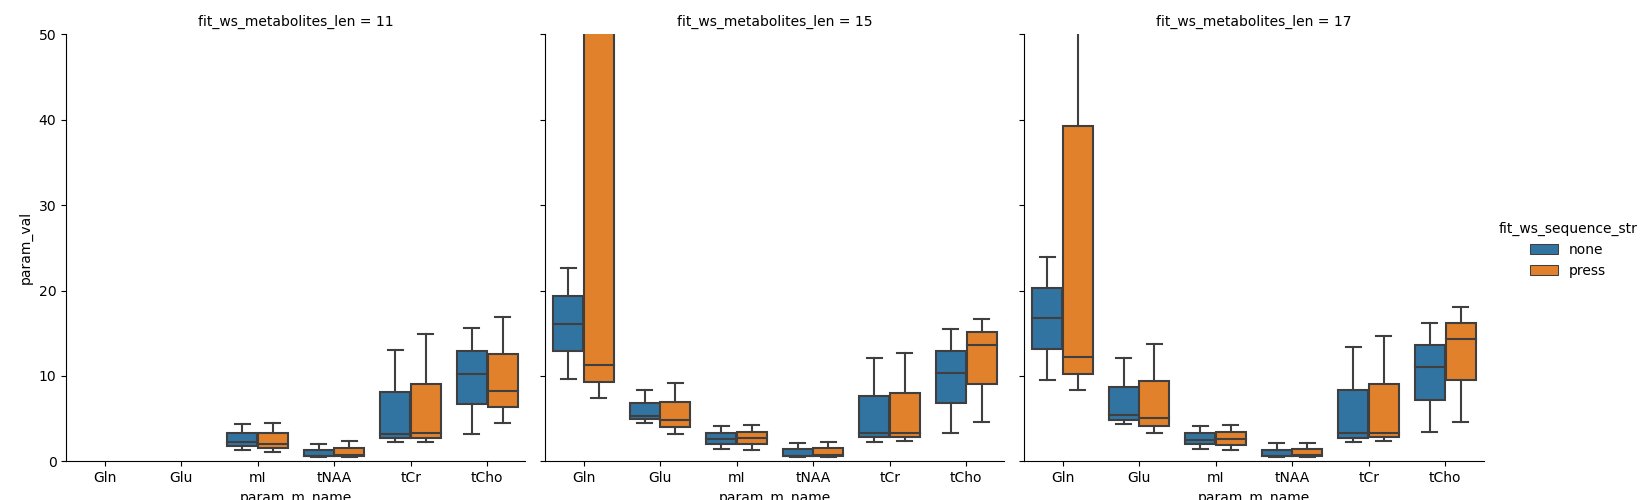

(0.0, 50.0)

In [25]:
df = df_brain.loc[(df_brain.index.get_level_values("reco_template_name") == "brain")]

# watch CRBs
this_df = df.loc[(df["fit_tool_name"] == "pastis") &
                 (df["param_p_type"] == "fit_ws_params_fit_t2cor_cm") &
                 (df["param_val_err"] == "err_prct") &  
                 (df["param_m_name"].isin(["tCr", "tCho", "tNAA", "Glu", "Gln", "mI"]))]

g = sns.catplot(x="param_m_name", 
                y="param_val",
                hue="fit_ws_sequence_str", col="fit_ws_metabolites_len", kind="box",
                data=this_df)

plt.ylim([0, 50])

sLASER or PRESS gives really similar CRBs...

<IPython.core.display.Javascript object>


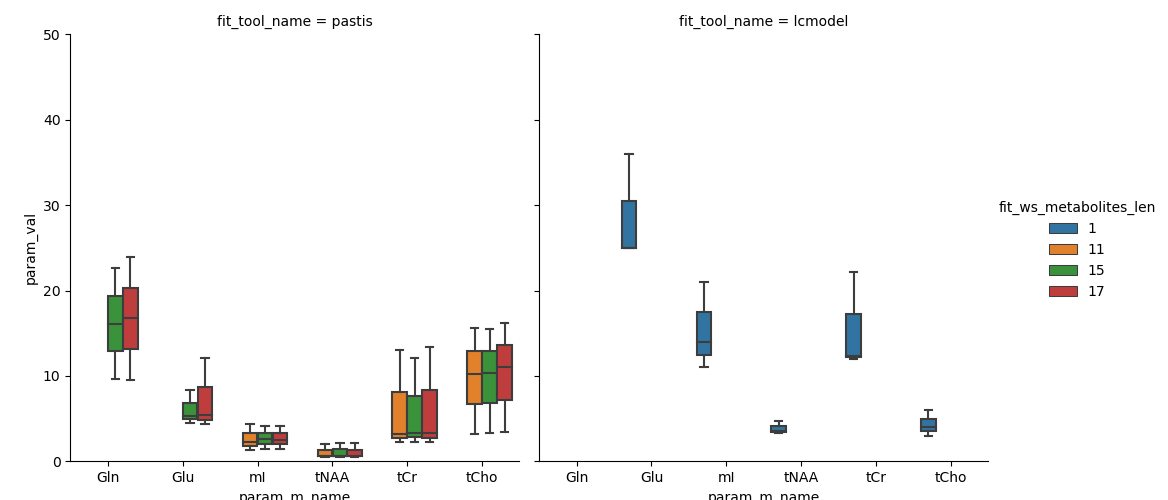

(0.0, 50.0)

In [26]:
# keep only pastis/sLASER and lcmodel
df = df_brain.loc[(df_brain.index.get_level_values("reco_template_name") == "brain") &
                        (df_brain["fit_ws_sequence_str"] == "none")]

# watch CRBs
this_df = df.loc[(df["param_p_type"] == "fit_ws_params_fit_t2cor_cm") &
                 (df["param_val_err"] == "err_prct") &  
                 (df["param_m_name"].isin(["tCr", "tCho", "tNAA", "Glu", "Gln", "mI"]))]

g = sns.catplot(x="param_m_name", 
                y="param_val",
                hue="fit_ws_metabolites_len", col="fit_tool_name", kind="box",
                data=this_df)

plt.ylim([0, 50])

* LCModel gives higher CRBs in average than PASTIS!
* The number of metabolites is not really affecting the CRBs of the main metabolites (in the brain here) 

### Fit strategies vs Metabolite ratios

<IPython.core.display.Javascript object>


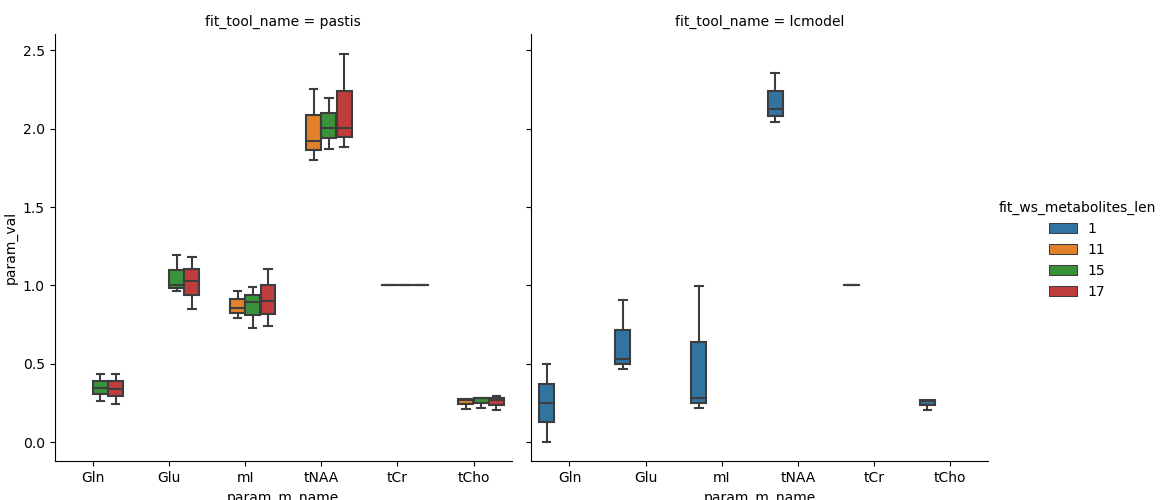

In [27]:
# keep only pastis/sLASER and lcmodel
df = df_brain.loc[(df_brain.index.get_level_values("reco_template_name") == "brain") &
                        (df_brain["fit_ws_sequence_str"] == "none")]

# watch CRBs
this_df = df.loc[(df["param_p_type"] == "fit_ws_params_fit_t2cor_ratio_cm") &
                 (df["param_val_err"] == "val") &  
                 (df["param_m_name"].isin(["tCr", "tCho", "tNAA", "Glu", "Gln", "mI"]))]

g = sns.catplot(x="param_m_name", 
                y="param_val",
                hue="fit_ws_metabolites_len", col="fit_tool_name", kind="box",
                data=this_df)


* On brain data, LCModel shows higher variability for some metabolite ratios :)
* Regarding number of metabolites to fit, hard to conclude. Better look at the CRBs?

## Spinal cord data

### Fit strategies vs R2/FQN

<IPython.core.display.Javascript object>


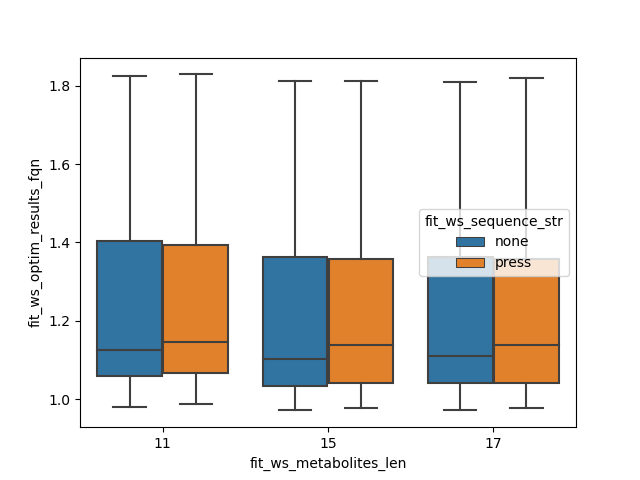

In [28]:
df = df_sc_all_reco.loc[(df_sc_all_reco.index.get_level_values("reco_template_name") == "sc") &
                        (df_sc_all_reco["fit_tool_name"] == "pastis")]

plt.figure()
g = sns.boxplot(x="fit_ws_metabolites_len",  
                y="fit_ws_optim_results_fqn",
                hue="fit_ws_sequence_str",
                data=df)

<IPython.core.display.Javascript object>


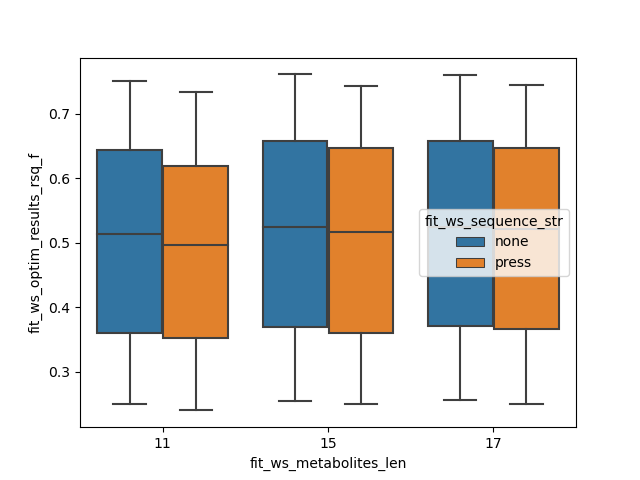

<IPython.core.display.Javascript object>


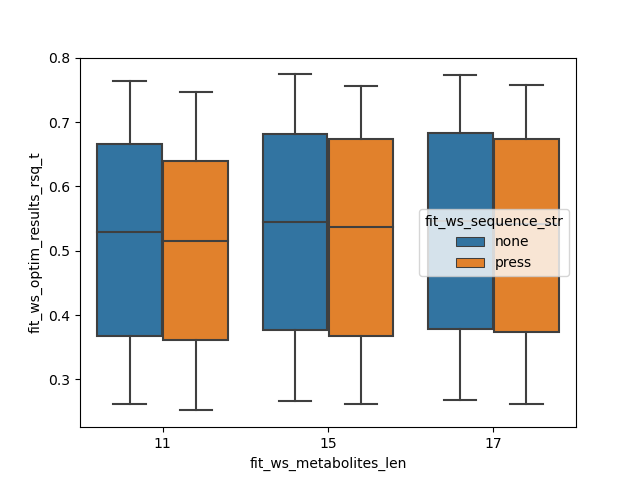

In [29]:
plt.figure()
g = sns.boxplot(x="fit_ws_metabolites_len", 
                y="fit_ws_optim_results_rsq_f",
                hue="fit_ws_sequence_str",
                data=df)

plt.figure()
g = sns.boxplot(x="fit_ws_metabolites_len", 
                y="fit_ws_optim_results_rsq_t",
                hue="fit_ws_sequence_str",
                data=df)

* Evidemment, the more we include metabolites in the fit basis set, the better is the fit in terms of FQN, R2, etc...
* sLASER ("none") should be use for the signal simulation/fit

### Fit strategies vs CRBs

<IPython.core.display.Javascript object>


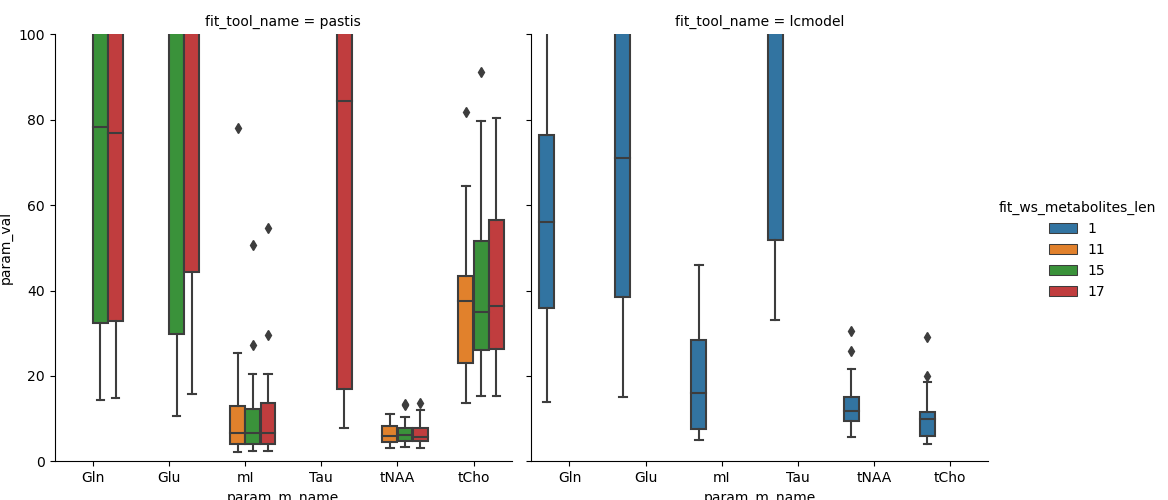

(0.0, 100.0)

In [30]:
# keep only pastis/sLASER and lcmodel
df = df_sc_all_reco.loc[(df_sc_all_reco.index.get_level_values("reco_template_name") == "sc") &
                        (df_sc_all_reco["fit_ws_sequence_str"] == "none")]

# watch CRBs
this_df = df.loc[(df["param_p_type"] == "fit_ws_params_fit_t2cor_cm") &
                 (df["param_val_err"] == "err_prct") &  
                 (df["param_m_name"].isin(["Tau", "tCho", "tNAA", "Glu", "Gln", "mI"]))]

g = sns.catplot(x="param_m_name", 
                y="param_val",
                hue="fit_ws_metabolites_len", col="fit_tool_name", kind="box",
                data=this_df)

plt.ylim([0, 100])

* Yes, just like on brain data, LCModel gives higher CRBs than PASTIS!
* Seems that n=21 metabolites could be a bit too much and is affecting the CRBs of tCho and Gln?

### Fit strategies vs Metabolite ratios

<IPython.core.display.Javascript object>


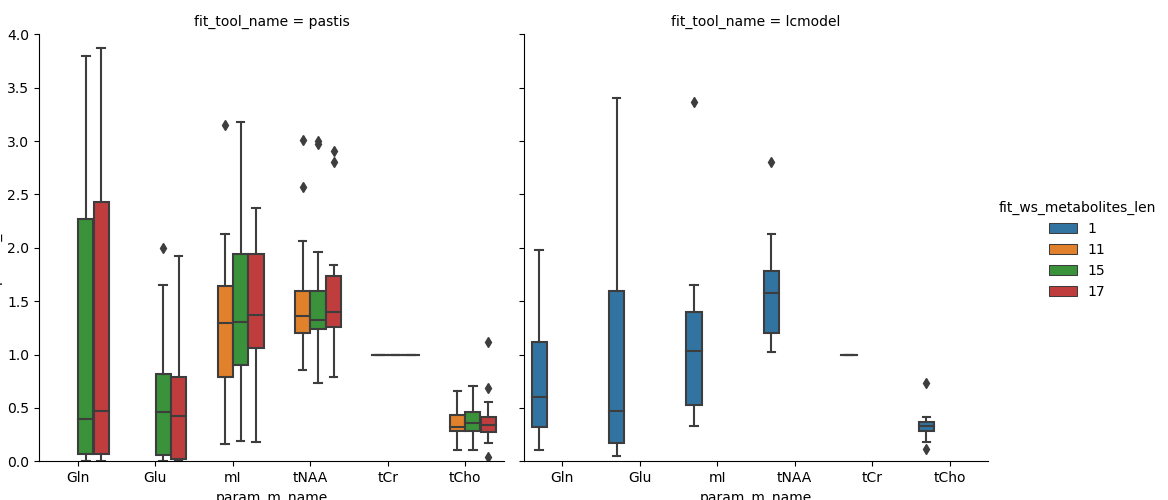

(0.0, 4.0)

In [31]:
# keep only pastis/sLASER and lcmodel
df = df_sc_all_reco.loc[(df_sc_all_reco.index.get_level_values("reco_template_name") == "sc") &
                        (df_sc_all_reco["fit_ws_sequence_str"] == "none")]

# watch CRBs
this_df = df.loc[(df["param_p_type"] == "fit_ws_params_fit_t2cor_ratio_cm") &
                 (df["param_val_err"] == "val") &  
                 (df["param_m_name"].isin(["tCr", "tCho", "tNAA", "Glu", "Gln", "mI"]))]

g = sns.catplot(x="param_m_name", 
                y="param_val",
                hue="fit_ws_metabolites_len", col="fit_tool_name", kind="box",
                data=this_df)

plt.ylim([0, 4])

* We have clearly different results with PASTIS and LCM... 
* Variability is stronger for some metabolites with LCM

# Data quality (SNR & LW)
## Annotated SNR vs. LW

In [32]:
def add_labels(key_x, key_y, key_label, this_df_labels, ax, font_size=10, x_offset=0.0, y_offset=0.0):
    for i, pt in this_df_labels.iterrows():
        ax.text(pt[key_x] + .02 + x_offset, pt[key_y] + y_offset, str(pt[key_label]), fontsize=font_size)

<IPython.core.display.Javascript object>


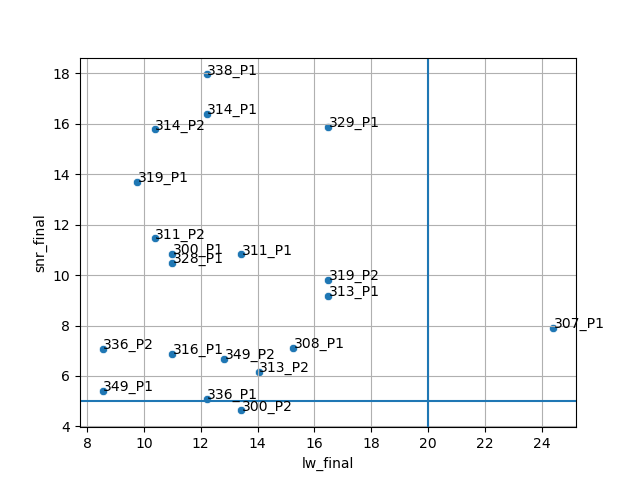

In [33]:
threshold_snr_test = 5
threshold_lw_test = 20

df = df_sc_all_reco.loc[(df_sc_all_reco.index.get_level_values("reco_template_name") == "sc") &
                        (df_sc_all_reco["fit_tool_name"] == "pastis") &
                        (df_sc_all_reco["fit_ws_metabolites_len"] == 15) &
                        (df_sc_all_reco["fit_ws_sequence_str"] == "none")]

this_df = df.drop_duplicates("patient_pass_id")

plt.figure()
g = sns.scatterplot(x="lw_final", y="snr_final", data=this_df)
add_labels("lw_final", "snr_final", "patient_pass_id", this_df, plt.gca())
plt.axvline(threshold_lw_test)
plt.axhline(threshold_snr_test)
plt.grid('on')

## Annotated R2 & FQN

<IPython.core.display.Javascript object>


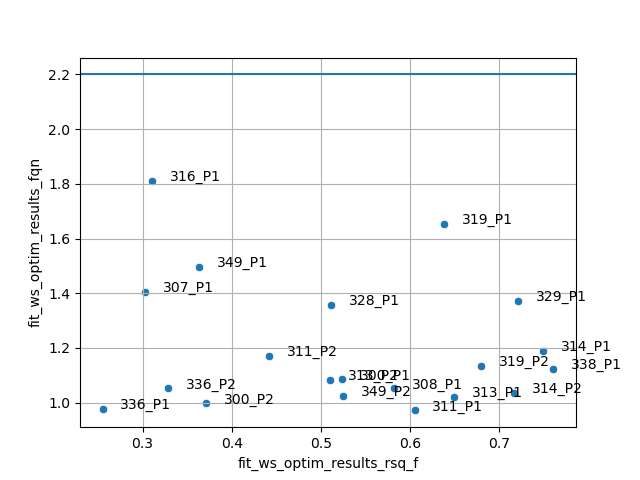

In [34]:
threshold_fqn_test = 2.2

df = df_sc_all_reco.loc[(df_sc_all_reco.index.get_level_values("reco_template_name") == "sc") &
                        (df_sc_all_reco["fit_tool_name"] == "pastis") &
                        (df_sc_all_reco["fit_ws_metabolites_len"] == 15) &
                        (df_sc_all_reco["fit_ws_sequence_str"] == "none")]

this_df = df.drop_duplicates("patient_pass_id")

plt.figure()
g = sns.scatterplot(x="fit_ws_optim_results_rsq_f", y="fit_ws_optim_results_fqn", data=this_df)
add_labels("fit_ws_optim_results_rsq_f", "fit_ws_optim_results_fqn", "patient_pass_id", this_df, plt.gca())
plt.axhline(threshold_fqn_test)
plt.grid('on')


## CRBs vs. SNR & LW

<IPython.core.display.Javascript object>


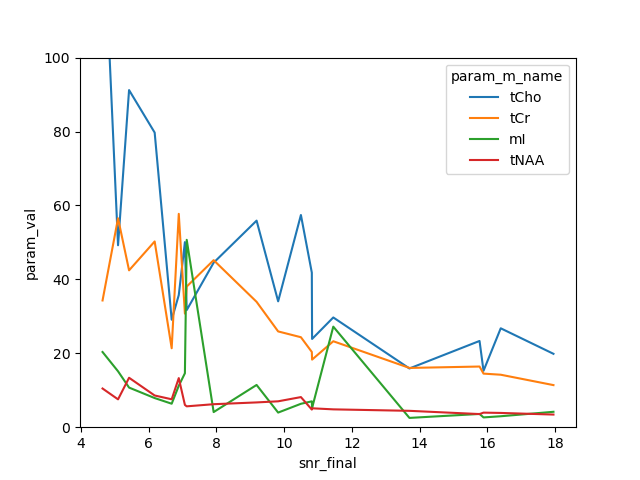

(0.0, 100.0)

In [35]:
df = df_sc_all_reco.loc[(df_sc_all_reco.index.get_level_values("reco_template_name") == "sc") &
                        (df_sc_all_reco["fit_tool_name"] == "pastis") &
                        (df_sc_all_reco["fit_ws_metabolites_len"] == 15) &
                        (df_sc_all_reco["fit_ws_sequence_str"] == "none")]

# watch CRBs
this_df = df.loc[(df["param_p_type"] == "fit_ws_params_fit_t2cor_cm") &
                 (df["param_val_err"] == "err_prct") &  
                 (df["param_m_name"].isin(["tCr", "tCho", "tNAA", "mI"]))]

# sort by SNR
this_df = this_df.sort_values("snr_final")

plt.figure()
g = sns.lineplot(x="snr_final", y="param_val", hue="param_m_name", data=this_df)

plt.ylim([0, 100])

## Metabolite ratios vs. SNR & LW

<IPython.core.display.Javascript object>


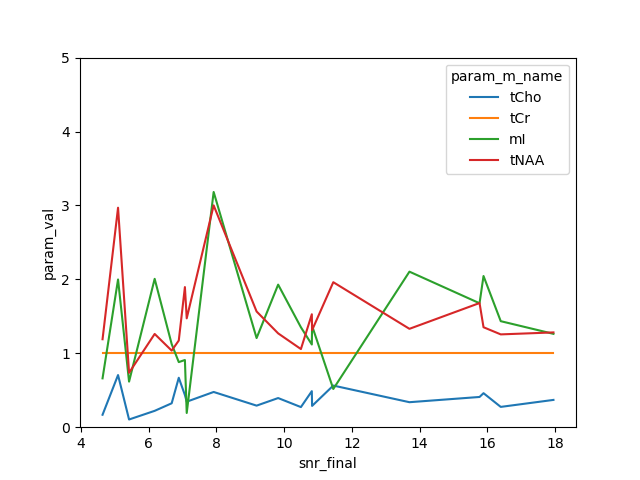

(0.0, 5.0)

In [36]:
df = df_sc_all_reco.loc[(df_sc_all_reco.index.get_level_values("reco_template_name") == "sc") &
                        (df_sc_all_reco["fit_tool_name"] == "pastis") &
                        (df_sc_all_reco["fit_ws_metabolites_len"] == 15) &
                        (df_sc_all_reco["fit_ws_sequence_str"] == "none")]

# watch ratios
this_df = df.loc[(df["param_p_type"] == "fit_ws_params_fit_t2cor_ratio_cm") &
                 (df["param_val_err"] == "val") &  
                 (df["param_m_name"].isin(["tCr", "tCho", "tNAA", "mI"]))]

# sort by SNR
this_df = this_df.sort_values("snr_final")

plt.figure()
g = sns.lineplot(x="snr_final", y="param_val", hue="param_m_name", data=this_df)

plt.ylim([0, 5])

Well yeah, we do have crazy metabolite concentration ratios when SNR is low but it gets better for higher SNR. Makes sense.

# Quantification results
## Annotated metabolite ratios

<IPython.core.display.Javascript object>


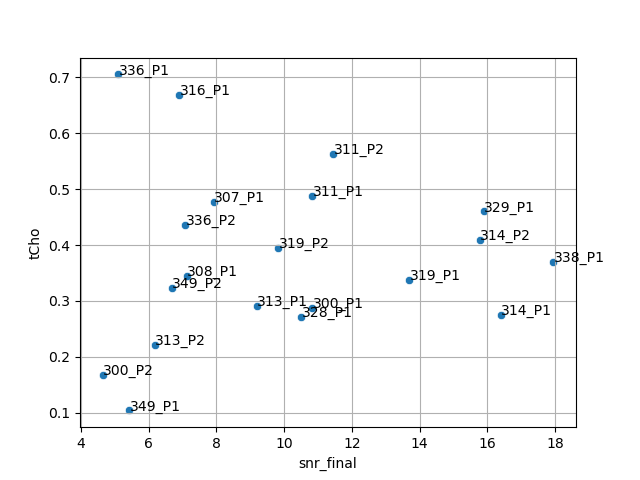

<IPython.core.display.Javascript object>


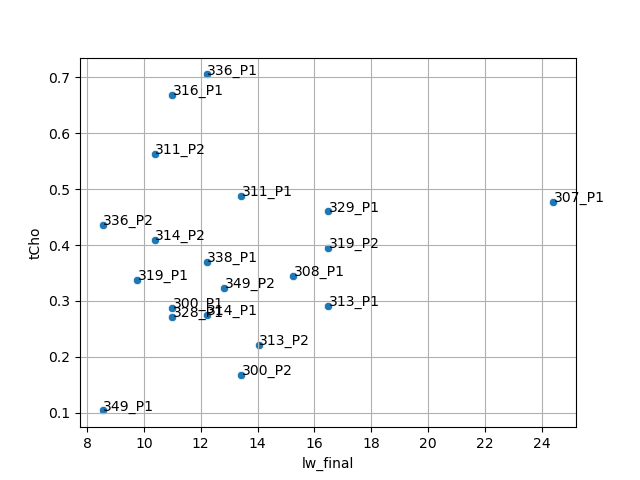

<IPython.core.display.Javascript object>


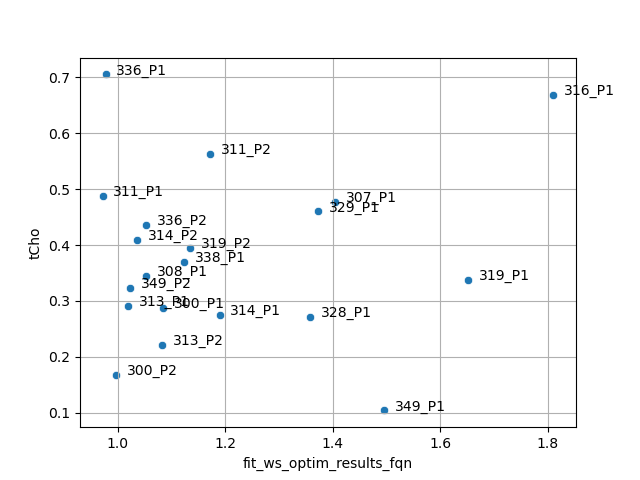

<IPython.core.display.Javascript object>


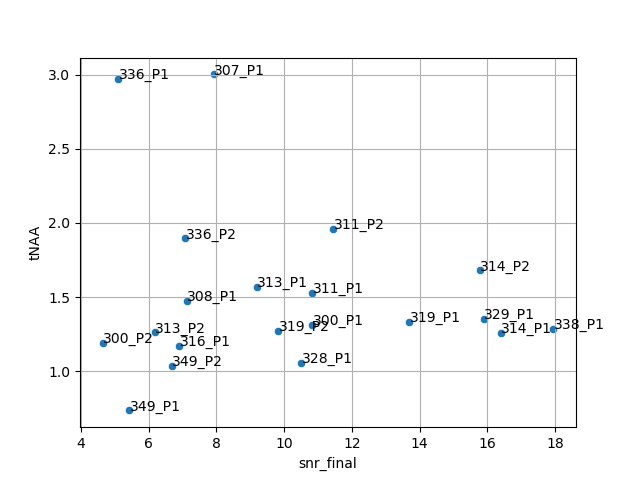

<IPython.core.display.Javascript object>


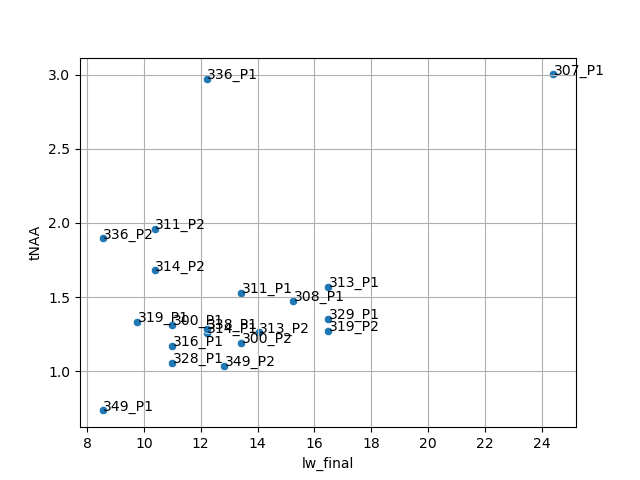

<IPython.core.display.Javascript object>


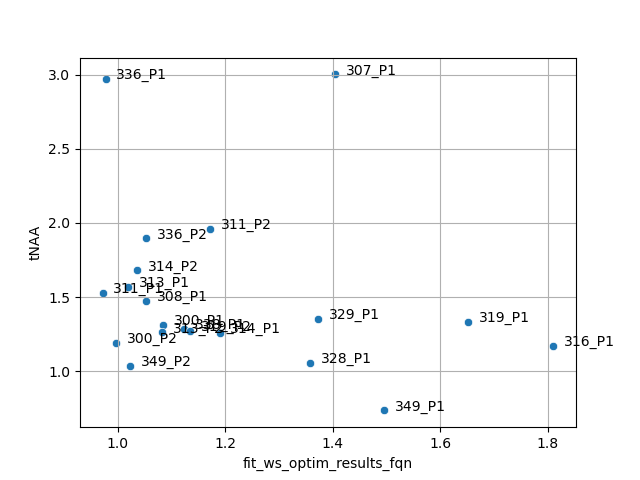

<IPython.core.display.Javascript object>


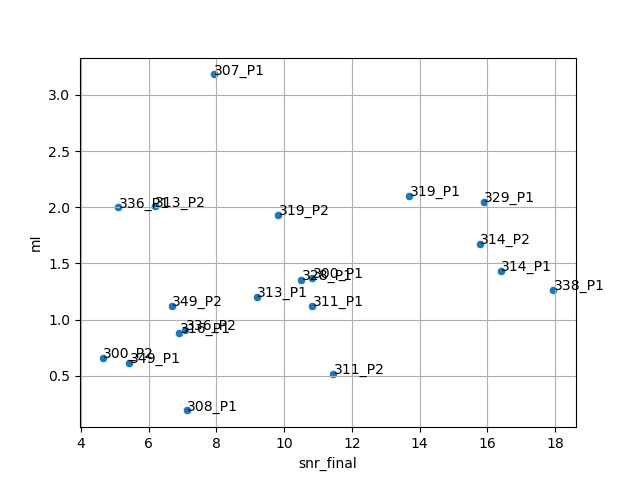

<IPython.core.display.Javascript object>


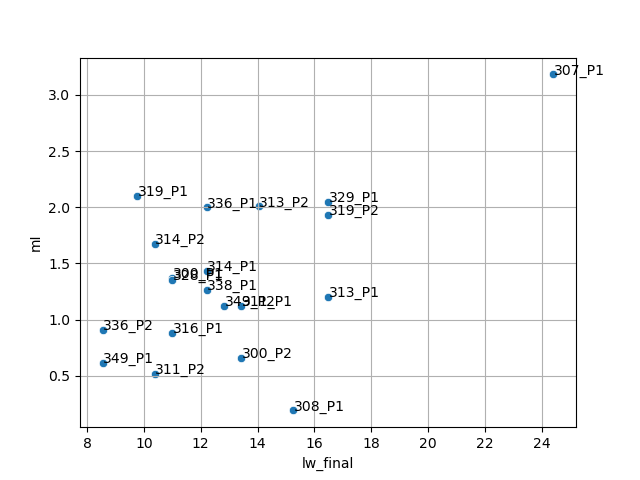

<IPython.core.display.Javascript object>


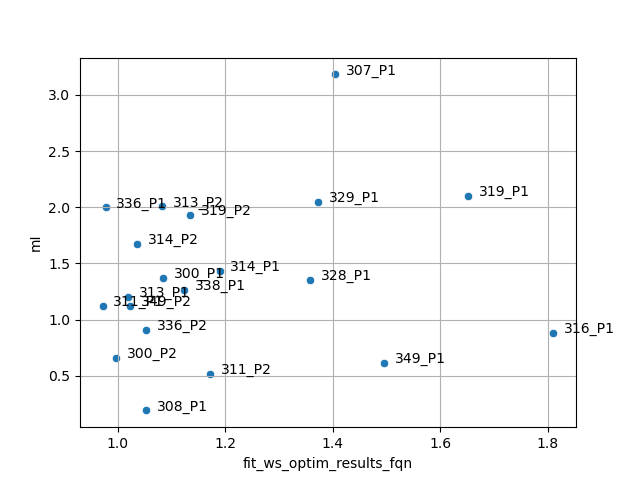

<IPython.core.display.Javascript object>


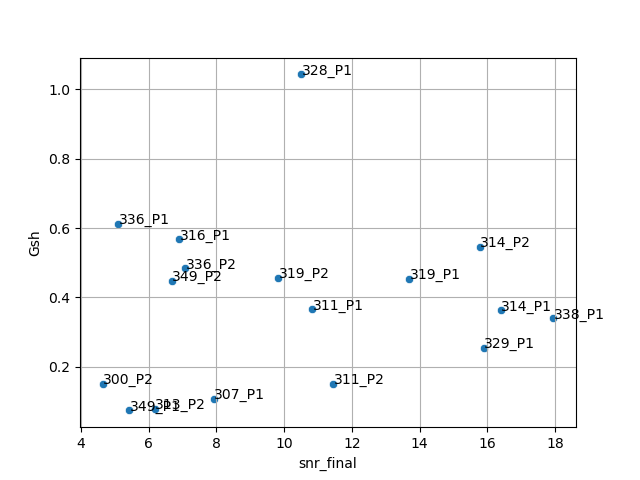

<IPython.core.display.Javascript object>


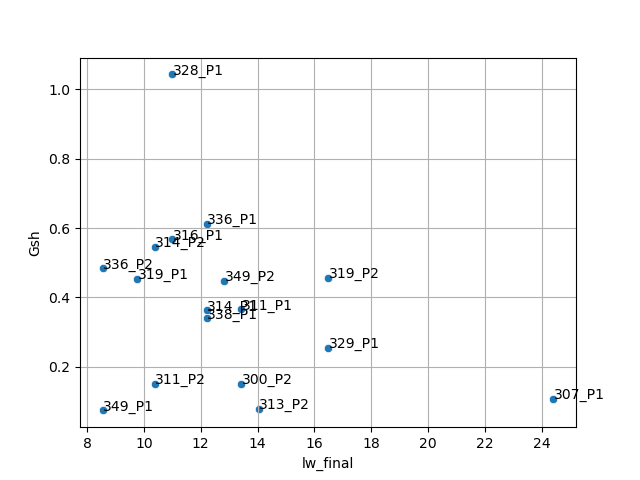

<IPython.core.display.Javascript object>


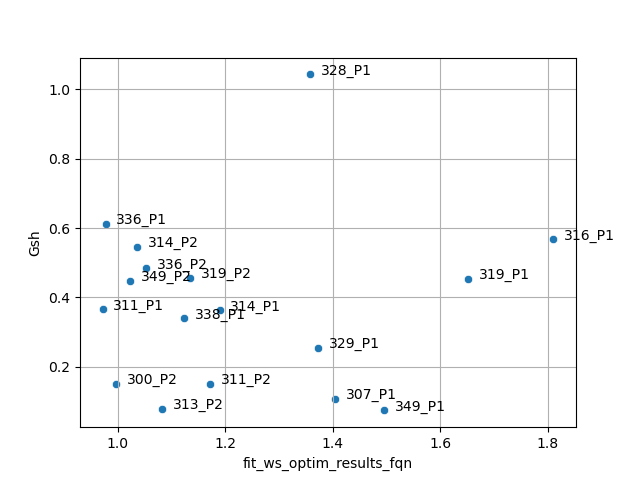

<IPython.core.display.Javascript object>


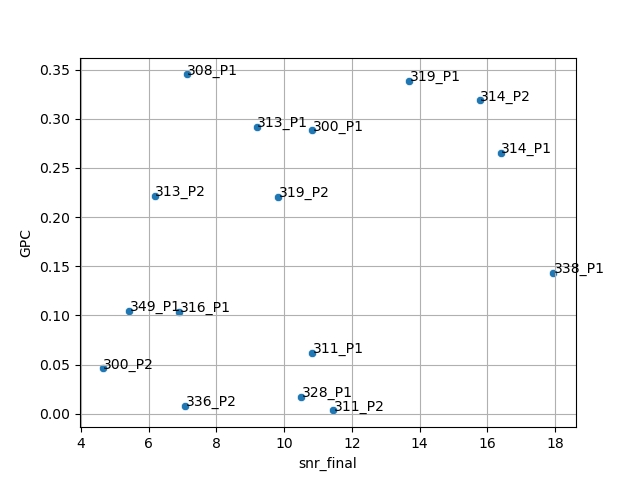

<IPython.core.display.Javascript object>


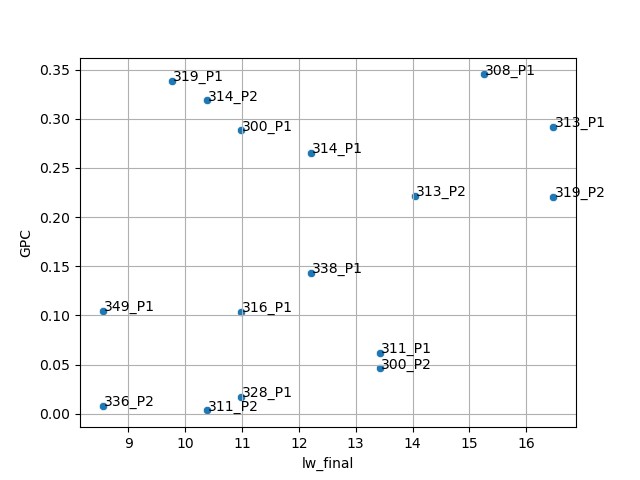

<IPython.core.display.Javascript object>


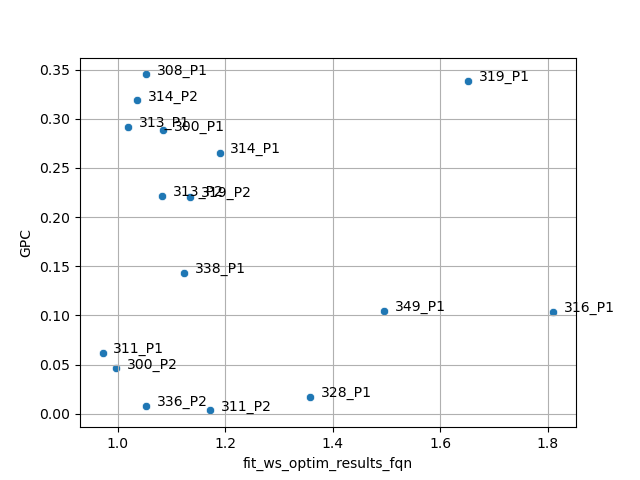

<IPython.core.display.Javascript object>


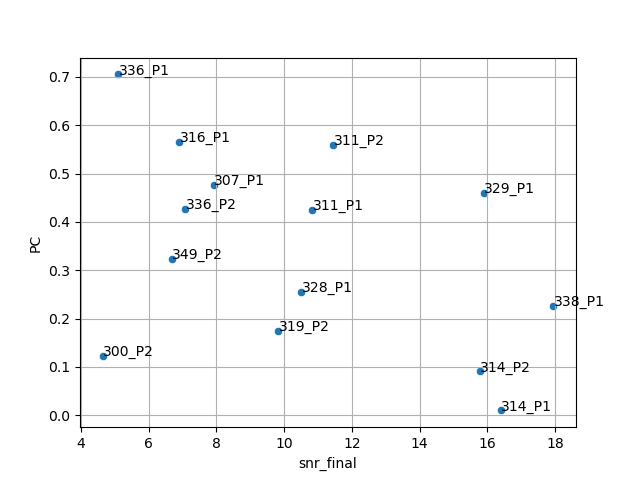

<IPython.core.display.Javascript object>


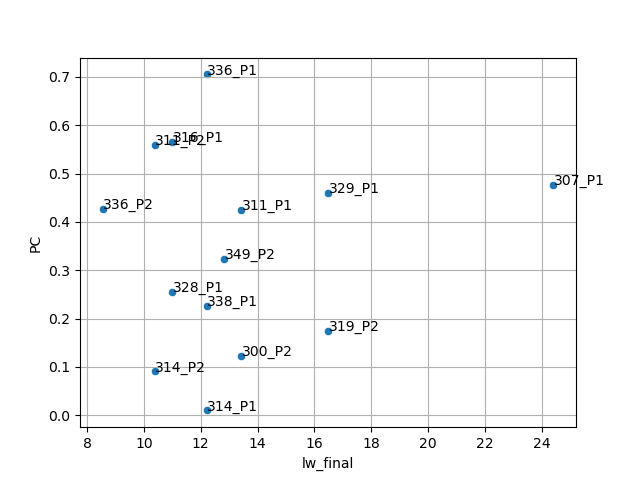

<IPython.core.display.Javascript object>


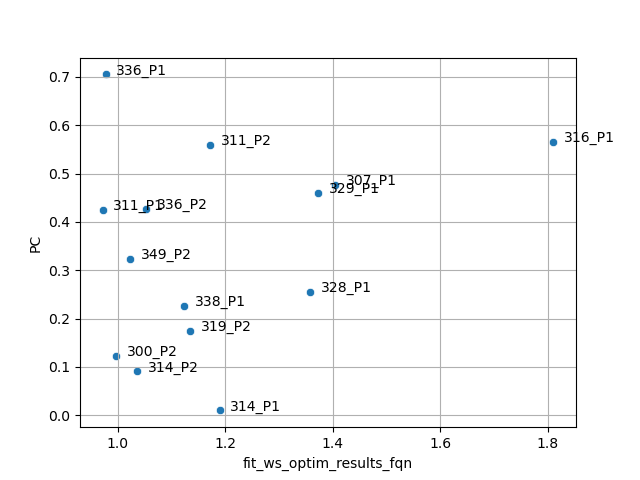

<IPython.core.display.Javascript object>


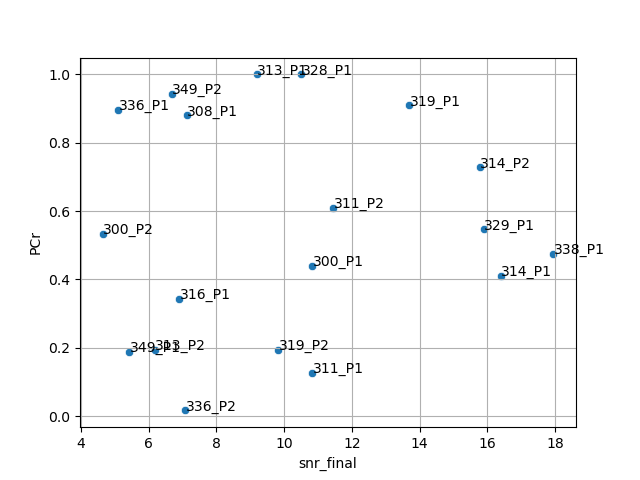

<IPython.core.display.Javascript object>


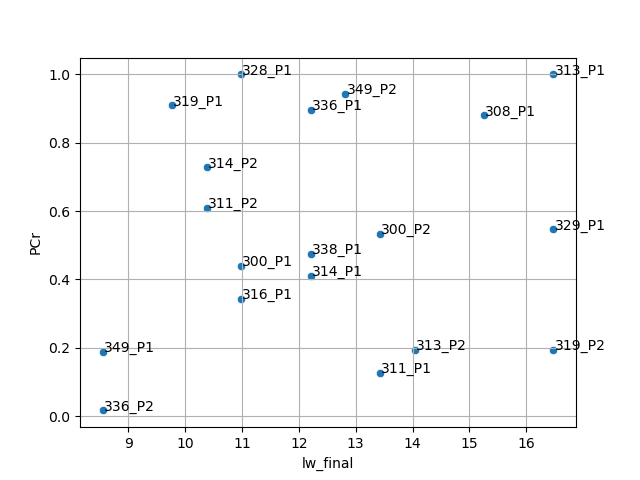

<IPython.core.display.Javascript object>


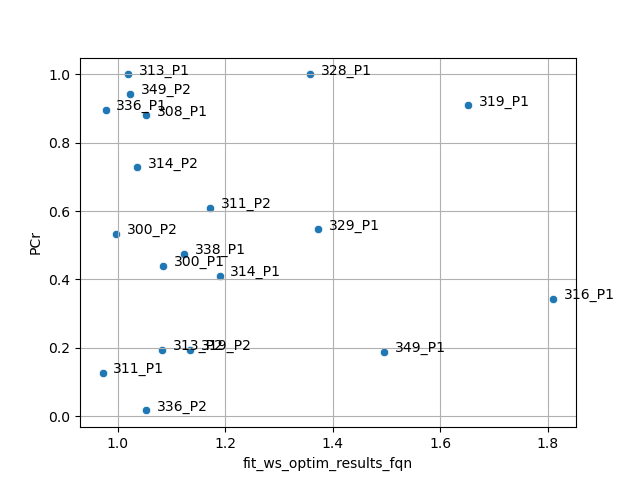

<IPython.core.display.Javascript object>


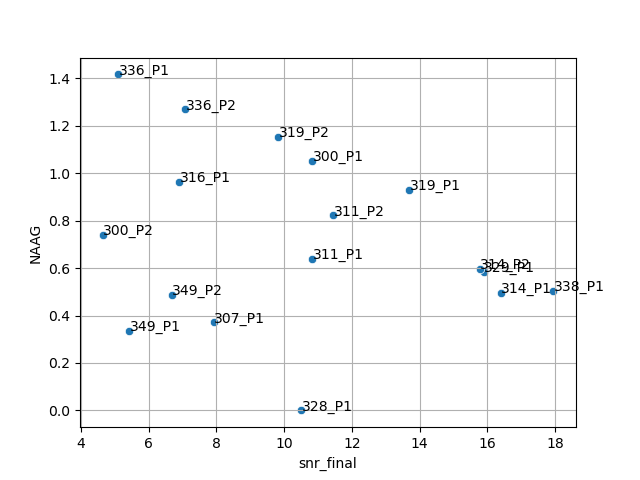

<IPython.core.display.Javascript object>


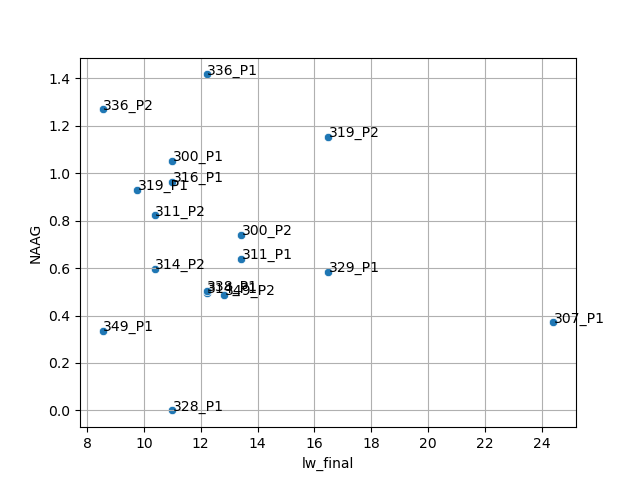

<IPython.core.display.Javascript object>


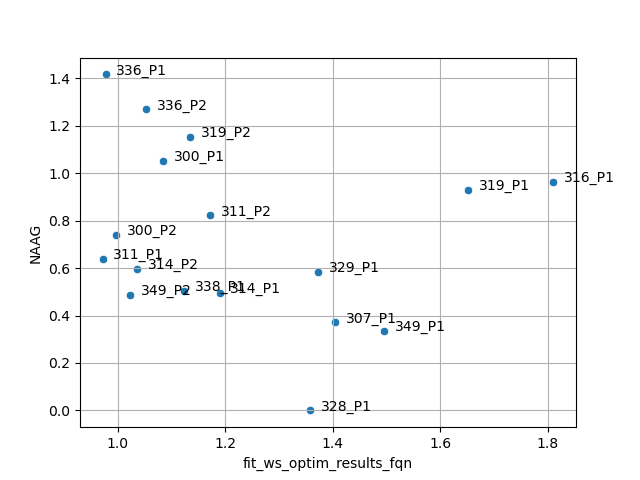

<IPython.core.display.Javascript object>


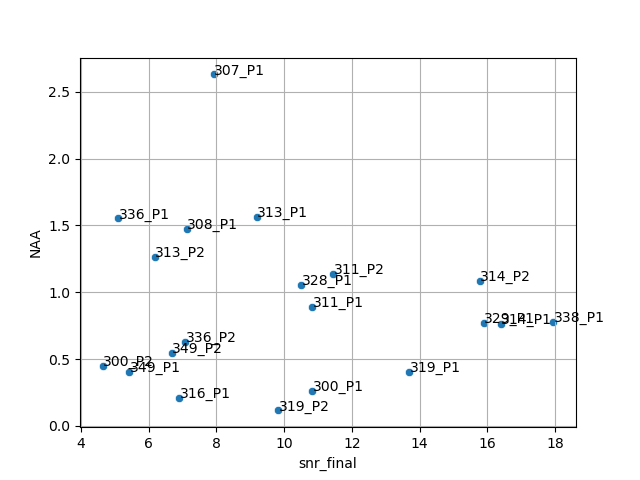

<IPython.core.display.Javascript object>


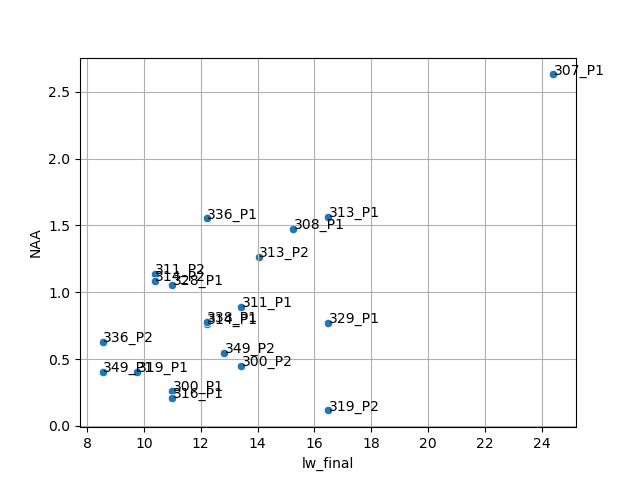

<IPython.core.display.Javascript object>


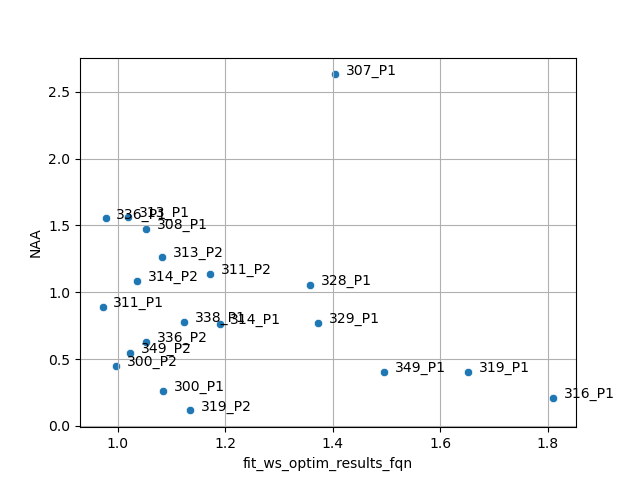

In [37]:
df = df_sc_all_reco.loc[(df_sc_all_reco.index.get_level_values("reco_template_name") == "sc") &
                        (df_sc_all_reco["fit_tool_name"] == "pastis") &
                        (df_sc_all_reco["fit_ws_metabolites_len"] == 15) &
                        (df_sc_all_reco["fit_ws_sequence_str"] == "none")]

# watch ratios per metabolite
for m in ["tCho", "tNAA", "mI", "Gsh", "GPC", "PC", "PCr", "NAAG", "NAA"]:
    this_df = df.loc[(df["param_p_type"] == "fit_ws_params_fit_t2cor_ratio_cm") &
                     (df["param_val_err"] == "val") &  
                     (df["param_m_name"] ==m)]

    this_df = this_df.drop_duplicates(["patient_pass_id", "strategy"])

    plt.figure()
    g = sns.scatterplot(x="snr_final", y="param_val", data=this_df)
    add_labels("snr_final", "param_val", "patient_pass_id", this_df, plt.gca())
    plt.grid('on')
    plt.ylabel(m)

    plt.figure()
    g = sns.scatterplot(x="lw_final", y="param_val", data=this_df)
    add_labels("lw_final", "param_val", "patient_pass_id", this_df, plt.gca())
    plt.grid('on')
    plt.ylabel(m)

    plt.figure()
    g = sns.scatterplot(x="fit_ws_optim_results_fqn", y="param_val", data=this_df)
    add_labels("fit_ws_optim_results_fqn", "param_val", "patient_pass_id", this_df, plt.gca())
    plt.grid('on')
    plt.ylabel(m)

* tCho: 316_P1, 336_P1, 349_P1 are out
* tNAA: 307_P1, 336_P1, 349_P1 are out
* mI: 308_P1, 311_P1, 307_P1, 319_P1, 349_P1 are out

Good news is that...
* 336_P1 has a SNR of 5.1 ;)
* 307_P1 has a LW of 24Hz ;)
* 349_P1 has a SNR of 5.4 ;)
* 316_P1 has a FQN above 1.8 ;)

Thresholding at SNR=6, LW=20Hz and FQN at 1.8 should help

## Annotated CRBs

<IPython.core.display.Javascript object>


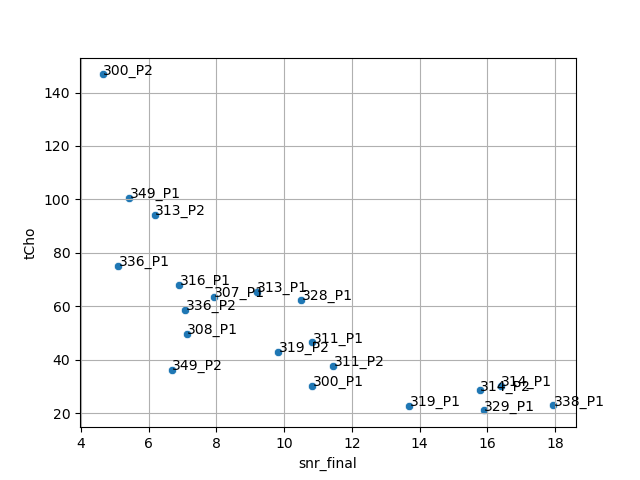

<IPython.core.display.Javascript object>


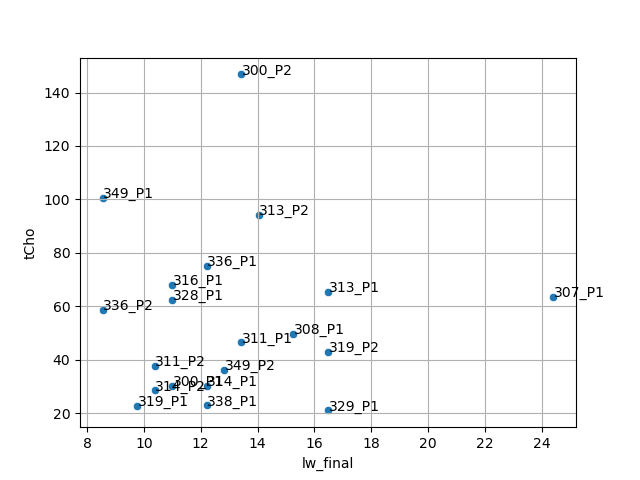

<IPython.core.display.Javascript object>


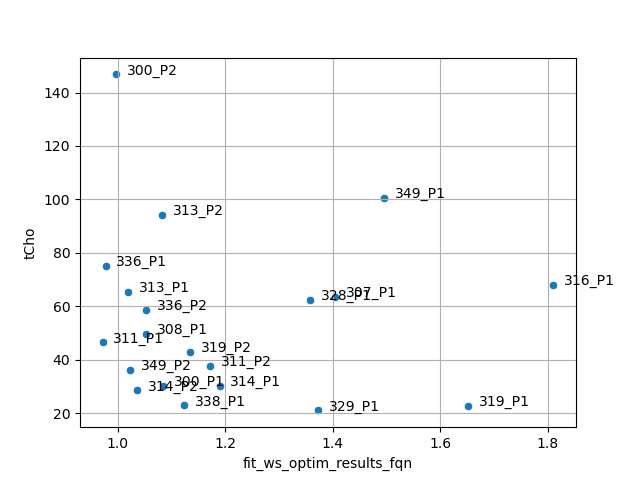

<IPython.core.display.Javascript object>


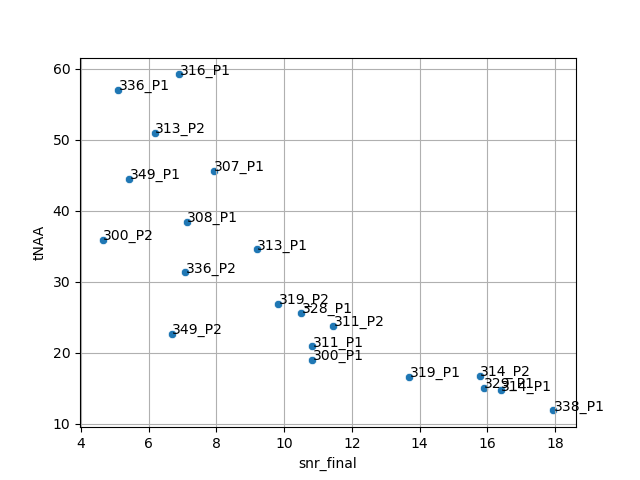

<IPython.core.display.Javascript object>


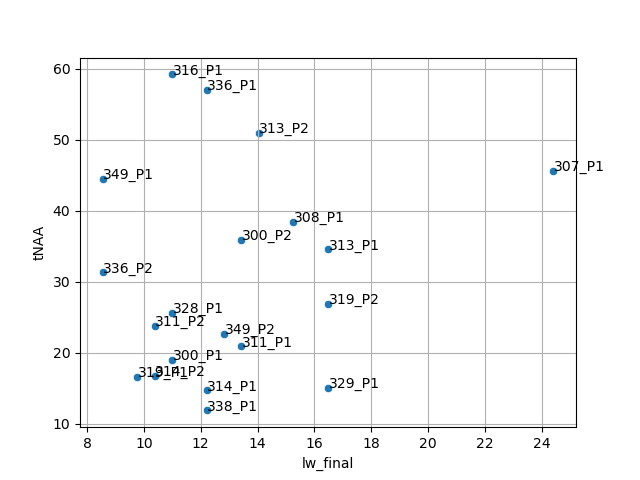

<IPython.core.display.Javascript object>


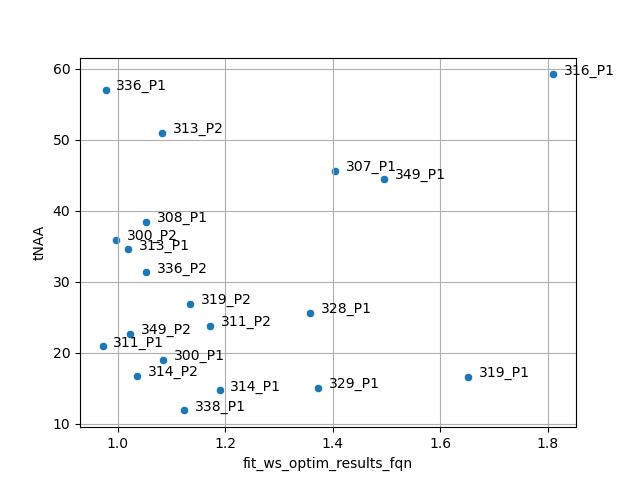

<IPython.core.display.Javascript object>


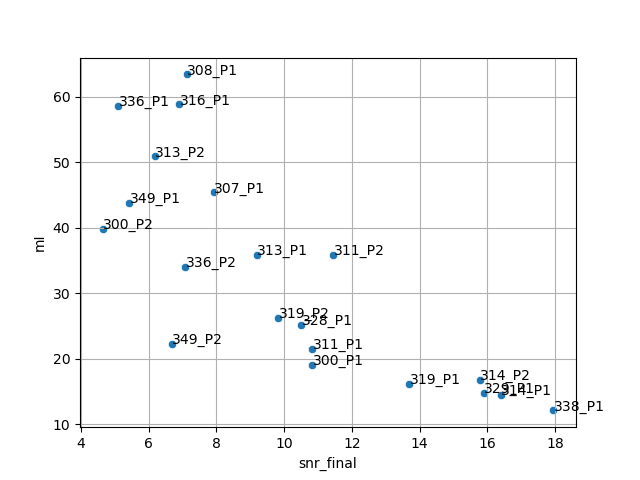

<IPython.core.display.Javascript object>


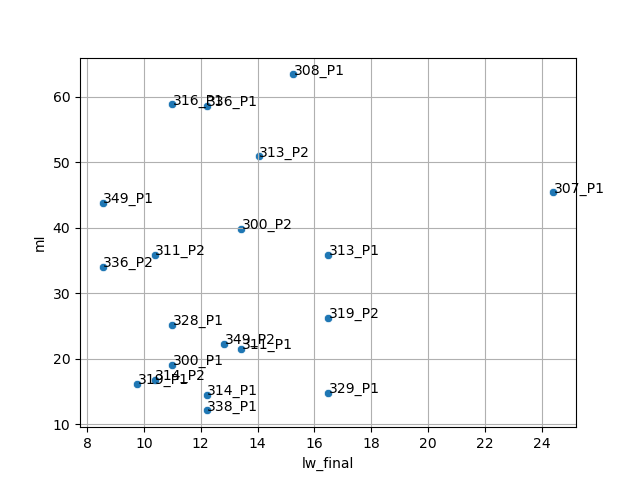

<IPython.core.display.Javascript object>


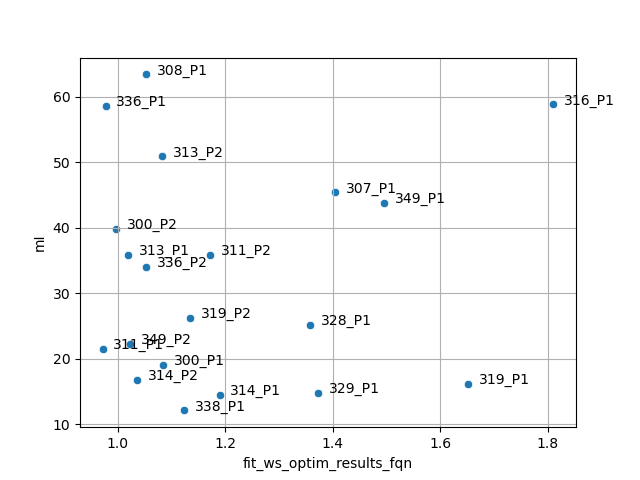

<IPython.core.display.Javascript object>


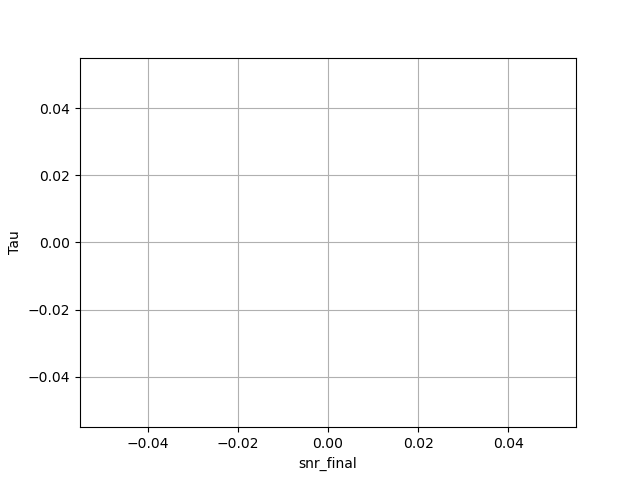

<IPython.core.display.Javascript object>


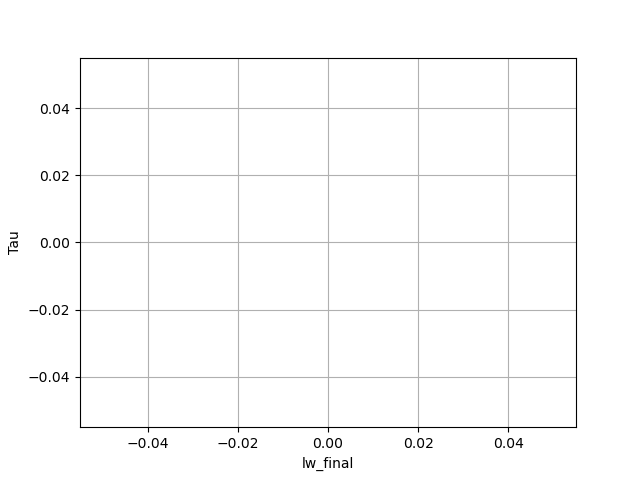

<IPython.core.display.Javascript object>


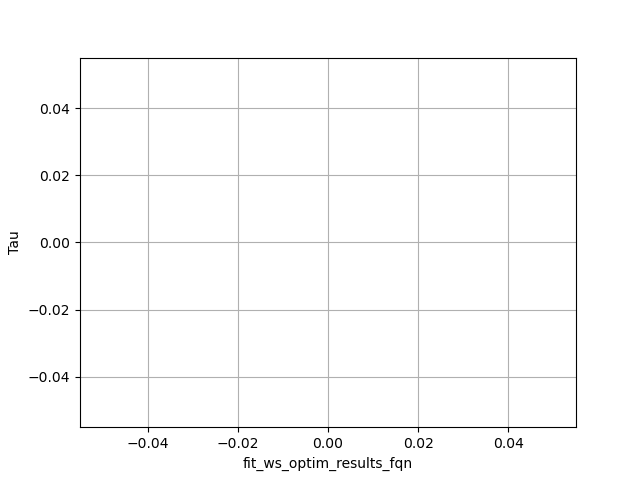

<IPython.core.display.Javascript object>


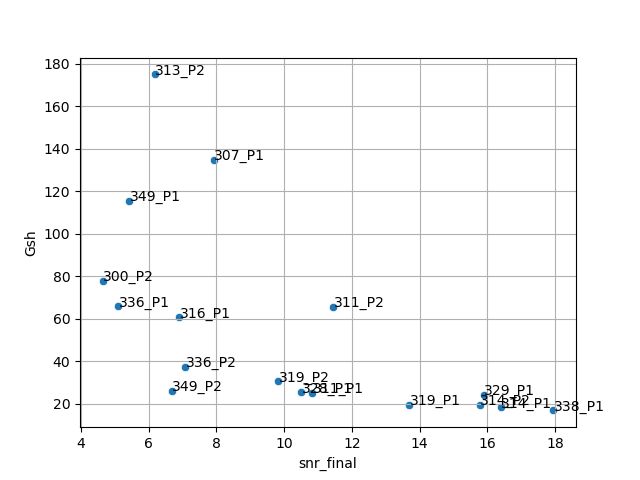

<IPython.core.display.Javascript object>


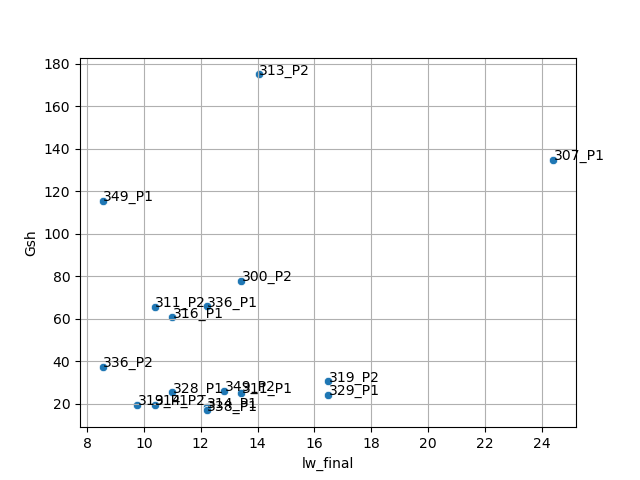

<IPython.core.display.Javascript object>


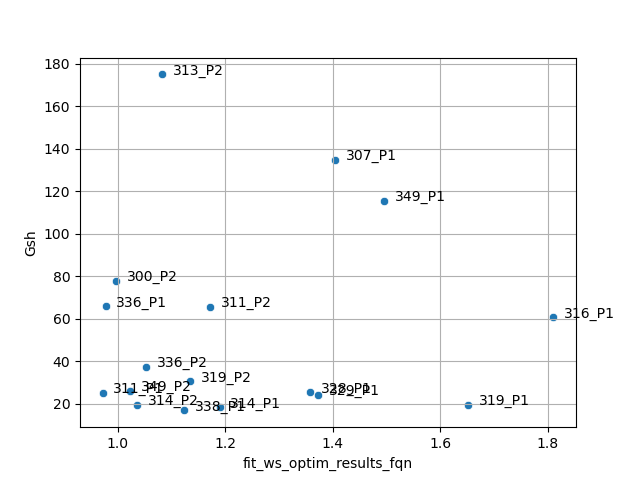

In [38]:
df = df_sc_all_reco.loc[(df_sc_all_reco.index.get_level_values("reco_template_name") == "sc") &
                        (df_sc_all_reco["fit_tool_name"] == "pastis") &
                        (df_sc_all_reco["fit_ws_metabolites_len"] == 15) &
                        (df_sc_all_reco["fit_ws_sequence_str"] == "none")]

# watch ratios per metabolite
for m in ["tCho", "tNAA", "mI", "Tau", "Gsh"]:
    this_df = df.loc[(df["param_p_type"] == "fit_ws_params_fit_t2cor_ratio_cm") &
                     (df["param_val_err"] == "err_prct") &  
                     (df["param_m_name"] ==m)]

    this_df = this_df.drop_duplicates("patient_pass_id")

    plt.figure()
    g = sns.scatterplot(x="snr_final", y="param_val", data=this_df)
    add_labels("snr_final", "param_val", "patient_pass_id", this_df, plt.gca())
    plt.grid('on')
    plt.ylabel(m)

    plt.figure()
    g = sns.scatterplot(x="lw_final", y="param_val", data=this_df)
    add_labels("lw_final", "param_val", "patient_pass_id", this_df, plt.gca())
    plt.grid('on')
    plt.ylabel(m)

    plt.figure()
    g = sns.scatterplot(x="fit_ws_optim_results_fqn", y="param_val", data=this_df)
    add_labels("fit_ws_optim_results_fqn", "param_val", "patient_pass_id", this_df, plt.gca())
    plt.grid('on')
    plt.ylabel(m)

Corrupted CRBs :
* tCho 349_P1
* tNAA & mI 316_P1
* Tau 329_P1
* Gsh 308_P1

# Data quality filtering by SNR & LW & FQN
and take care of orphan patients, etc.

In [39]:
threshold_snr_final = 6
threshold_lw_final = 20
threshold_fqn_final = 1.8

ref_reco_template_name_sc = "sc"
ref_reco_template_name_brain = "brain"
ref_fit_tool_name = "pastis"
ref_fit_ws_metabolites_len = 15
ref_fit_ws_sequence_str = "none"

def filter_by_SNR_LW_FQN(this_df, 
                         this_threshold_snr_final, 
                         this_threshold_lw_final, 
                         this_threshold_fqn_final,
                         this_ref_reco_template_name, 
                         this_ref_fit_tool_name, 
                         this_ref_fit_ws_metabolites_len, 
                         this_ref_fit_ws_sequence_str):

    # add a column
    this_df["included"] = False
    this_df["pass_after_filter"] = this_df["pass"]
    this_df["patient_pass_id_after_filter"] = this_df["patient_pass_id"]
    this_df["patient_pass_id_pretty_after_filter"] = this_df["patient_pass_id_pretty"]

    # keep only the reference reco_template, fit stategies, etc.
    this_df_ref = this_df.loc[(this_df.index.get_level_values("reco_template_name") == this_ref_reco_template_name) &
                            (this_df["fit_tool_name"] == this_ref_fit_tool_name) &
                            (this_df["fit_ws_metabolites_len"] == this_ref_fit_ws_metabolites_len) &
                            (this_df["fit_ws_sequence_str"] == this_ref_fit_ws_sequence_str)]

    # apply SNR/LW/FQN filter
    this_df_ref_filtered = this_df_ref.loc[(this_df_ref["snr_final"] > this_threshold_snr_final) &
                                   (this_df_ref["lw_final"] < this_threshold_lw_final) &
                                   (this_df_ref["fit_ws_optim_results_fqn"] < this_threshold_fqn_final)]

    # remember the data hash indexes to keep
    data_hash_2keep_list = this_df_ref_filtered.index.get_level_values("data_hash").unique().tolist()

    # find pass 1 patients
    this_df_ref_filtered_p1 = this_df_ref_filtered.loc[(this_df_ref_filtered["pass"] == 1)]
    # remember them
    patient_id_p1_list = this_df_ref_filtered_p1["patient_id"].unique().tolist()

    # find pass 2 patients which are not previously found pass 1 list
    this_df_ref_filtered_p2_orphan = this_df_ref_filtered.loc[ (this_df_ref_filtered["pass"] == 2) &
                            ~this_df_ref_filtered["patient_id"].isin(patient_id_p1_list) ]

    # remember their ids
    orphan_patient_id_list = list(this_df_ref_filtered_p2_orphan["patient_id"].unique())
    print("found %d orphan P2 patients. Fixing them..." % len(orphan_patient_id_list))
    print(orphan_patient_id_list)

    # apply filter to whole df
    this_df.loc[this_df.index.get_level_values("data_hash").isin(data_hash_2keep_list), "included"] = True

    # transform the orphan pass 2 patients into pass 1 and rename them
    this_df.loc[this_df["patient_id"].isin(orphan_patient_id_list), "pass_after_filter"] = 1
    this_df.loc[this_df["patient_id"].isin(orphan_patient_id_list), "patient_pass_id_after_filter"] = this_df.loc[this_df["patient_id"].isin(orphan_patient_id_list)]["patient_pass_id"].str.replace("P2", "P1")
    this_df.loc[this_df["patient_id"].isin(orphan_patient_id_list), "patient_pass_id_pretty_after_filter"] = this_df.loc[this_df["patient_id"].isin(orphan_patient_id_list)]["patient_pass_id_pretty"].str.replace("P2", "P1")

    # print stuff
    nP1_orig = len(this_df.loc[(this_df["pass"] == 1)].drop_duplicates("patient_id"))
    nP2_orig = len(this_df.loc[(this_df["pass"] == 2)].drop_duplicates("patient_id"))
    nP1_after_filter = len(this_df.loc[this_df["included"] & (this_df["pass_after_filter"] == 1)].drop_duplicates("patient_id"))
    nP2_after_filter = len(this_df.loc[this_df["included"] & (this_df["pass_after_filter"] == 2)].drop_duplicates("patient_id"))
    prct_reject = nP1_after_filter / nP1_orig * 100
    print("n (P1) = %d / %d (%.2f%% included)" % (nP1_after_filter, nP1_orig, prct_reject))
    print("n (P2) = %d / %d" % (nP2_after_filter, nP2_orig))

    return(this_df)

df_sc_all_reco = filter_by_SNR_LW_FQN(df_sc_all_reco, 
                                        threshold_snr_final,
                                        threshold_lw_final,
                                        threshold_fqn_final,
                                        ref_reco_template_name_sc, 
                                        ref_fit_tool_name, 
                                        ref_fit_ws_metabolites_len, 
                                        ref_fit_ws_sequence_str)

df_brain = filter_by_SNR_LW_FQN(df_brain, 
                                        threshold_snr_final,
                                        threshold_lw_final,
                                        threshold_fqn_final,
                                        ref_reco_template_name_brain, 
                                        ref_fit_tool_name, 
                                        ref_fit_ws_metabolites_len, 
                                        ref_fit_ws_sequence_str)


found 2 orphan P2 patients. Fixing them...
['336', '349']
n (P1) = 11 / 13 (84.62% included)
n (P2) = 4 / 7
found 0 orphan P2 patients. Fixing them...
[]
n (P1) = 3 / 3 (100.00% included)
n (P2) = 0 / 0


# [FIG] SNR & LW & FQN scatter plot

In [40]:
df = df_sc_all_reco.loc[(df_sc_all_reco.index.get_level_values("reco_template_name") == "sc") &
                        (df_sc_all_reco["fit_tool_name"] == "pastis") &
                        (df_sc_all_reco["fit_ws_metabolites_len"] == 15) &
                        (df_sc_all_reco["fit_ws_sequence_str"] == "none")].drop_duplicates("patient_pass_id")

print("There is %d datasets included" % len(df.loc[df["included"]]))
print("There is %d datasets excluded" % len(df.loc[~df["included"]]))
print("Datasets rejected (%%) = %.2f" % (len(df.loc[~df["included"]]) / len(df) * 100))

print("--- All datasets ---")
print("Mean SNR = %.2f (%.2f)" % (df["snr_final"].mean(),
                                    df["snr_final"].std()))
print("Range SNR = [%.2f - %.2f]" % (df["snr_final"].min(),
                                    df["snr_final"].max()))
print("Mean FWHM = %.2f ppm (%.2f)" % (df["lw_final"].mean() / (7 * 42.576),
                                        df["lw_final"].std() / (7 * 42.576)))
print("Mean FWHM = %.2f Hz (%.2f)" % (df["lw_final"].mean(),
                                        df["lw_final"].std()))
print("Mean FQN = %.2f (%.2f)" % (df["fit_ws_optim_results_fqn"].mean(), 
                                    df["fit_ws_optim_results_fqn"].std()))

print("--- Included datasets ---")
print("Mean SNR = %.2f (%.2f)" % (df.loc[df["included"]]["snr_final"].mean(),
                                    df.loc[df["included"]]["snr_final"].std()))
print("Range SNR = [%.2f - %.2f]" % (df.loc[df["included"]]["snr_final"].min(),
                                    df.loc[df["included"]]["snr_final"].max()))
print("Mean FWHM = %.2f ppm (%.2f)" % (df.loc[df["included"]]["lw_final"].mean() / (7 * 42.576),
                                        df.loc[df["included"]]["lw_final"].std() / (7 * 42.576)))
print("Mean FWHM = %.2f Hz (%.2f)" % (df.loc[df["included"]]["lw_final"].mean(),
                                        df.loc[df["included"]]["lw_final"].std()))
print("Mean FQN = %.2f (%.2f)" % (df.loc[df["included"]]["fit_ws_optim_results_fqn"].mean(), 
                                    df.loc[df["included"]]["fit_ws_optim_results_fqn"].std()))


There is 15 datasets included
There is 5 datasets excluded
Datasets rejected (%) = 25.00
--- All datasets ---
Mean SNR = 9.96 (4.11)
Range SNR = [4.64 - 17.95]
Mean FWHM = 0.04 ppm (0.01)
Mean FWHM = 13.00 Hz (3.64)
Mean FQN = 1.20 (0.24)
--- Included datasets ---
Mean SNR = 11.29 (3.85)
Range SNR = [6.18 - 17.95]
Mean FWHM = 0.04 ppm (0.01)
Mean FWHM = 12.70 Hz (2.60)
Mean FQN = 1.15 (0.18)


n = 21


<IPython.core.display.Javascript object>


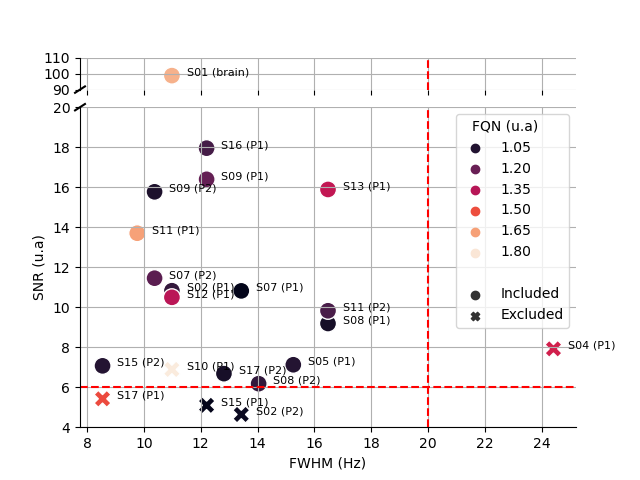

patient_pass_id  \
data_hash                        reco_template_name fit_ws_fit_hash                                    
2fff316122fc89a0b4d1f918f6cd62d8 sc                 73f4302c757d7e3622fb98fd7a6b3824          300_P1   
1baf6b702f39fefb5ad9e44179057ef7 sc                 5261b51397dd19babd28d606a7210c05          307_P1   
a2b582b37a04bd4efc43138368bc0b96 sc                 0d2abfc939ca09700c5bc46fad8b22c7          308_P1   
7cb024e470b0b2b072436635a19a1c00 sc                 9127f2738cf1f200695a7ab266726201          311_P1   
9f8067ea065153da5b3a352d58f6ca23 sc                 63994c64fa037535ed16e5ffdb237d17          313_P1   
0a58f85af8c32d06cbbca74391447ad2 sc                 af051b5bacf6bf30beef8c8b16dae526          314_P1   
5f9a42662bfe3586bee57f3ead964778 sc                 11ee9a99687c452c6dc93b1af6541121          316_P1   
f416f6db6cda52195e3b8046fc586ef2 sc                 2cc6262882c992a42f28390e11347b2a          319_P1   
b9875913db5c0f321922f819401cc02e sc                 6767bb388dd77500c08501de941e50f9          328_P1   
fc8cb0e8f7b3747a10eeabc1cf8ab9fb sc                 1f875649d5045fee2ec01b077c03ca4a          329_P1   
2e9c959e58727727c1576108fb6ef2b9 sc                 402f2dd464a9b79d0bc05388951a67dc          336_P1   
afb10548c794ebbf8bd304be1f52b0c1 sc                 89739136d8bdb62443d8941167038542          338_P1   
ef31f01b58b8279ef0df239b6d15a055 sc                 e585f36f65af4c1c1a268ca712261cfe          300_P2   
62f4072c25c940cd1bfcb41a560749e2 sc                 3e0a5cb03e05749551f7f891e188f8ab          349_P1   
75ae13bc44bf3d55f5be46d4c59df84d sc                 3328c9098999a754a37199b071c91ace          311_P2   
967a1b8dace220e916df680759f31d84 sc                 ec4577b78be34d4528be3db348edfcae          336_P2   
90d883145e25fe54b74b05c16b56ace1 sc                 e23d5b6de2b1b64af2d04415d3c5bd12          319_P2   
e8481853cde6f05d66b1c43d8dd00e40 sc                 92ec346c269b08df9309e113d24966ab          313_P2   
e2c8b162388ff1d24dca288885b87e4b sc                 4292ee4ac988ef2077b193fc794ec509          314_P2   
45b70edaa2460689b120a7ed10a1f6e1 sc                 33ea2552be2ae503107da25e20834c1b          349_P2   
b057a3e07319341e032e3c6c36ec4d83 brain              9deed7af7e44933cb4087f3e90912e0f          296_P1   

                                                                                      included  
data_hash                        reco_template_name fit_ws_fit_hash                             
2fff316122fc89a0b4d1f918f6cd62d8 sc                 73f4302c757d7e3622fb98fd7a6b3824      True  
1baf6b702f39fefb5ad9e44179057ef7 sc                 5261b51397dd19babd28d606a7210c05     False  
a2b582b37a04bd4efc43138368bc0b96 sc                 0d2abfc939ca09700c5bc46fad8b22c7      True  
7cb024e470b0b2b072436635a19a1c00 sc                 9127f2738cf1f200695a7ab266726201      True  
9f8067ea065153da5b3a352d58f6ca23 sc                 63994c64fa037535ed16e5ffdb237d17      True  
0a58f85af8c32d06cbbca74391447ad2 sc                 af051b5bacf6bf30beef8c8b16dae526      True  
5f9a42662bfe3586bee57f3ead964778 sc                 11ee9a99687c452c6dc93b1af6541121     False  
f416f6db6cda52195e3b8046fc586ef2 sc                 2cc6262882c992a42f28390e11347b2a      True  
b9875913db5c0f321922f819401cc02e sc                 6767bb388dd77500c08501de941e50f9      True  
fc8cb0e8f7b3747a10eeabc1cf8ab9fb sc                 1f875649d5045fee2ec01b077c03ca4a      True  
2e9c959e58727727c1576108fb6ef2b9 sc                 402f2dd464a9b79d0bc05388951a67dc     False  
afb10548c794ebbf8bd304be1f52b0c1 sc                 89739136d8bdb62443d8941167038542      True  
ef31f01b58b8279ef0df239b6d15a055 sc                 e585f36f65af4c1c1a268ca712261cfe     False  
62f4072c25c940cd1bfcb41a560749e2 sc                 3e0a5cb03e05749551f7f891e188f8ab     False  
75ae13bc44bf3d55f5be46d4c59df84d sc                 3328c9098999a754a37199b071c91ace      True  
967a1b8dace220e916df680759f31d84 sc        

In [41]:
this_df = df

# making an empty col for Included/Excluded
this_df[" "] = "Included"
this_df.loc[~this_df["included"], " "] = "Excluded"

# add best brain dataset
this_df_brain = df_brain.loc[(df_brain.index.get_level_values("reco_template_name") == "brain") &
                        (df_brain["fit_tool_name"] == "pastis") &
                        (df_brain["fit_ws_metabolites_len"] == 15) &
                        (df_brain["fit_ws_sequence_str"] == "none")].drop_duplicates("patient_pass_id")
this_df_brain = this_df_brain.loc[ (this_df_brain["snr_final"] == this_df_brain["snr_final"].max())]

this_df_brain = this_df_brain.drop_duplicates("patient_pass_id")
this_df_brain[" "] = "Included"

# concat and rename scale labels
this_df = pd.concat([this_df, this_df_brain])
this_df = this_df.rename(columns = {'snr_final':'SNR (u.a)'})
this_df = this_df.rename(columns = {'lw_final':'FWHM (Hz)'})
this_df = this_df.rename(columns = {'fit_ws_optim_results_fqn':'FQN (u.a)'})

print("n = %d" % len(this_df))

# broken axis scatter plot
cm = sns.color_palette("rocket", as_cmap=True)
f, (ax_top, ax_bottom) = plt.subplots(ncols=1, nrows=2, sharex=True,
                                      gridspec_kw={'hspace':0.10, 'height_ratios':[1, 10]})
g = sns.scatterplot(x="FWHM (Hz)", y="SNR (u.a)",
                palette=cm, hue="FQN (u.a)",
                style=" ", style_order=["Included", "Excluded"],
                s=150, data=this_df, ax=ax_top, legend=False)

ax_top.grid(True)
ax_top.axhline(threshold_snr_final, color='r', linestyle='--')
ax_top.axvline(threshold_lw_final, color='r', linestyle='--')

this_df_labels = this_df.loc[(this_df["SNR (u.a)"] > 50)]
this_df_labels = this_df_labels.drop_duplicates("patient_pass_id")
add_labels("FWHM (Hz)", "SNR (u.a)", "patient_pass_id_pretty", this_df_labels, ax_top, 8, 0.5, 0.0)

g = sns.scatterplot(x="FWHM (Hz)", y="SNR (u.a)",
                palette=cm, hue="FQN (u.a)",
                style=" ", style_order=["Included", "Excluded"],
                s=150, data=this_df, ax=ax_bottom)
ax_bottom.grid(True)
ax_bottom.axhline(threshold_snr_final, color='r', linestyle='--')
ax_bottom.axvline(threshold_lw_final, color='r', linestyle='--')

this_df_labels = this_df.loc[(this_df["SNR (u.a)"] < 50)]
this_df_labels = this_df_labels.drop_duplicates("patient_pass_id")
add_labels("FWHM (Hz)", "SNR (u.a)", "patient_pass_id_pretty", this_df_labels, ax_bottom, 8, 0.5, 0.0)

ax_top.set_ylim([90, 110])
ax_top.set_ylabel("")
ax_bottom.set_ylim(4, 20)
sns.despine(ax=ax_bottom)
sns.despine(ax=ax_top, bottom=True)

# draw the small break sign
ax = ax_top
d = .01
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d*10, +d*10), **kwargs)
ax2 = ax_bottom
kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)

plt.savefig("./notebooks/figs/fig_snr_lw.svg")

this_df[["patient_pass_id", "included"]]

# Stats: data acquisition, quality
## Height & Weight & BMI

In [42]:
print("--- before filtering ---")
df = df_sc_all_reco.loc[(df_sc_all_reco["pass"] == 1)].drop_duplicates("patient_id")

print("n = %d" % len(df))

print("Mean weight = %.2fkgs +/-%.2f" % (df["patient_weight"].mean(), df["patient_weight"].std()))
print("Mean height = %.2fm +/-%.2f" % (df["patient_height"].mean(), df["patient_height"].std()))
print("Mean BMI = %.2f +/-%.2f" % (df["patient_bmi"].mean(), df["patient_bmi"].std()))
print("Median BMI = %.2f" % (df["patient_bmi"].median()))

sex_counts = df.groupby("patient_sex")
print("Sex = M(%d) F(%d)" % (df.loc[sex_counts.groups["M"]]["patient_id"].nunique(), 
                             df.loc[sex_counts.groups["F"]]["patient_id"].nunique()))

--- before filtering ---
n = 13
Mean weight = 57.15kgs +/-14.79
Mean height = 1.65m +/-0.13
Mean BMI = 20.56 +/-2.89
Median BMI = 20.55
Sex = M(4) F(9)


In [43]:
print("--- after filtering ---")
df = df_sc_all_reco.loc[(df_sc_all_reco["pass"] == 1) &
                        (df_sc_all_reco["included"] == True)].drop_duplicates("patient_id")

print("n = %d" % len(df))

print("Mean weight = %.2fkgs +/-%.2f" % (df["patient_weight"].mean(), df["patient_weight"].std()))
print("Mean height = %.2fm +/-%.2f" % (df["patient_height"].mean(), df["patient_height"].std()))
print("Mean BMI = %.2f +/-%.2f" % (df["patient_bmi"].mean(), df["patient_bmi"].std()))

sex_counts = df.groupby("patient_sex")
print("Sex = M(%d) F(%d)" % (df.loc[sex_counts.groups["M"]]["patient_id"].nunique(), 
                             df.loc[sex_counts.groups["F"]]["patient_id"].nunique()))

--- after filtering ---
n = 9
Mean weight = 56.00kgs +/-17.26
Mean height = 1.64m +/-0.14
Mean BMI = 20.34 +/-3.41
Sex = M(3) F(6)


## Average voxel size

In [44]:
df = df_sc_all_reco.drop_duplicates(["patient_pass_id"])

print("n = %d" % len(df))

print("* Voxel volume (cm3) = %.2f (%.2f)" % (df["voxel_vol_cm3"].mean(), 
                                              df["voxel_vol_cm3"].std()))

print("* Voxel X dimension (mm) = %.2f (%.2f)" % (df["voxel_size_x_mm"].mean(), 
                                              df["voxel_size_x_mm"].std()))
print("* Voxel Y dimension (mm) = %.2f (%.2f)" % (df["voxel_size_y_mm"].mean(), 
                                              df["voxel_size_y_mm"].std()))
print("* Voxel Z dimension (mm) = %.2f (%.2f)" % (df["voxel_size_z_mm"].mean(), 
                                              df["voxel_size_z_mm"].std()))

n = 20
* Voxel volume (cm3) = 0.97 (0.36)
* Voxel X dimension (mm) = 6.95 (1.39)
* Voxel Y dimension (mm) = 6.50 (0.89)
* Voxel Z dimension (mm) = 21.05 (2.52)


In [45]:
df["voxel_size_x_mm"]

data_hash                         reco_template_name  fit_ws_fit_hash                 
2fff316122fc89a0b4d1f918f6cd62d8  sc                  7d96241c363652b0d70ebccbd5d4c1de     9.000000
1baf6b702f39fefb5ad9e44179057ef7  sc                  636d824ae7aaa77369cc7d5cd8b6a57f     8.000003
a2b582b37a04bd4efc43138368bc0b96  sc                  e9e2691fe7159800b4a722d21d1b4085     6.000002
7cb024e470b0b2b072436635a19a1c00  sc                  a943d9106d19e30d52b8b0c0b7f2ffd3     9.000000
9f8067ea065153da5b3a352d58f6ca23  sc                  2c72c79e19afade75f72393adf527f8b     7.999996
0a58f85af8c32d06cbbca74391447ad2  sc                  bcb6ddda74e9594f9bfd5e90a9bcef15     7.999997
5f9a42662bfe3586bee57f3ead964778  sc                  d359fd0d6a924c4d082b919f7a5666b1     5.999998
f416f6db6cda52195e3b8046fc586ef2  sc                  06f202c3a55bccfba72daf3c548a0ea0    10.000004
b9875913db5c0f321922f819401cc02e  sc                  93262c5777ef3f0e3118b3b5d1c7536e     6.000000
fc8cb0e8f7b37

In [46]:
df["voxel_size_y_mm"]

data_hash                         reco_template_name  fit_ws_fit_hash                 
2fff316122fc89a0b4d1f918f6cd62d8  sc                  7d96241c363652b0d70ebccbd5d4c1de    8.000000
1baf6b702f39fefb5ad9e44179057ef7  sc                  636d824ae7aaa77369cc7d5cd8b6a57f    8.000000
a2b582b37a04bd4efc43138368bc0b96  sc                  e9e2691fe7159800b4a722d21d1b4085    6.000000
7cb024e470b0b2b072436635a19a1c00  sc                  a943d9106d19e30d52b8b0c0b7f2ffd3    8.000002
9f8067ea065153da5b3a352d58f6ca23  sc                  2c72c79e19afade75f72393adf527f8b    6.000000
0a58f85af8c32d06cbbca74391447ad2  sc                  bcb6ddda74e9594f9bfd5e90a9bcef15    7.999997
5f9a42662bfe3586bee57f3ead964778  sc                  d359fd0d6a924c4d082b919f7a5666b1    5.999998
f416f6db6cda52195e3b8046fc586ef2  sc                  06f202c3a55bccfba72daf3c548a0ea0    8.000003
b9875913db5c0f321922f819401cc02e  sc                  93262c5777ef3f0e3118b3b5d1c7536e    5.999999
fc8cb0e8f7b3747a10eeab

In [47]:
df["voxel_size_z_mm"]

data_hash                         reco_template_name  fit_ws_fit_hash                 
2fff316122fc89a0b4d1f918f6cd62d8  sc                  7d96241c363652b0d70ebccbd5d4c1de    20.000000
1baf6b702f39fefb5ad9e44179057ef7  sc                  636d824ae7aaa77369cc7d5cd8b6a57f    20.000007
a2b582b37a04bd4efc43138368bc0b96  sc                  e9e2691fe7159800b4a722d21d1b4085    20.000005
7cb024e470b0b2b072436635a19a1c00  sc                  a943d9106d19e30d52b8b0c0b7f2ffd3    20.000004
9f8067ea065153da5b3a352d58f6ca23  sc                  2c72c79e19afade75f72393adf527f8b    22.999989
0a58f85af8c32d06cbbca74391447ad2  sc                  bcb6ddda74e9594f9bfd5e90a9bcef15    20.000000
5f9a42662bfe3586bee57f3ead964778  sc                  d359fd0d6a924c4d082b919f7a5666b1    20.000000
f416f6db6cda52195e3b8046fc586ef2  sc                  06f202c3a55bccfba72daf3c548a0ea0    25.000000
b9875913db5c0f321922f819401cc02e  sc                  93262c5777ef3f0e3118b3b5d1c7536e    22.999995
fc8cb0e8f7b37

## CSDE
Chemical shift displacement errors?

In [48]:
print("n = %d" % len(df))

print("* X dimension (%%/ppm) = %.2f" % df["csde_x"].mean())
print("* Y dimension (%%/ppm) = %.2f" % df["csde_y"].mean())
print("* Z dimension (%%/ppm) = %.2f" % df["csde_z"].mean())

print("* For protocol(i)?")
print("* X dimension (%%/ppm) = %.2f" % df.loc[df["reco_dataset_raw_data_sequence_pulse_rfc_r"] >=20]["csde_x"].mean())
print("* Y dimension (%%/ppm) = %.2f" % df.loc[df["reco_dataset_raw_data_sequence_pulse_rfc_r"] >=20]["csde_y"].mean())
print("* Z dimension (%%/ppm) = %.2f" % df.loc[df["reco_dataset_raw_data_sequence_pulse_rfc_r"] >=20]["csde_z"].mean())

print("* For protocol(ii)?")
print("* X dimension (%%/ppm) = %.2f" % df.loc[df["reco_dataset_raw_data_sequence_pulse_rfc_r"] <20]["csde_x"].mean())
print("* Y dimension (%%/ppm) = %.2f" % df.loc[df["reco_dataset_raw_data_sequence_pulse_rfc_r"] <20]["csde_y"].mean())
print("* Z dimension (%%/ppm) = %.2f" % df.loc[df["reco_dataset_raw_data_sequence_pulse_rfc_r"] <20]["csde_z"].mean())

df["csde_x"]

n = 20
* X dimension (%/ppm) = 8.74
* Y dimension (%/ppm) = 13.54
* Z dimension (%/ppm) = 13.54
* For protocol(i)?
* X dimension (%/ppm) = 8.74
* Y dimension (%/ppm) = 13.06
* Z dimension (%/ppm) = 13.06
* For protocol(ii)?
* X dimension (%/ppm) = 8.74
* Y dimension (%/ppm) = 14.66
* Z dimension (%/ppm) = 14.66


data_hash                         reco_template_name  fit_ws_fit_hash                 
2fff316122fc89a0b4d1f918f6cd62d8  sc                  7d96241c363652b0d70ebccbd5d4c1de    8.741378
1baf6b702f39fefb5ad9e44179057ef7  sc                  636d824ae7aaa77369cc7d5cd8b6a57f    8.741350
a2b582b37a04bd4efc43138368bc0b96  sc                  e9e2691fe7159800b4a722d21d1b4085    8.741320
7cb024e470b0b2b072436635a19a1c00  sc                  a943d9106d19e30d52b8b0c0b7f2ffd3    8.741347
9f8067ea065153da5b3a352d58f6ca23  sc                  2c72c79e19afade75f72393adf527f8b    8.741359
0a58f85af8c32d06cbbca74391447ad2  sc                  bcb6ddda74e9594f9bfd5e90a9bcef15    8.741352
5f9a42662bfe3586bee57f3ead964778  sc                  d359fd0d6a924c4d082b919f7a5666b1    8.741332
f416f6db6cda52195e3b8046fc586ef2  sc                  06f202c3a55bccfba72daf3c548a0ea0    8.741347
b9875913db5c0f321922f819401cc02e  sc                  93262c5777ef3f0e3118b3b5d1c7536e    8.741340
fc8cb0e8f7b3747a10eeab

In [49]:
df["csde_y"]

data_hash                         reco_template_name  fit_ws_fit_hash                 
2fff316122fc89a0b4d1f918f6cd62d8  sc                  7d96241c363652b0d70ebccbd5d4c1de    13.374308
1baf6b702f39fefb5ad9e44179057ef7  sc                  636d824ae7aaa77369cc7d5cd8b6a57f    11.888236
a2b582b37a04bd4efc43138368bc0b96  sc                  e9e2691fe7159800b4a722d21d1b4085    10.402170
7cb024e470b0b2b072436635a19a1c00  sc                  a943d9106d19e30d52b8b0c0b7f2ffd3    16.346318
9f8067ea065153da5b3a352d58f6ca23  sc                  2c72c79e19afade75f72393adf527f8b    13.374280
0a58f85af8c32d06cbbca74391447ad2  sc                  bcb6ddda74e9594f9bfd5e90a9bcef15    10.402209
5f9a42662bfe3586bee57f3ead964778  sc                  d359fd0d6a924c4d082b919f7a5666b1    10.699390
f416f6db6cda52195e3b8046fc586ef2  sc                  06f202c3a55bccfba72daf3c548a0ea0    17.832347
b9875913db5c0f321922f819401cc02e  sc                  93262c5777ef3f0e3118b3b5d1c7536e    13.374250
fc8cb0e8f7b37

In [50]:
df["csde_z"]

data_hash                         reco_template_name  fit_ws_fit_hash                 
2fff316122fc89a0b4d1f918f6cd62d8  sc                  7d96241c363652b0d70ebccbd5d4c1de    13.374308
1baf6b702f39fefb5ad9e44179057ef7  sc                  636d824ae7aaa77369cc7d5cd8b6a57f    11.888236
a2b582b37a04bd4efc43138368bc0b96  sc                  e9e2691fe7159800b4a722d21d1b4085    10.402170
7cb024e470b0b2b072436635a19a1c00  sc                  a943d9106d19e30d52b8b0c0b7f2ffd3    16.346318
9f8067ea065153da5b3a352d58f6ca23  sc                  2c72c79e19afade75f72393adf527f8b    13.374280
0a58f85af8c32d06cbbca74391447ad2  sc                  bcb6ddda74e9594f9bfd5e90a9bcef15    10.402209
5f9a42662bfe3586bee57f3ead964778  sc                  d359fd0d6a924c4d082b919f7a5666b1    10.699390
f416f6db6cda52195e3b8046fc586ef2  sc                  06f202c3a55bccfba72daf3c548a0ea0    17.832347
b9875913db5c0f321922f819401cc02e  sc                  93262c5777ef3f0e3118b3b5d1c7536e    13.374250
fc8cb0e8f7b37

## Average TE

In [51]:
print("n = %d" % len(df))

print("* TE (ms) = %.2f (%.2f) [%.2f - %.2f]" % (df["reco_dataset_raw_data_sequence_te"].mean(), 
                                                 df["reco_dataset_raw_data_sequence_te"].std(), 
                                                 df["reco_dataset_raw_data_sequence_te"].min(), 
                                                 df["reco_dataset_raw_data_sequence_te"].max()))

print("* For protocol(i)?")
print("* TE (ms) = %.2f (%.2f) [%.2f - %.2f]" % (df.loc[df["reco_dataset_raw_data_sequence_pulse_rfc_r"] >=20]["reco_dataset_raw_data_sequence_te"].mean(),
                                                 df.loc[df["reco_dataset_raw_data_sequence_pulse_rfc_r"] >=20]["reco_dataset_raw_data_sequence_te"].std(),
                                                 df.loc[df["reco_dataset_raw_data_sequence_pulse_rfc_r"] >=20]["reco_dataset_raw_data_sequence_te"].min(),
                                                 df.loc[df["reco_dataset_raw_data_sequence_pulse_rfc_r"] >=20]["reco_dataset_raw_data_sequence_te"].max()))

print("* For protocol(ii)?")
print("* TE (ms) = %.2f (%.2f) [%.2f - %.2f]" % (df.loc[df["reco_dataset_raw_data_sequence_pulse_rfc_r"] <20]["reco_dataset_raw_data_sequence_te"].mean(),
                                                df.loc[df["reco_dataset_raw_data_sequence_pulse_rfc_r"] <20]["reco_dataset_raw_data_sequence_te"].std(),
                                                df.loc[df["reco_dataset_raw_data_sequence_pulse_rfc_r"] <20]["reco_dataset_raw_data_sequence_te"].min(),
                                                df.loc[df["reco_dataset_raw_data_sequence_pulse_rfc_r"] <20]["reco_dataset_raw_data_sequence_te"].max()))


n = 20
* TE (ms) = 46.01 (13.51) [21.16 - 90.00]
* For protocol(i)?
* TE (ms) = 51.55 (11.79) [41.68 - 90.00]
* For protocol(ii)?
* TE (ms) = 33.08 (6.73) [21.16 - 38.96]


## Min and average TR

In [52]:
print("n = %d" % len(df))

print("* Min TR (ms) = %.2f" % df["reco_dataset_raw_data_sequence_tr"].mean())

print("* For protocol(i)?")
print("* Min TR (ms) = %.2f" % df.loc[df["reco_dataset_raw_data_sequence_pulse_rfc_r"] >=20]["reco_dataset_raw_data_sequence_tr"].mean())

print("* For protocol(ii)?")
print("* Min TR (ms) = %.2f" % df.loc[df["reco_dataset_raw_data_sequence_pulse_rfc_r"] <20]["reco_dataset_raw_data_sequence_tr"].mean())


print("* Eff TR (s) = %.2f" % (df["acqtime_eff"] / df["reco_dataset_raw_data_sequence_na"]).mean())


n = 20
* Min TR (ms) = 4893.00
* For protocol(i)?
* Min TR (ms) = 4577.86
* For protocol(ii)?
* Min TR (ms) = 5628.33
* Eff TR (s) = 7.17


## Acquisition time

In [53]:
print("n = %d" % len(df))

print("* Acquisition time (min) = %.2f" % (df["acqtime"].mean() / 60))
print("* Eff acquisition time (min) = %.2f" % (df["acqtime_eff"].mean() / 60))

n = 20
* Acquisition time (min) = 9.71
* Eff acquisition time (min) = 13.44


## Data discardment
### Average rejection rate

In [54]:
df = df_sc_all_reco.loc[(df_sc_all_reco.index.get_level_values("reco_template_name") == "sc")].drop_duplicates(["patient_pass_id"])

print("n = %d" % len(df))
print("* Data rejected (%%) = %.2f" % df["rejection_rate_prct"].mean())

n = 20
* Data rejected (%) = 5.90


### Rejection method used the most

<IPython.core.display.Javascript object>


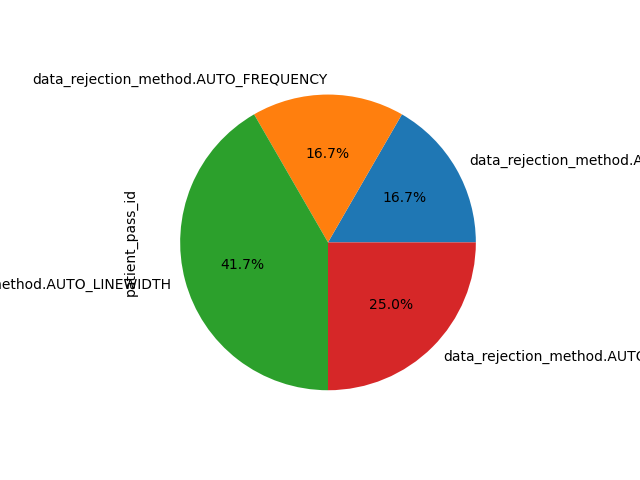

<AxesSubplot:ylabel='patient_pass_id'>

In [55]:
plt.figure()
this_df = df
this_df["rejection_method"] = this_df["rejection_method"].astype(str)
this_df = this_df.loc[this_df["rejection_method"] != "None"]
this_df.groupby("rejection_method")["patient_pass_id"].nunique().plot.pie(autopct="%.1f%%")

### Gain in SNR/LW
#### Compare sc_nodatarej vs. sc_nodatarej_norea

In [56]:
df = df_sc_all_reco.loc[df_sc_all_reco.index.get_level_values("reco_template_name").isin(["sc_nodatarej_norea", "sc_nodatarej"])]
df = df.reset_index().drop_duplicates(["patient_pass_id", "reco_template_name"])

df = df.reset_index().sort_values(by=["data_hash", "reco_template_name"], ascending=False)

df["snr_rel_diff"] = df.groupby(["data_hash"])["snr_final"].pct_change().fillna(0) * 100.0
df["lw_diff"] = df.groupby(["data_hash"])["lw_final"].diff().fillna(0)

print("--- sc_nodatarej vs. sc_nodatarej_norea ---")
print("n = %d" % len(df))
print("* SNR gain (%%) = %.2f" % (df.loc[df["reco_template_name"] == "sc_nodatarej"]["snr_rel_diff"].mean()))
print("* FWHM gain (Hz) = %.2f" % (df.loc[df["reco_template_name"] == "sc_nodatarej"]["lw_diff"].mean()))

df[["data_hash", "reco_template_name", "patient_pass_id", "snr_final", "lw_final", "snr_rel_diff", "lw_diff"]]

--- sc_nodatarej vs. sc_nodatarej_norea ---
n = 40
* SNR gain (%) = 2.00
* FWHM gain (Hz) = -6.35


data_hash  reco_template_name patient_pass_id  \
29  fc8cb0e8f7b3747a10eeabc1cf8ab9fb  sc_nodatarej_norea          329_P1   
9   fc8cb0e8f7b3747a10eeabc1cf8ab9fb        sc_nodatarej          329_P1   
27  f416f6db6cda52195e3b8046fc586ef2  sc_nodatarej_norea          319_P1   
7   f416f6db6cda52195e3b8046fc586ef2        sc_nodatarej          319_P1   
32  ef31f01b58b8279ef0df239b6d15a055  sc_nodatarej_norea          300_P2   
12  ef31f01b58b8279ef0df239b6d15a055        sc_nodatarej          300_P2   
37  e8481853cde6f05d66b1c43d8dd00e40  sc_nodatarej_norea          313_P2   
17  e8481853cde6f05d66b1c43d8dd00e40        sc_nodatarej          313_P2   
38  e2c8b162388ff1d24dca288885b87e4b  sc_nodatarej_norea          314_P2   
18  e2c8b162388ff1d24dca288885b87e4b        sc_nodatarej          314_P2   
28  b9875913db5c0f321922f819401cc02e  sc_nodatarej_norea          328_P1   
8   b9875913db5c0f321922f819401cc02e        sc_nodatarej          328_P1   
31  afb10548c794ebbf8bd304be1f52b0c1  sc_nodatarej_norea          338_P1   
11  afb10548c794ebbf8bd304be1f52b0c1        sc_nodatarej          338_P1   
22  a2b582b37a04bd4efc43138368bc0b96  sc_nodatarej_norea          308_P1   
2   a2b582b37a04bd4efc43138368bc0b96        sc_nodatarej          308_P1   
24  9f8067ea065153da5b3a352d58f6ca23  sc_nodatarej_norea          313_P1   
4   9f8067ea065153da5b3a352d58f6ca23        sc_nodatarej          313_P1   
35  967a1b8dace220e916df680759f31d84  sc_nodatarej_norea          336_P2   
15  967a1b8dace220e916df680759f31d84        sc_nodatarej          336_P2   
36  90d883145e25fe54b74b05c16b56ace1  sc_nodatarej_norea          319_P2   
16  90d883145e25fe54b74b05c16b56ace1        sc_nodatarej          319_P2   
23  7cb024e470b0b2b072436635a19a1c00  sc_nodatarej_norea          311_P1   
3   7cb024e470b0b2b072436635a19a1c00        sc_nodatarej          311_P1   
34  75ae13bc44bf3d55f5be46d4c59df84d  sc_nodatarej_norea          311_P2   
14  75ae13bc44bf3d55f5be46d4c59df84d        sc_nodatarej          311_P2   
33  62f4072c25c940cd1bfcb41a560749e2  sc_nodatarej_norea          349_P1   
13  62f4072c25c940cd1bfcb41a560749e2        sc_nodatarej          349_P1   
26  5f9a42662bfe3586bee57f3ead964778  sc_nodatarej_norea          316_P1   
6   5f9a42662bfe3586bee57f3ead964778        sc_nodatarej          316_P1   
39  45b70edaa2460689b120a7ed10a1f6e1  sc_nodatarej_norea          349_P2   
19  45b70edaa2460689b120a7ed10a1f6e1        sc_nodatarej          349_P2   
20  2fff316122fc89a0b4d1f918f6cd62d8  sc_nodatarej_norea          300_P1   
0   2fff316122fc89a0b4d1f918f6cd62d8        sc_nodatarej          300_P1   
30  2e9c959e58727727c1576108fb6ef2b9  sc_nodatarej_norea          336_P1   
10  2e9c959e58727727c1576108fb6ef2b9        sc_nodatarej          336_P1   
21  1baf6b702f39fefb5ad9e44179057ef7  sc_nodatarej_norea          307_P1   
1   1baf6b702f39fefb5ad9e44179057ef7        sc_nodatarej          307_P1   
25  0a58f85af8c32d06cbbca74391447ad2  sc_nodatarej_norea          314_P1   
5   0a58f85af8c32d06cbbca74391447ad2        sc_nodatarej          314_P1   

    snr_final   lw_final  snr_rel_diff    lw_diff  
29  14.296147  20.751953      0.000000   0.000000  
9   15.813580  15.869141     10.614285  -4.882813  
27  14.554223  10.986328      0.000000   0.000000  
7   14.761143   9.765625      1.421715  -1.220703  
32   5.995440  22.583008      0.000000   0.000000  
12   4.636314  13.427734    -22.669328  -9.155273  
37   7.825510  17.089844      0.000000   0.000000  
17   6.690841  14.648438    -14.499622  -2.441406  
38  19.127877  12.207031      0.000000   0.000000  
18  15.769126  10.375977    -17.559451  -1.831055  
28  11.103476  14.038086      0.000000   0.000000  
8   10.896074  10.986328     -1.867906  -3.051758  
31  14.048240  15.869141      0.000000   0.000000  
11  17.951592  12.207031     27.785345  -3.662109  
22   6.874873  33.569336      0.000000   0.000000  
2    7.304202  14.648438      6.244911 -18.920898  
24   9.255101  24.414062  

#### Compare sc vs. sc_nodatarej_norea

In [57]:
df = df_sc_all_reco.loc[df_sc_all_reco.index.get_level_values("reco_template_name").isin(["sc_nodatarej_norea", "sc"])]
df = df.reset_index().drop_duplicates(["patient_pass_id", "reco_template_name"])

df = df.reset_index().sort_values(by=["data_hash", "reco_template_name"], ascending=False)

df["snr_rel_diff"] = df.groupby(["data_hash"])["snr_final"].pct_change().fillna(0) * 100.0
df["lw_diff"] = df.groupby(["data_hash"])["lw_final"].diff().fillna(0)

print("--- sc vs. sc_nodatarej_norea ---")
print("n = %d" % len(df))
print("* SNR gain (%%) = %.2f" % (df.loc[df["reco_template_name"] == "sc"]["snr_rel_diff"].mean()))
print("* FWHM gain (Hz) = %.2f" % (df.loc[df["reco_template_name"] == "sc"]["lw_diff"].mean()))

df[["data_hash", "reco_template_name", "patient_pass_id", "snr_final", "lw_final", "snr_rel_diff", "lw_diff"]]

--- sc vs. sc_nodatarej_norea ---
n = 40
* SNR gain (%) = -2.10
* FWHM gain (Hz) = -6.47


data_hash  reco_template_name patient_pass_id  \
29  fc8cb0e8f7b3747a10eeabc1cf8ab9fb  sc_nodatarej_norea          329_P1   
9   fc8cb0e8f7b3747a10eeabc1cf8ab9fb                  sc          329_P1   
27  f416f6db6cda52195e3b8046fc586ef2  sc_nodatarej_norea          319_P1   
7   f416f6db6cda52195e3b8046fc586ef2                  sc          319_P1   
32  ef31f01b58b8279ef0df239b6d15a055  sc_nodatarej_norea          300_P2   
12  ef31f01b58b8279ef0df239b6d15a055                  sc          300_P2   
37  e8481853cde6f05d66b1c43d8dd00e40  sc_nodatarej_norea          313_P2   
17  e8481853cde6f05d66b1c43d8dd00e40                  sc          313_P2   
38  e2c8b162388ff1d24dca288885b87e4b  sc_nodatarej_norea          314_P2   
18  e2c8b162388ff1d24dca288885b87e4b                  sc          314_P2   
28  b9875913db5c0f321922f819401cc02e  sc_nodatarej_norea          328_P1   
8   b9875913db5c0f321922f819401cc02e                  sc          328_P1   
31  afb10548c794ebbf8bd304be1f52b0c1  sc_nodatarej_norea          338_P1   
11  afb10548c794ebbf8bd304be1f52b0c1                  sc          338_P1   
22  a2b582b37a04bd4efc43138368bc0b96  sc_nodatarej_norea          308_P1   
2   a2b582b37a04bd4efc43138368bc0b96                  sc          308_P1   
24  9f8067ea065153da5b3a352d58f6ca23  sc_nodatarej_norea          313_P1   
4   9f8067ea065153da5b3a352d58f6ca23                  sc          313_P1   
35  967a1b8dace220e916df680759f31d84  sc_nodatarej_norea          336_P2   
15  967a1b8dace220e916df680759f31d84                  sc          336_P2   
36  90d883145e25fe54b74b05c16b56ace1  sc_nodatarej_norea          319_P2   
16  90d883145e25fe54b74b05c16b56ace1                  sc          319_P2   
23  7cb024e470b0b2b072436635a19a1c00  sc_nodatarej_norea          311_P1   
3   7cb024e470b0b2b072436635a19a1c00                  sc          311_P1   
34  75ae13bc44bf3d55f5be46d4c59df84d  sc_nodatarej_norea          311_P2   
14  75ae13bc44bf3d55f5be46d4c59df84d                  sc          311_P2   
33  62f4072c25c940cd1bfcb41a560749e2  sc_nodatarej_norea          349_P1   
13  62f4072c25c940cd1bfcb41a560749e2                  sc          349_P1   
26  5f9a42662bfe3586bee57f3ead964778  sc_nodatarej_norea          316_P1   
6   5f9a42662bfe3586bee57f3ead964778                  sc          316_P1   
39  45b70edaa2460689b120a7ed10a1f6e1  sc_nodatarej_norea          349_P2   
19  45b70edaa2460689b120a7ed10a1f6e1                  sc          349_P2   
20  2fff316122fc89a0b4d1f918f6cd62d8  sc_nodatarej_norea          300_P1   
0   2fff316122fc89a0b4d1f918f6cd62d8                  sc          300_P1   
30  2e9c959e58727727c1576108fb6ef2b9  sc_nodatarej_norea          336_P1   
10  2e9c959e58727727c1576108fb6ef2b9                  sc          336_P1   
21  1baf6b702f39fefb5ad9e44179057ef7  sc_nodatarej_norea          307_P1   
1   1baf6b702f39fefb5ad9e44179057ef7                  sc          307_P1   
25  0a58f85af8c32d06cbbca74391447ad2  sc_nodatarej_norea          314_P1   
5   0a58f85af8c32d06cbbca74391447ad2                  sc          314_P1   

    snr_final   lw_final  snr_rel_diff    lw_diff  
29  14.296147  20.751953      0.000000   0.000000  
9   15.886397  16.479492     11.123627  -4.272461  
27  14.554223  10.986328      0.000000   0.000000  
7   13.698833   9.765625     -5.877267  -1.220703  
32   5.995440  22.583008      0.000000   0.000000  
12   4.636314  13.427734    -22.669328  -9.155273  
37   7.825510  17.089844      0.000000   0.000000  
17   6.175400  14.038086    -21.086292  -3.051758  
38  19.127877  12.207031      0.000000   0.000000  
18  15.769126  10.375977    -17.559451  -1.831055  
28  11.103476  14.038086      0.000000   0.000000  
8   10.493958  10.986328     -5.489441  -3.051758  
31  14.048240  15.869141      0.000000   0.000000  
11  17.951592  12.207031     27.785345  -3.662109  
22   6.874873  33.569336      0.000000   0.000000  
2    7.121938  15.258789      3.593743 -18.310547  
24   9.255101  24.414062  

* Frequency realignment is really benefic: +2%SNR but surtout -6Hz LW
* Data discardment performance is really not observable in terms of SNR/LW: just a little better LW but actually a loss in SNR...

# Investigating rejected datasets:

## [FIG] Normalized SNR vs. BMI

<IPython.core.display.Javascript object>


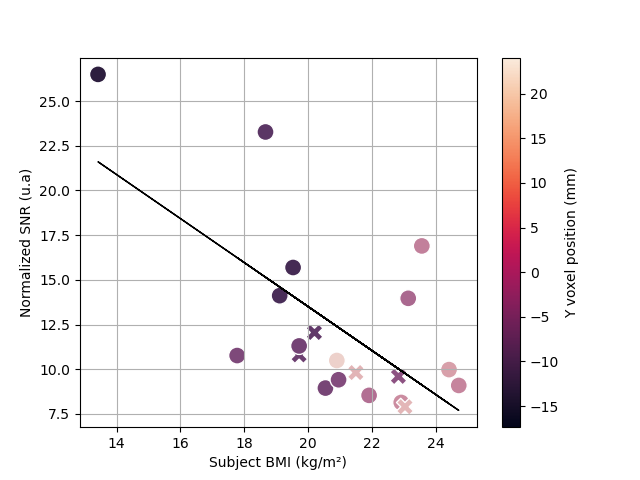

R = -0.65


In [58]:
df = df_sc_all_reco.loc[(df_sc_all_reco.index.get_level_values("reco_template_name") == "sc")].drop_duplicates("patient_pass_id")

this_df = df
this_df = this_df.rename(columns = {'snr_final_norm':'Normalized SNR (u.a)'})
this_df = this_df.rename(columns = {'patient_bmi':'Subject BMI'})
x = this_df["Subject BMI"]
y = this_df["Normalized SNR (u.a)"]

plt.figure()
g = sns.scatterplot(x="Subject BMI", y="Normalized SNR (u.a)",
                hue="voxel_pos_y_mm", cmap=cm,
                style="included", style_order=[True, False],
                s=150, data=this_df)

plt.grid(True)

norm = plt.Normalize(this_df['voxel_pos_y_mm'].min(), this_df['voxel_pos_y_mm'].max())
sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
g.get_legend().remove()
cb = g.figure.colorbar(sm)
cb.set_label(label='Y voxel position (mm)')

plt.show()

m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x+b, color='k', linewidth=1)

print("R = %.2f" % x.corr(y))

plt.xlabel("Subject BMI (kg/m²)")

plt.savefig("./notebooks/figs/fig_snr_bmi.svg")

## 5ppm artefact?

<IPython.core.display.Javascript object>


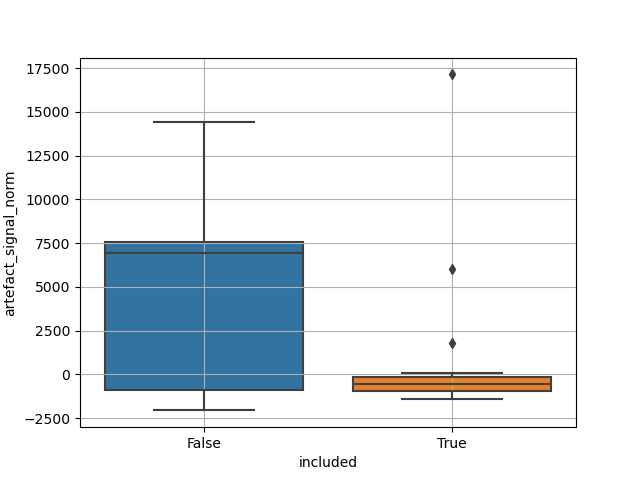

In [59]:
plt.figure()
g = sns.boxplot(x="included", y="artefact_signal_norm", data=df)
plt.grid('on')

Clearly, rejected datasets show a stronger 5ppm artefact level in average... It is one of the reasons yes. 

# [FIG] Spectra gallery

<IPython.core.display.Javascript object>


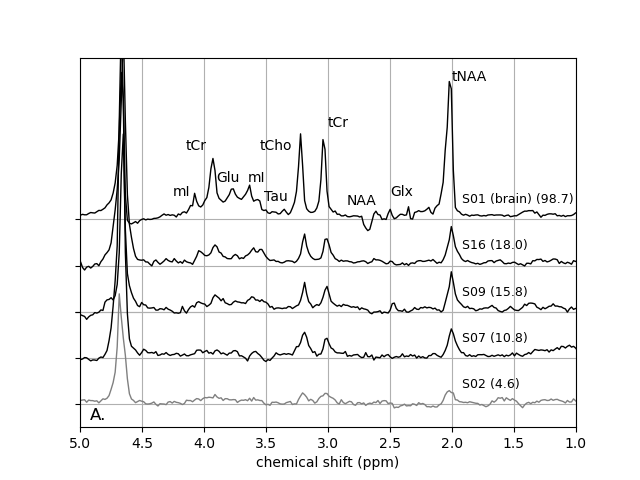

/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)


Text(3.9, 48000, 'Glu')

In [60]:
this_df = df_sc_all_reco.loc[(df_sc_all_reco.index.get_level_values("reco_template_name") == "sc") &
                        (df_sc_all_reco["fit_tool_name"] == "pastis") &
                        (df_sc_all_reco["fit_ws_metabolites_len"] == 15) &
                        (df_sc_all_reco["fit_ws_sequence_str"] == "none")].drop_duplicates("patient_pass_id")

this_df = this_df.loc[this_df["patient_pass_id"].isin(["338_P1", "314_P2", "311_P1", "300_P2"])]

# add best brain dataset
this_df_brain = df_brain.loc[(df_brain.index.get_level_values("reco_template_name") == "brain") &
                        (df_brain["fit_tool_name"] == "pastis") &
                        (df_brain["fit_ws_metabolites_len"] == 15) &
                        (df_brain["fit_ws_sequence_str"] == "none")].drop_duplicates("patient_pass_id")

this_df_brain = this_df_brain.loc[ (this_df_brain["snr_final"] == this_df_brain["snr_final"].max())]

# concat
this_df = pd.concat([this_df, this_df_brain])
this_df = this_df.sort_values(by="snr_final")

# add SNR to the label
this_df["spectra_gllr_lbl"] = ["%s (%.1f)" % (s1.replace(" (P1)", "").replace(" (P2)", ""), s2) for (s1, s2) in zip(this_df["patient_pass_id_pretty"], this_df["snr_final"])]

k = 0
label_x = 1.9 #ppm
for this_index, this_row in this_df.iterrows():
    s = this_row["data_obj"]
    
    s.set_display_offset(10000.0 * k)
    fig = s.display_spectrum_1d(1000)
    
    # add some x/y for annotation
    this_df.at[this_index, "spectrum_label_x"] = label_x
    this_df.at[this_index, "spectrum_label_y"] = 10000.0 * k
    
    # line color
    if(this_row["included"]):
        fig.axes[0].get_lines()[-1].set_color('black')
    else:
        fig.axes[0].get_lines()[-1].set_color('grey')
        
    # iterate
    k += 1

add_labels("spectrum_label_x", "spectrum_label_y", "spectra_gllr_lbl", this_df, plt.gca(),  9, 0, 3500)

ax = fig.axes
ax[0].set(yticklabels=[])
ax[0].get_legend().remove()
plt.ylabel("")
  
plt.xlim([5, 1])
yts = plt.yticks()
plt.yticks(yts[0][0:-4])
plt.ylim([-5000, 75000])

# add metabolites labels
yo = 10000
plt.text(2, 60000 + yo, "tNAA")
plt.text(2.5, 35000 + yo, "Glx")
plt.text(2.85, 33000 + yo, "NAA")
plt.text(3, 50000 + yo, "tCr")
plt.text(3.55, 45000 + yo, "tCho")
plt.text(3.52, 34000 + yo, "Tau")
plt.text(4.15, 45000 + yo, "tCr")
plt.text(4.25, 35000 + yo, "mI")
plt.text(3.65, 38000 + yo, "mI")
plt.text(3.9, 38000 + yo, "Glu")


<IPython.core.display.Javascript object>


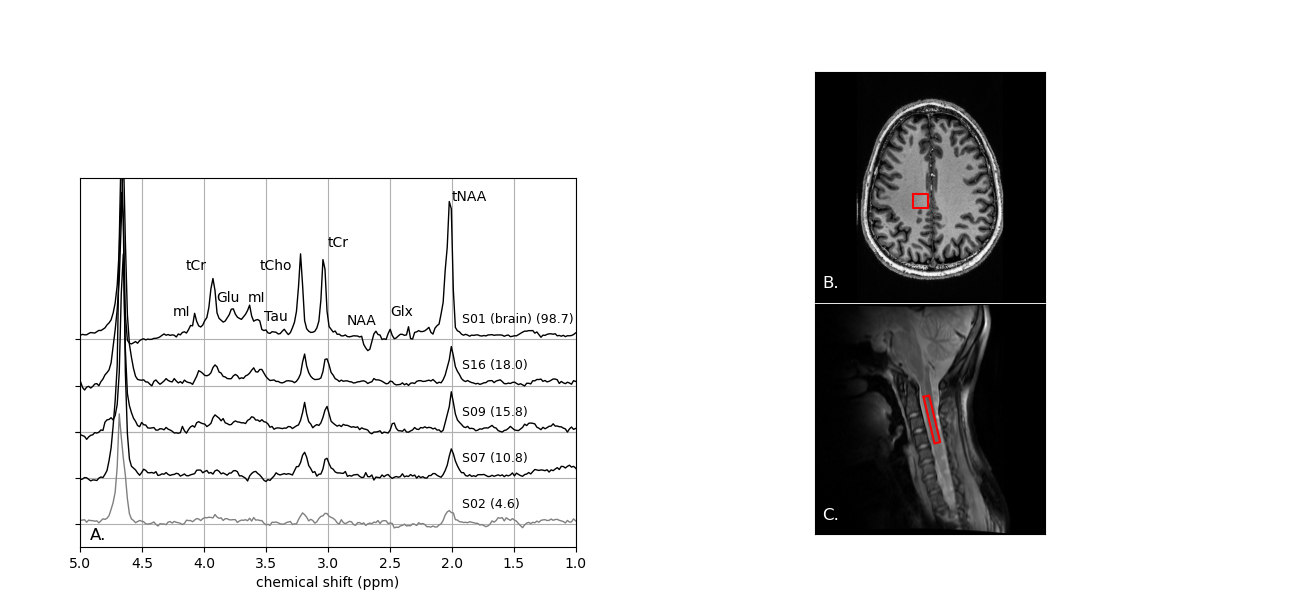

314_P2
S09
5.99999999977624
5.99999738454667
19.999991281076372


Text(7.18, 240.14, 'C.')

In [61]:
# get previous fig and paste it here
new_fig = plt.figure(figsize=(13,6))
new_fig.subplots_adjust(wspace=0.01, hspace=0.01)

fig = plt.figure(1000)
ax_previous_fig = fig.axes[0]

ax_previous_fig.figure=new_fig
new_fig.axes.append(ax_previous_fig)
new_fig.add_axes(ax_previous_fig)

dummy = new_fig.add_subplot(1,3,(1,2))
ax_previous_fig.set_position(dummy.get_position())
dummy.remove()

xlim = ax_previous_fig.get_xlim()
ylim = ax_previous_fig.get_ylim()
ax_previous_fig.text(xlim[0] - (xlim[0]-xlim[1])*0.02, 
                     ylim[0] + (ylim[1]-ylim[0])*0.02, 
                    "A.",
                    fontsize=12)

# add a nice anatomy for spinal cord
t2w = suspect.image.load_dicom_volume("/home/tangir/crmbm/acq/314-yt-p2-moelle/20200625/01_0005_t2-tse-sag-2d-10sl-p2-trig-s4-nd/original-primary-m-norm-nd_e01_0001.dcm")

ind_patient = 2
this_df_nice_subject = this_df.loc[this_df["patient_pass_id"] == "314_P2"]
pcg = this_df_nice_subject["data_obj"].iloc[0]
print(this_df_nice_subject["patient_pass_id"].iloc[0])
print(this_df_nice_subject["patient_id_pretty"].iloc[0])
print(this_df_nice_subject["voxel_size_x_mm"].iloc[0])
print(this_df_nice_subject["voxel_size_y_mm"].iloc[0])
print(this_df_nice_subject["voxel_size_z_mm"].iloc[0])

pcg_centre = pcg.to_scanner(0, 0, 0)
pcg_centre_index = t2w.from_scanner(*pcg_centre).round().astype(int)

corner_coords_pcg = [[0, -0.4, -1],
                     [0, -0.4, 1],
                     [0, 0.4, 1],
                     [0, 0.4, -1],
                     [0, -0.4, -1]]
corner_coords = np.array([t2w.from_scanner(*pcg.to_scanner(*coord)) for coord in corner_coords_pcg])


ax = new_fig.add_subplot(2,2,4)
ax.imshow(t2w[pcg_centre_index[2]], cmap=plt.cm.gray)
ax.plot(corner_coords[:, 0], corner_coords[:, 1], 'red')
ax.set_xticks([])
ax.set_yticks([])
new_fig.subplots_adjust(wspace=0.1, hspace=0.01)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.text(xlim[0] - (xlim[0]-xlim[1])*0.03, 
        ylim[0] + (ylim[1]-ylim[0])*0.06, 
        "C.",
        fontsize=12, color="white")

In [62]:
# add a nice anatomy for brain

t1w = suspect.image.load_dicom_volume("/home/tangir/crmbm/acq/347-re-p1-moelle/20200123/01_0009_mp2rage-wip900-sag-0-6iso-p3-uni-den/original-primary-m-nd-uni_e01_0001.dcm")

pcg = reco.MRSData2("/home/tangir/crmbm/acq_twix/347-re-p1-moelle/meas_MID228_slaser_R_N=10_2_longTE_SNR+++_FID50587.dat")

pcg_centre = pcg.to_scanner(0, 0, 0)
pcg_centre_index_brain = t1w.from_scanner(*pcg_centre).round().astype(int)

corner_coords_pcg = [[0, -0.75, -0.75],
                     [0, -0.75,  0.75],
                     [0, 0.75, 0.75],
                     [0, 0.75, -0.75],
                     [0, -0.75, -0.75]]
corner_coords = np.array([t1w.from_scanner(*pcg.to_scanner(*coord)) for coord in corner_coords_pcg])

ax = new_fig.add_subplot(2,2,2)
img_tmp = t1w[:, pcg_centre_index_brain[1], :].T
img_tmp = np.concatenate((np.zeros([402, int((402-256)/2)]), img_tmp), axis=1)
img_tmp = np.concatenate((img_tmp, np.zeros([402, int((402-256)/2)])), axis=1)

ax.imshow(img_tmp, cmap=plt.cm.gray)
ax.plot(corner_coords[:, 1]+int((402-256)/2), corner_coords[:, 0], 'red')
ax.set_xticks([])
ax.set_yticks([])
new_fig.subplots_adjust(wspace=0.1, hspace=0.01)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.text(xlim[0] - (xlim[0]-xlim[1])*0.03, 
        ylim[0] + (ylim[1]-ylim[0])*0.06, 
        "B.",
        fontsize=12, color="white")


new_fig.savefig("./notebooks/figs/fig_spectra.svg")

(INFO)  reco.py.__new__: reading data file...
(INFO)  reco.py.__new__: /home/tangir/crmbm/acq_twix/347-re-p1-moelle/meas_MID228_slaser_R_N=10_2_longTE_SNR+++_FID50587.dat
/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/suspect/io/twix.py:115: FutureWarning: Possible nested set at position 48
  match = re.findall(rgx, header_string)
/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/suspect/io/twix.py:115: FutureWarning: Possible nested set at position 34
  match = re.findall(rgx, header_string)
/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/suspect/io/twix.py:115: FutureWarning: Possible nested set at position 39
  match = re.findall(rgx, header_string)
/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/suspect/io/twix.py:115: FutureWarning: Possible nested set at position 37
  match = re.findall(rgx, header_string)
/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/suspect/io/twix.py:115: FutureWarning: Possible nested set at po

# [FIG] Fit example
with the best fit we have :)

data_hash                         reco_template_name  fit_ws_fit_hash                 
e2c8b162388ff1d24dca288885b87e4b  sc                  4292ee4ac988ef2077b193fc794ec509    S09 (P2)
Name: patient_pass_id_pretty_after_filter, dtype: object
removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  metabolite_basis_set.__init__: initializing metabolite database...
(INFO)  metabolite_basis_set._read_xls_file: reading metabolite basis set from XLS file...
(INFO)  mrs_seq_press.initialize: initializing sequence using pyGAMMA...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [Ala/Ala]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [Asc/Asc]...


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [Asp/Asp]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [Cho/Cho_CH3]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [Cho/Cho_CH2]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [Cho_CH3/Cho_CH3]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [Cr_CH3/Cr_CH3]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [Cr_CH2/Cr_CH2]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [EA/EA]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [Eth/Eth]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [GABA/GABA]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating M

removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [Glc/Glc_b]...


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [Gln/Gln]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [Glu/Glu]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [Gly/Glyci]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [GPC/GPC_Gp]...


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [GPC/GPC_PC_CH2]...


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [GPC/GPC_PC_CH3]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [Gsh/Gsh_Gly]...


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [Gsh/Gsh_Cys]...


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [Gsh/Gsh_Glu]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [Lac/Lac]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [mI/mI]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [NAA/NAA_CH3]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [NAA/NAA_CH2]...


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [NAA_CH3/NAA_CH3]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [NAAG/NAAG_Ace]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [NAAG/NAAG_Asp]...


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [NAAG/NAAG_Glu]...


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [PCr/PCr]...


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [PC/PC_CH2]...


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [PC/PC_CH3]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [PE/PE]...


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [sI/sI]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [Tau/Tau]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [Water/Water]...


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [LipA/LipA]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [LipB/LipB]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [LipC/LipC]...


<IPython.core.display.Javascript object>


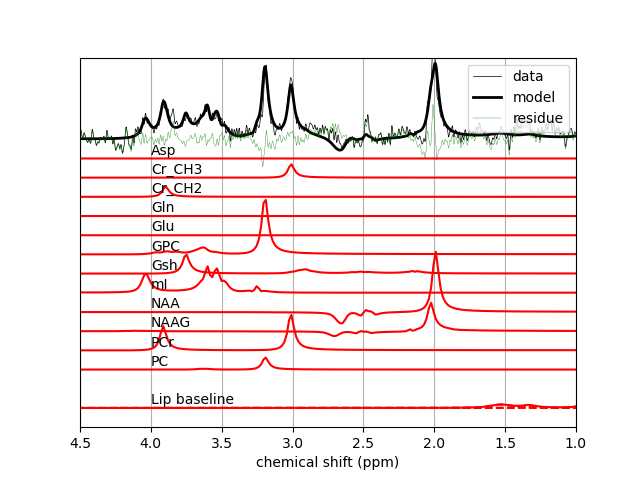

314_P2 R(t/f) = 0.73/0.72 FQN = 1.0


In [63]:
import mrs.fit as fit

this_df = df_sc_all_reco.loc[(df_sc_all_reco.index.get_level_values("reco_template_name") == "sc") &
                        (df_sc_all_reco["fit_tool_name"] == "pastis") &
                        (df_sc_all_reco["fit_ws_metabolites_len"] == 15) &
                        (df_sc_all_reco["fit_ws_sequence_str"] == "none")].drop_duplicates("patient_pass_id")

# preview
this_df = this_df.sort_values("fit_ws_optim_results_rsq_f", ascending=False).drop_duplicates("patient_pass_id")
this_df = this_df.head(5)

# best
this_df = this_df.loc[this_df["patient_pass_id"].isin(["314_P2"])]
print(this_df["patient_pass_id_pretty_after_filter"])

for this_index, this_row in this_df.iterrows():
    s_data = this_row["data_obj"]
    s_data = s_data.correct_peak_removal_1d(8, [4.5, 6], False)

    # fit params
    p_fit = this_row["final_fit_params_arr"]

    # PRESS seq
    seq = sim.mrs_seq_press(s_data.sequence.te, s_data.sequence.tr, s_data.sequence.na, 
                            s_data.sequence.ds, s_data.sequence.nuclei, 
                            s_data.sequence.npts, s_data.sequence.voxel_size, 
                            s_data.sequence.fs, s_data.sequence.f0)
    
    seq.bandpass_filter_range_ppm = [0, 4.2]

    seq.initialize()
    fig = plt.figure()
    ax = fig.subplots()
    fit.disp_fit(ax, s_data, p_fit, seq, True, True, None, False, [1, 4.5])
    print(this_row["patient_pass_id"] + " R(t/f) = %.2f/%.2f FQN = %.1f" % (this_row["fit_ws_optim_results_rsq_t"],
                                                                            this_row["fit_ws_optim_results_rsq_f"],
                                                                            this_row["fit_ws_optim_results_fqn"]))

fig = plt.gcf()
fig.savefig("./notebooks/figs/fig_fit.svg")

# P1 quantification results
## Ratio STD: choosing best modelization sequence

/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>


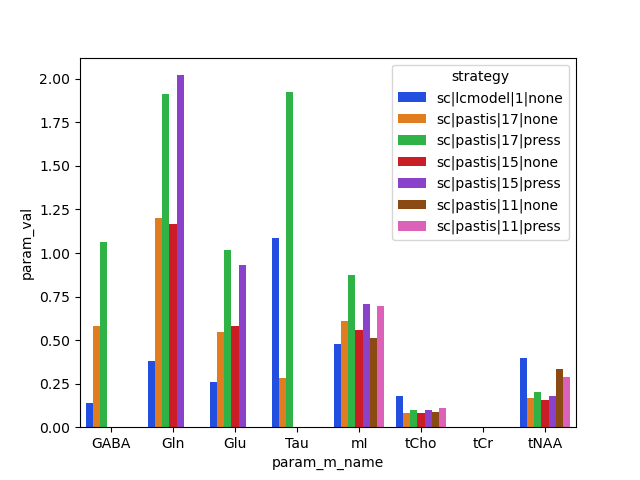

In [64]:
df = df_sc_all_reco.loc[(df_sc_all_reco["included"]) & 
                        (df_sc_all_reco.index.get_level_values("reco_template_name") == "sc") & 
                        (df_sc_all_reco["pass"] == 1)]

# watch ratios
this_df = df.loc[(df["param_p_type"] == "fit_ws_params_fit_t2cor_ratio_cm") &
                 (df["param_val_err"] == "val") &  
                 (df["param_m_name"].isin(["tCr", "tCho", "tNAA", "mI", "Tau", "Gln", "Glu", "GABA"]))]

this_df["param_val"] = this_df["param_val"].replace([np.inf, -np.inf], np.nan)
this_df = this_df[this_df["param_val"].notna()]
this_df = this_df.groupby(["param_m_name", "strategy"])["param_val"].std()

plt.figure()
g = sns.barplot(x="param_m_name", 
                y="param_val",
                hue="strategy",
                palette = "bright",
                data=this_df.reset_index())


Clearly, the use of PRESS instead of sLASER for the modelization increases the variability of the results. Let's stick to sLASER ("none").

## Ratio STD & CRB: choosing number of metabolites

/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


<IPython.core.display.Javascript object>


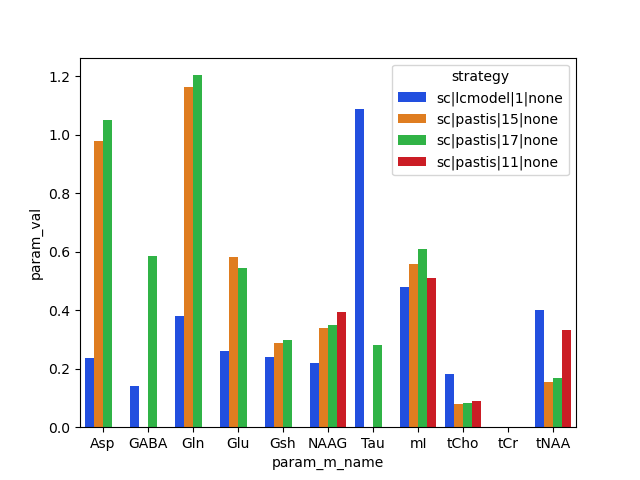

In [65]:
df = df_sc_all_reco.loc[(df_sc_all_reco["included"]) & 
                        (df_sc_all_reco.index.get_level_values("reco_template_name") == "sc") &
                        (df_sc_all_reco["fit_ws_sequence_str"] == "none") & 
                        (df_sc_all_reco["pass"] == 1)]

# watch ratios
this_df = df.loc[(df["param_p_type"] == "fit_ws_params_fit_t2cor_ratio_cm") &
                 (df["param_val_err"] == "val") &  
                 (df["param_m_name"].isin(["tCr", "tCho", "tNAA", "mI", "Tau", "Gln", "Glu", "GABA", "NAAG", "Asp", "Gsh"]))]

this_df["param_val"] = this_df["param_val"].replace([np.inf, -np.inf], np.nan)
this_df = this_df[this_df["param_val"].notna()]
this_df = this_df.groupby(["param_m_name", "strategy"])["param_val"].std()

plt.figure()
g = sns.barplot(x="param_m_name", 
                y="param_val",
                hue="strategy",
                palette = "bright",
                data=this_df.reset_index())


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


<IPython.core.display.Javascript object>


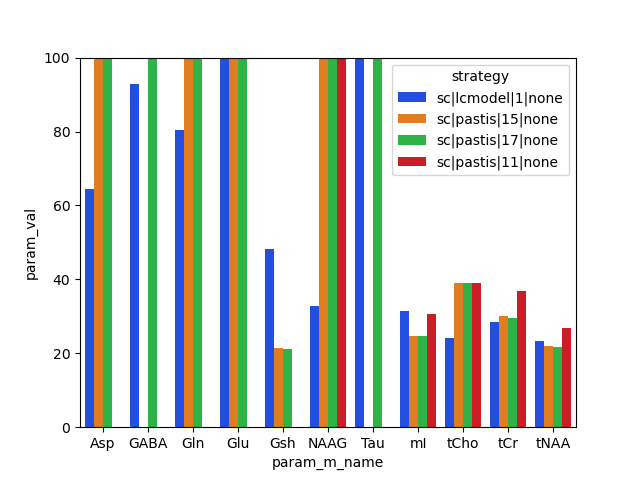

(0.0, 100.0)

In [66]:
df = df_sc_all_reco.loc[(df_sc_all_reco["included"]) & 
                        (df_sc_all_reco.index.get_level_values("reco_template_name") == "sc") &
                        (df_sc_all_reco["fit_ws_sequence_str"] == "none") & 
                        (df_sc_all_reco["pass"] == 1)]

# watch ratios
this_df = df.loc[(df["param_p_type"] == "fit_ws_params_fit_t2cor_ratio_cm") &
                 (df["param_val_err"] == "err_prct") &  
                 (df["param_m_name"].isin(["tCr", "tCho", "tNAA", "mI", "Tau", "Gln", "Glu", "GABA", "NAAG", "Asp", "Gsh"]))]

this_df["param_val"] = this_df["param_val"].replace([np.inf, -np.inf], np.nan)
this_df = this_df[this_df["param_val"].notna()]
this_df = this_df.groupby(["param_m_name", "strategy"])["param_val"].mean()

plt.figure()
g = sns.barplot(x="param_m_name", 
                y="param_val",
                hue="strategy",
                palette = "bright",
                data=this_df.reset_index())

plt.ylim([0, 100])

15 metabolites gives the lowest STDs and CRBs !

## Automatic adjustment of SNR/LW/FQN thresholds

In [67]:
threshold_snr_final_list = [5, 6, 7, 8, 9, 10]
threshold_lw_final_list = [15, 20, 25]
threshold_fqn_final_list = [1.25, 1.5, 1.8, 2]

ref_reco_template_name_sc = "sc"
ref_fit_tool_name = "pastis"
ref_fit_ws_metabolites_len = 15
ref_fit_ws_sequence_str = "none"

this_df_reslist = []
k = 0
for this_snr in threshold_snr_final_list:
    for this_lw in threshold_lw_final_list:
        for this_fqn in threshold_fqn_final_list:

            df_sc_all_reco = filter_by_SNR_LW_FQN(df_sc_all_reco, 
                                                    this_snr,
                                                    this_lw,
                                                    this_fqn,
                                                    ref_reco_template_name_sc, 
                                                    ref_fit_tool_name, 
                                                    ref_fit_ws_metabolites_len, 
                                                    ref_fit_ws_sequence_str)

            df = df_sc_all_reco.loc[(df_sc_all_reco["included"]) & 
                                    (df_sc_all_reco.index.get_level_values("reco_template_name") == "sc") &
                                    (df_sc_all_reco["fit_ws_sequence_str"] == "none") &
                                    (df_sc_all_reco["fit_ws_metabolites_len"] == 15) &
                                    (df_sc_all_reco["fit_tool_name"] == "pastis") &
                                    (df_sc_all_reco["pass"] == 1)]

            # watch ratios
            this_df = df.loc[(df["param_p_type"] == "fit_ws_params_fit_t2cor_ratio_cm") &
                             (df["param_val_err"] == "val") &  
                             (df["param_m_name"].isin(["tCr", "tCho", "tNAA", "mI", "Tau", "Gln", "Glu", "GABA", "NAAG"]))]

            this_df["param_val"] = this_df["param_val"].replace([np.inf, -np.inf], np.nan)
            this_df = this_df[this_df["param_val"].notna()].reset_index()

            this_df = this_df.loc[(this_df["param_m_name"].isin(["tCho", "tNAA", "mI"]))]
            this_df_res = this_df.groupby(["param_m_name"])["param_val"].agg(["mean", "median", "std"])
            this_df_res["snr_threshold"] = this_snr
            this_df_res["lw_threshold"] = this_lw
            this_df_res["fqn_threshold"] = this_fqn
            this_df_reslist.append(this_df_res)

            k += 1
            print("%.2f%% done" % (100 * k / (len(threshold_snr_final_list) * len(threshold_lw_final_list) * len(threshold_fqn_final_list))))


found 2 orphan P2 patients. Fixing them...
['313', '349']
n (P1) = 7 / 13 (53.85% included)
n (P2) = 3 / 7
1.39% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 1 orphan P2 patients. Fixing them...
['313']
n (P1) = 8 / 13 (61.54% included)
n (P2) = 4 / 7
2.78% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 1 orphan P2 patients. Fixing them...
['313']
n (P1) = 9 / 13 (69.23% included)
n (P2) = 4 / 7
4.17% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 1 orphan P2 patients. Fixing them...
['313']
n (P1) = 10 / 13 (76.92% included)
n (P2) = 4 / 7
5.56% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 2 orphan P2 patients. Fixing them...
['319', '349']
n (P1) = 9 / 13 (69.23% included)
n (P2) = 4 / 7
6.94% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 1 orphan P2 patients. Fixing them...
['319']
n (P1) = 11 / 13 (84.62% included)
n (P2) = 5 / 7
8.33% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 0 orphan P2 patients. Fixing them...
[]
n (P1) = 11 / 13 (84.62% included)
n (P2) = 6 / 7
9.72% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 0 orphan P2 patients. Fixing them...
[]
n (P1) = 12 / 13 (92.31% included)
n (P2) = 6 / 7
11.11% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 2 orphan P2 patients. Fixing them...
['319', '349']
n (P1) = 9 / 13 (69.23% included)
n (P2) = 4 / 7
12.50% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 1 orphan P2 patients. Fixing them...
['319']
n (P1) = 12 / 13 (92.31% included)
n (P2) = 5 / 7
13.89% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 0 orphan P2 patients. Fixing them...
[]
n (P1) = 12 / 13 (92.31% included)
n (P2) = 6 / 7
15.28% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 0 orphan P2 patients. Fixing them...
[]
n (P1) = 13 / 13 (100.00% included)
n (P2) = 6 / 7
16.67% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 3 orphan P2 patients. Fixing them...
['336', '313', '349']
n (P1) = 7 / 13 (53.85% included)
n (P2) = 2 / 7
18.06% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 3 orphan P2 patients. Fixing them...
['336', '313', '349']
n (P1) = 8 / 13 (61.54% included)
n (P2) = 2 / 7
19.44% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 3 orphan P2 patients. Fixing them...
['336', '313', '349']
n (P1) = 9 / 13 (69.23% included)
n (P2) = 2 / 7
20.83% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 3 orphan P2 patients. Fixing them...
['336', '313', '349']
n (P1) = 10 / 13 (76.92% included)
n (P2) = 2 / 7
22.22% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 3 orphan P2 patients. Fixing them...
['336', '319', '349']
n (P1) = 9 / 13 (69.23% included)
n (P2) = 3 / 7
23.61% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 3 orphan P2 patients. Fixing them...
['336', '319', '349']
n (P1) = 11 / 13 (84.62% included)
n (P2) = 3 / 7
25.00% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 2 orphan P2 patients. Fixing them...
['336', '349']
n (P1) = 11 / 13 (84.62% included)
n (P2) = 4 / 7
26.39% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 2 orphan P2 patients. Fixing them...
['336', '349']
n (P1) = 12 / 13 (92.31% included)
n (P2) = 4 / 7
27.78% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 3 orphan P2 patients. Fixing them...
['336', '319', '349']
n (P1) = 9 / 13 (69.23% included)
n (P2) = 3 / 7
29.17% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 3 orphan P2 patients. Fixing them...
['336', '319', '349']
n (P1) = 12 / 13 (92.31% included)
n (P2) = 3 / 7
30.56% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 2 orphan P2 patients. Fixing them...
['336', '349']
n (P1) = 12 / 13 (92.31% included)
n (P2) = 4 / 7
31.94% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 2 orphan P2 patients. Fixing them...
['336', '349']
n (P1) = 13 / 13 (100.00% included)
n (P2) = 4 / 7
33.33% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 1 orphan P2 patients. Fixing them...
['336']
n (P1) = 5 / 13 (38.46% included)
n (P2) = 2 / 7
34.72% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 1 orphan P2 patients. Fixing them...
['336']
n (P1) = 6 / 13 (46.15% included)
n (P2) = 2 / 7
36.11% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 1 orphan P2 patients. Fixing them...
['336']
n (P1) = 7 / 13 (53.85% included)
n (P2) = 2 / 7
37.50% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 1 orphan P2 patients. Fixing them...
['336']
n (P1) = 7 / 13 (53.85% included)
n (P2) = 2 / 7
38.89% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 2 orphan P2 patients. Fixing them...
['336', '319']
n (P1) = 8 / 13 (61.54% included)
n (P2) = 2 / 7
40.28% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 2 orphan P2 patients. Fixing them...
['336', '319']
n (P1) = 10 / 13 (76.92% included)
n (P2) = 2 / 7
41.67% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 1 orphan P2 patients. Fixing them...
['336']
n (P1) = 10 / 13 (76.92% included)
n (P2) = 3 / 7
43.06% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 1 orphan P2 patients. Fixing them...
['336']
n (P1) = 10 / 13 (76.92% included)
n (P2) = 3 / 7
44.44% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 2 orphan P2 patients. Fixing them...
['336', '319']
n (P1) = 8 / 13 (61.54% included)
n (P2) = 2 / 7
45.83% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 2 orphan P2 patients. Fixing them...
['336', '319']
n (P1) = 11 / 13 (84.62% included)
n (P2) = 2 / 7
47.22% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 1 orphan P2 patients. Fixing them...
['336']
n (P1) = 11 / 13 (84.62% included)
n (P2) = 3 / 7
48.61% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 1 orphan P2 patients. Fixing them...
['336']
n (P1) = 11 / 13 (84.62% included)
n (P2) = 3 / 7
50.00% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 0 orphan P2 patients. Fixing them...
[]
n (P1) = 4 / 13 (30.77% included)
n (P2) = 2 / 7
51.39% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 0 orphan P2 patients. Fixing them...
[]
n (P1) = 5 / 13 (38.46% included)
n (P2) = 2 / 7
52.78% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 0 orphan P2 patients. Fixing them...
[]
n (P1) = 6 / 13 (46.15% included)
n (P2) = 2 / 7
54.17% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 0 orphan P2 patients. Fixing them...
[]
n (P1) = 6 / 13 (46.15% included)
n (P2) = 2 / 7
55.56% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 1 orphan P2 patients. Fixing them...
['319']
n (P1) = 6 / 13 (46.15% included)
n (P2) = 2 / 7
56.94% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 1 orphan P2 patients. Fixing them...
['319']
n (P1) = 8 / 13 (61.54% included)
n (P2) = 2 / 7
58.33% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 0 orphan P2 patients. Fixing them...
[]
n (P1) = 8 / 13 (61.54% included)
n (P2) = 3 / 7
59.72% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 0 orphan P2 patients. Fixing them...
[]
n (P1) = 8 / 13 (61.54% included)
n (P2) = 3 / 7
61.11% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 1 orphan P2 patients. Fixing them...
['319']
n (P1) = 6 / 13 (46.15% included)
n (P2) = 2 / 7
62.50% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 1 orphan P2 patients. Fixing them...
['319']
n (P1) = 8 / 13 (61.54% included)
n (P2) = 2 / 7
63.89% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 0 orphan P2 patients. Fixing them...
[]
n (P1) = 8 / 13 (61.54% included)
n (P2) = 3 / 7
65.28% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 0 orphan P2 patients. Fixing them...
[]
n (P1) = 8 / 13 (61.54% included)
n (P2) = 3 / 7
66.67% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 0 orphan P2 patients. Fixing them...
[]
n (P1) = 4 / 13 (30.77% included)
n (P2) = 2 / 7
68.06% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 0 orphan P2 patients. Fixing them...
[]
n (P1) = 5 / 13 (38.46% included)
n (P2) = 2 / 7
69.44% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 0 orphan P2 patients. Fixing them...
[]
n (P1) = 6 / 13 (46.15% included)
n (P2) = 2 / 7
70.83% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 0 orphan P2 patients. Fixing them...
[]
n (P1) = 6 / 13 (46.15% included)
n (P2) = 2 / 7
72.22% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 1 orphan P2 patients. Fixing them...
['319']
n (P1) = 6 / 13 (46.15% included)
n (P2) = 2 / 7
73.61% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 1 orphan P2 patients. Fixing them...
['319']
n (P1) = 8 / 13 (61.54% included)
n (P2) = 2 / 7
75.00% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 0 orphan P2 patients. Fixing them...
[]
n (P1) = 8 / 13 (61.54% included)
n (P2) = 3 / 7
76.39% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 0 orphan P2 patients. Fixing them...
[]
n (P1) = 8 / 13 (61.54% included)
n (P2) = 3 / 7
77.78% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 1 orphan P2 patients. Fixing them...
['319']
n (P1) = 6 / 13 (46.15% included)
n (P2) = 2 / 7
79.17% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 1 orphan P2 patients. Fixing them...
['319']
n (P1) = 8 / 13 (61.54% included)
n (P2) = 2 / 7
80.56% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 0 orphan P2 patients. Fixing them...
[]
n (P1) = 8 / 13 (61.54% included)
n (P2) = 3 / 7
81.94% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 0 orphan P2 patients. Fixing them...
[]
n (P1) = 8 / 13 (61.54% included)
n (P2) = 3 / 7
83.33% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 0 orphan P2 patients. Fixing them...
[]
n (P1) = 4 / 13 (30.77% included)
n (P2) = 2 / 7
84.72% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 0 orphan P2 patients. Fixing them...
[]
n (P1) = 5 / 13 (38.46% included)
n (P2) = 2 / 7
86.11% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 0 orphan P2 patients. Fixing them...
[]
n (P1) = 6 / 13 (46.15% included)
n (P2) = 2 / 7
87.50% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 0 orphan P2 patients. Fixing them...
[]
n (P1) = 6 / 13 (46.15% included)
n (P2) = 2 / 7
88.89% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 0 orphan P2 patients. Fixing them...
[]
n (P1) = 4 / 13 (30.77% included)
n (P2) = 2 / 7
90.28% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 0 orphan P2 patients. Fixing them...
[]
n (P1) = 6 / 13 (46.15% included)
n (P2) = 2 / 7
91.67% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 0 orphan P2 patients. Fixing them...
[]
n (P1) = 7 / 13 (53.85% included)
n (P2) = 2 / 7
93.06% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 0 orphan P2 patients. Fixing them...
[]
n (P1) = 7 / 13 (53.85% included)
n (P2) = 2 / 7
94.44% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 0 orphan P2 patients. Fixing them...
[]
n (P1) = 4 / 13 (30.77% included)
n (P2) = 2 / 7
95.83% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 0 orphan P2 patients. Fixing them...
[]
n (P1) = 6 / 13 (46.15% included)
n (P2) = 2 / 7
97.22% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 0 orphan P2 patients. Fixing them...
[]
n (P1) = 7 / 13 (53.85% included)
n (P2) = 2 / 7
98.61% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


found 0 orphan P2 patients. Fixing them...
[]
n (P1) = 7 / 13 (53.85% included)
n (P2) = 2 / 7
100.00% done


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<IPython.core.display.Javascript object>


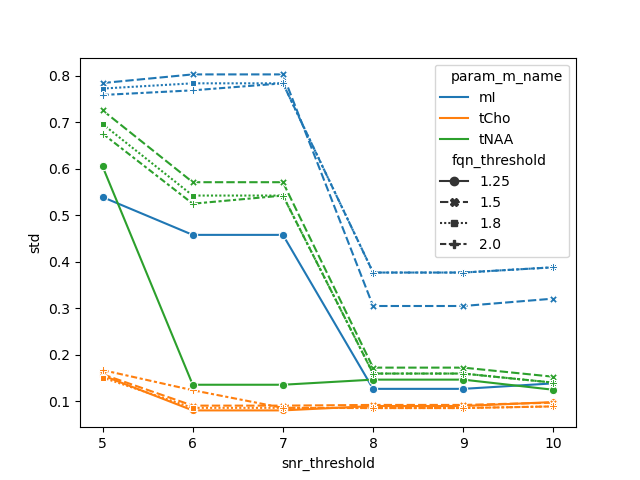

<IPython.core.display.Javascript object>


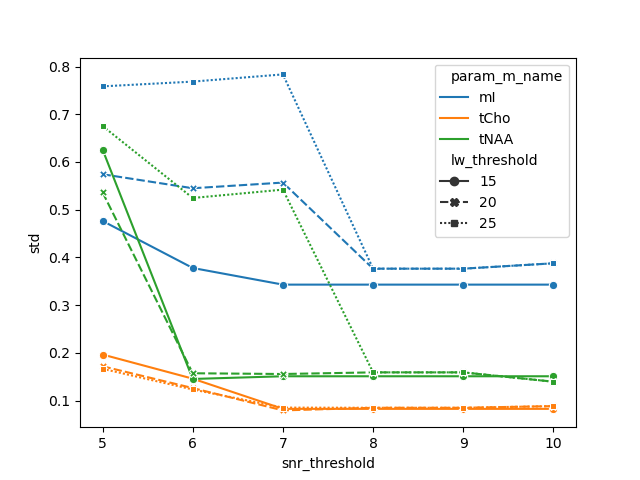

<IPython.core.display.Javascript object>


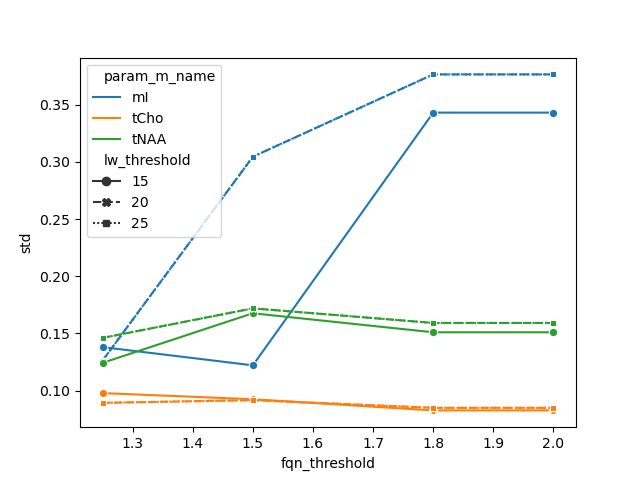

In [68]:
this_df_res_concat = pd.concat(this_df_reslist).reset_index()
this_df_res_concat = this_df_res_concat.loc[(this_df_res_concat["lw_threshold"] == this_df_res_concat["lw_threshold"].max())]

plt.figure()
g = sns.lineplot(x="snr_threshold", y="std",
                hue="param_m_name",
                style="fqn_threshold", markers=True,
                data=this_df_res_concat)

this_df_res_concat = pd.concat(this_df_reslist).reset_index()
this_df_res_concat = this_df_res_concat.loc[(this_df_res_concat["fqn_threshold"] == this_df_res_concat["fqn_threshold"].max())]

plt.figure()
g = sns.lineplot(x="snr_threshold", y="std",
                hue="param_m_name",
                style="lw_threshold", markers=True,
                data=this_df_res_concat)

this_df_res_concat = pd.concat(this_df_reslist).reset_index()
this_df_res_concat = this_df_res_concat.loc[(this_df_res_concat["snr_threshold"] == 8)]

plt.figure()
g = sns.lineplot(x="fqn_threshold", y="std",
                hue="param_m_name",
                style="lw_threshold", markers=True,
                data=this_df_res_concat)


## Final stats: Mean, Median, STDs, CRBs, pastis vs. LCModel, sc vs. sc_nodatarej

In [69]:
threshold_snr_final = 6
threshold_lw_final = 20
threshold_fqn_final = 1.8

ref_reco_template_name_sc = "sc"
ref_fit_tool_name = "pastis"
ref_fit_ws_metabolites_len = 15
ref_fit_ws_sequence_str = "none"

df_sc_all_reco = filter_by_SNR_LW_FQN(df_sc_all_reco, 
                                        threshold_snr_final,
                                        threshold_lw_final,
                                        threshold_fqn_final,
                                        ref_reco_template_name_sc, 
                                        ref_fit_tool_name, 
                                        ref_fit_ws_metabolites_len, 
                                        ref_fit_ws_sequence_str)

df = df_sc_all_reco.loc[(df_sc_all_reco["included"]) & 
                        df_sc_all_reco.index.get_level_values("reco_template_name").isin(["sc", "sc_nodatarej"]) &
                        (df_sc_all_reco["fit_ws_sequence_str"] == "none") &
                        df_sc_all_reco["fit_ws_metabolites_len"].isin([1,15]) & 
                        (df_sc_all_reco["pass_after_filter"] == 1)]


found 2 orphan P2 patients. Fixing them...
['336', '349']
n (P1) = 11 / 13 (84.62% included)
n (P2) = 4 / 7


In [70]:
# watch SDs
this_df = df.loc[(df["param_p_type"] == "fit_ws_params_fit_t2cor_ratio_cm") &
                 (df["param_val_err"] == "val") &  
                 (df["param_m_name"].isin(["tCho", "tNAA", "mI", "Tau", "Gln", "Glu", "Gsh", "Glx"]))]

this_df = this_df[this_df["param_val"].notna()].reset_index()

this_df_grp_disp = this_df.groupby(["param_m_name", "strategy"])["param_val"].std()

this_df.groupby(["param_m_name", "strategy"])["param_val"].agg(["mean", "median", "std", "size"])

mean    median       std  size
param_m_name strategy                                                       
Gln          sc_nodatarej|lcmodel|1|none  0.783892  0.575095  0.634242     9
             sc_nodatarej|pastis|15|none  0.646384  0.065625  1.321906     9
             sc|lcmodel|1|none            0.665053  0.483220  0.533298    10
             sc|pastis|15|none            0.874909  0.438366  1.088619    11
Glu          sc_nodatarej|lcmodel|1|none  0.586576  0.558143  0.412573     7
             sc_nodatarej|pastis|15|none  0.474323  0.386672  0.549203     9
             sc|lcmodel|1|none            0.561784  0.342705  0.569418     8
             sc|pastis|15|none            0.436011  0.191300  0.518985     9
Glx          sc_nodatarej|lcmodel|1|none  1.014642  0.657462  0.882691    11
             sc_nodatarej|pastis|15|none  1.008636  0.533514  1.165736    10
             sc|lcmodel|1|none            1.013164  0.666926  0.926509    11
             sc|pastis|15|none            1.231645  0.669996  1.158781    11
Gsh          sc_nodatarej|lcmodel|1|none  0.354328  0.337015  0.147179     8
             sc_nodatarej|pastis|15|none  0.448150  0.351583  0.301879    10
             sc|lcmodel|1|none            0.299794  0.288217  0.236796    10
             sc|pastis|15|none            0.468757  0.406208  0.243633     8
Tau          sc_nodatarej|lcmodel|1|none  1.224750  1.224750       NaN     1
             sc|lcmodel|1|none            0.762498  0.533605  0.793822     3
mI           sc_nodatarej|lcmodel|1|none  0.954554  1.073448  0.465538    10
             sc_nodatarej|pastis|15|none  1.299030  1.323392  0.431879    11
             sc|lcmodel|1|none            0.974274  1.083198  0.486718    10
             sc|pastis|15|none            1.283550  1.262763  0.517505    11
tCho         sc_nodatarej|lcmodel|1|none  0.363593  0.359220  0.177970    11
             sc_nodatarej|pastis|15|none  0.376309  0.369233  0.118029    11
             sc|lcmodel|1|none            0.331985  0.343521  0.162981    11
             sc|pastis|15|none            0.353260  0.338166  0.076475    11
tNAA         sc_nodatarej|lcmodel|1|none  1.789536  1.644206  0.619429    11
             sc_nodatarej|pastis|15|none  1.429062  1.257891  0.549237    11
             sc|lcmodel|1|none            1.640555  1.547873  0.538377    11
             sc|pastis|15|none            1.371679  1.330852  0.241851    11

<IPython.core.display.Javascript object>


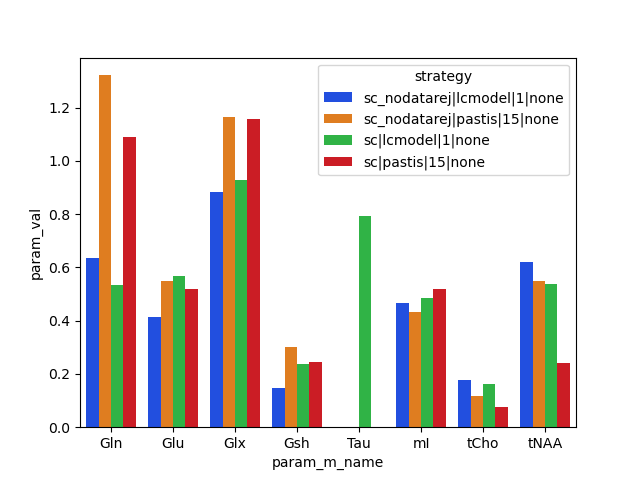

In [71]:
plt.figure()
g = sns.barplot(x="param_m_name", 
                y="param_val",
                hue="strategy",
                palette = "bright",
                data=this_df_grp_disp.reset_index())

In [72]:
# watch CRBs
this_df = df.loc[(df["param_p_type"] == "fit_ws_params_fit_t2cor_ratio_cm") &
                 (df["param_val_err"] == "err_prct") &  
                 (df["param_m_name"].isin(["tCho", "tNAA", "mI", "Tau", "Gln", "Glu", "Gsh", "Glx"]))]

this_df = this_df[this_df["param_val"].notna()].reset_index()

this_df_grp_disp = this_df.groupby(["param_m_name", "strategy"])["param_val"].mean()

this_df.groupby(["param_m_name", "strategy"])["param_val"].agg(["mean", "median", "size"])

mean      median  size
param_m_name strategy                                                    
Gln          sc_nodatarej|lcmodel|1|none      65.205524   64.327288     9
             sc_nodatarej|pastis|15|none   74520.138417  234.406149     9
             sc|lcmodel|1|none                72.924383   71.298654    10
             sc|pastis|15|none            126474.933588   67.533815    11
Glu          sc_nodatarej|lcmodel|1|none     151.764939  113.357840     7
             sc_nodatarej|pastis|15|none   22382.889006  131.634214     9
             sc|lcmodel|1|none               174.293589  119.787489     8
             sc|pastis|15|none             67149.148699  307.973167     9
Glx          sc_nodatarej|lcmodel|1|none      67.436996   60.380193    11
             sc_nodatarej|pastis|15|none     482.308085   64.638252    10
             sc|lcmodel|1|none               113.549620   67.550914    11
             sc|pastis|15|none               258.829850   47.873911    11
Gsh          sc_nodatarej|lcmodel|1|none      37.303530   36.491612     8
             sc_nodatarej|pastis|15|none      73.355223   23.442951    10
             sc|lcmodel|1|none               122.569565   44.709746    10
             sc|pastis|15|none                24.031444   24.660890     8
Tau          sc_nodatarej|lcmodel|1|none      67.629636   67.629636     1
             sc|lcmodel|1|none                93.622692   63.488034     3
mI           sc_nodatarej|lcmodel|1|none      33.690651   30.737575    10
             sc_nodatarej|pastis|15|none      32.343212   20.764735    11
             sc|lcmodel|1|none                31.642304   31.760262    10
             sc|pastis|15|none                25.344723   21.527514    11
tCho         sc_nodatarej|lcmodel|1|none      26.187606   24.698178    11
             sc_nodatarej|pastis|15|none      47.154931   41.424427    11
             sc|lcmodel|1|none                22.634134   17.120751    11
             sc|pastis|15|none                40.497900   36.076559    11
tNAA         sc_nodatarej|lcmodel|1|none      21.655298   18.785990    11
             sc_nodatarej|pastis|15|none      30.092202   20.392934    11
             sc|lcmodel|1|none                22.230020   17.611079    11
             sc|pastis|15|none                22.805425   20.910118    11

<IPython.core.display.Javascript object>


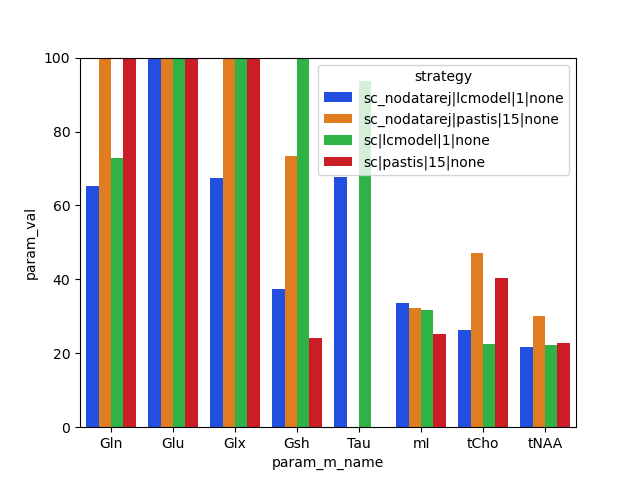

(0.0, 100.0)

In [73]:
plt.figure()
g = sns.barplot(x="param_m_name", 
                y="param_val",
                hue="strategy",
                palette = "bright",
                data=this_df_grp_disp.reset_index())

plt.ylim([0, 100])

## PASTIS vs. LCModel: t-tests  

In [74]:
from scipy.stats import ttest_ind

for m in ["tCho", "tNAA", "mI", "Tau", "Gln", "Glu", "Gsh"]:

    this_df_pastis = df.loc[(df["param_p_type"] == "fit_ws_params_fit_t2cor_ratio_cm") &
                     (df["param_val_err"] == "val") &  
                     (df["param_m_name"] == m) &  
                     (df["strategy"] == "sc|pastis|15|none")]

    this_df_pastis = this_df_pastis[this_df_pastis["param_val"].notna()].reset_index()
    
    this_df_lcmodel = df.loc[(df["param_p_type"] == "fit_ws_params_fit_t2cor_ratio_cm") &
                     (df["param_val_err"] == "val") &  
                     (df["param_m_name"] == m) &  
                     (df["strategy"] == "sc|lcmodel|1|none")]

    this_df_lcmodel = this_df_lcmodel[this_df_lcmodel["param_val"].notna()].reset_index()
    
    stats, pval = ttest_ind(this_df_pastis["param_val"], this_df_lcmodel["param_val"])

    print("PASTIS vs. LCM [%s] p = %.2f" % (m, pval))


PASTIS vs. LCM [tCho] p = 0.70
PASTIS vs. LCM [tNAA] p = 0.15
PASTIS vs. LCM [mI] p = 0.18
PASTIS vs. LCM [Tau] p = nan
PASTIS vs. LCM [Gln] p = 0.59
PASTIS vs. LCM [Glu] p = 0.64
PASTIS vs. LCM [Gsh] p = 0.16


# P1 vs. P2 quantification results

In [75]:
threshold_snr_final = 6
threshold_lw_final = 20
threshold_fqn_final = 1.8

ref_reco_template_name_sc = "sc"
ref_fit_tool_name = "pastis"
ref_fit_ws_metabolites_len = 15
ref_fit_ws_sequence_str = "none"

df_sc_all_reco = filter_by_SNR_LW_FQN(df_sc_all_reco, 
                                        threshold_snr_final,
                                        threshold_lw_final,
                                        threshold_fqn_final,
                                        ref_reco_template_name_sc, 
                                        ref_fit_tool_name, 
                                        ref_fit_ws_metabolites_len, 
                                        ref_fit_ws_sequence_str)

df = df_sc_all_reco.loc[(df_sc_all_reco["included"]) & 
                        df_sc_all_reco.index.get_level_values("reco_template_name").isin(["sc", "sc_nodatarej"]) &
                        (df_sc_all_reco["fit_ws_sequence_str"] == "none") &
                        df_sc_all_reco["fit_ws_metabolites_len"].isin([1,15])]

# watch ratios
this_df = df.loc[(df["param_p_type"] == "fit_ws_params_fit_t2cor_ratio_cm") &
                 (df["param_val_err"] == "val") &  
                 (df["param_m_name"].isin(["tCho", "tNAA", "mI", "Tau", "Gln", "Glu", "Gsh", "Glx"]))]

# keep only patients that has P1 and P2
# find pass 1 patients
this_df_p1 = this_df.loc[(this_df["pass_after_filter"] == 1)]
# remember them
patient_id_p1_list = this_df_p1["patient_id"].unique().tolist()
# find pass 2 patients which are in previously found pass 1 list
patient_id_p1p2_list = this_df.loc[ (this_df["pass_after_filter"] == 2) &
                            this_df["patient_id"].isin(patient_id_p1_list) ]["patient_id"].unique().tolist()
# select those p1p2 patients
this_df_p1p2 = this_df.loc[ this_df["patient_id"].isin(patient_id_p1p2_list) ]

this_df_p1p2 = this_df_p1p2[this_df_p1p2["param_val"].notna()]
this_df_p1p2[["patient_id", "pass_after_filter", 'param_val']]
this_df_p1p2_grp_disp = this_df_p1p2.groupby(["param_m_name", "strategy", "patient_id"])["param_val"].std() / this_df_p1p2.groupby(["param_m_name", "strategy", "patient_id"])["param_val"].mean() * 100.0
this_df_p1p2_grp_disp.groupby(["param_m_name", "strategy"]).agg(["mean", "median", "size"])

found 2 orphan P2 patients. Fixing them...
['336', '349']
n (P1) = 11 / 13 (84.62% included)
n (P2) = 4 / 7


mean      median  size
param_m_name strategy                                                 
Gln          sc_nodatarej|lcmodel|1|none   30.208749   33.629685     4
             sc_nodatarej|pastis|15|none   98.761823   98.761823     3
             sc|lcmodel|1|none             40.298948   47.736976     4
             sc|pastis|15|none             91.126201   91.126201     4
Glu          sc_nodatarej|lcmodel|1|none  120.905378  120.905378     3
             sc_nodatarej|pastis|15|none   73.170978   73.170978     2
             sc|lcmodel|1|none             74.344015   74.344015     3
             sc|pastis|15|none             26.387621   26.387621     4
Glx          sc_nodatarej|lcmodel|1|none   57.916116   68.862186     4
             sc_nodatarej|pastis|15|none   77.853646   75.345055     3
             sc|lcmodel|1|none             33.258513   29.324090     4
             sc|pastis|15|none             58.070711   58.279346     4
Gsh          sc_nodatarej|lcmodel|1|none   55.501289   54.371253     4
             sc_nodatarej|pastis|15|none   43.579957   40.640706     4
             sc|lcmodel|1|none             55.065479   47.542901     4
             sc|pastis|15|none             29.013704   28.446051     4
Tau          sc_nodatarej|lcmodel|1|none   64.125331   64.125331     2
             sc|lcmodel|1|none             79.570993   79.570993     2
mI           sc_nodatarej|lcmodel|1|none   35.303722   39.094703     4
             sc_nodatarej|pastis|15|none   24.258778   17.618086     4
             sc|lcmodel|1|none             37.672945   41.618584     4
             sc|pastis|15|none             26.113891   23.142793     4
tCho         sc_nodatarej|lcmodel|1|none   23.020976   20.390623     4
             sc_nodatarej|pastis|15|none   19.956023   19.270258     4
             sc|lcmodel|1|none             24.794555   21.621784     4
             sc|pastis|15|none             17.063496   15.130133     4
tNAA         sc_nodatarej|lcmodel|1|none   11.268264   10.801842     4
             sc_nodatarej|pastis|15|none   14.425323   11.202412     4
             sc|lcmodel|1|none             15.510794   13.426271     4
             sc|pastis|15|none             14.142009   16.396489     4

<IPython.core.display.Javascript object>


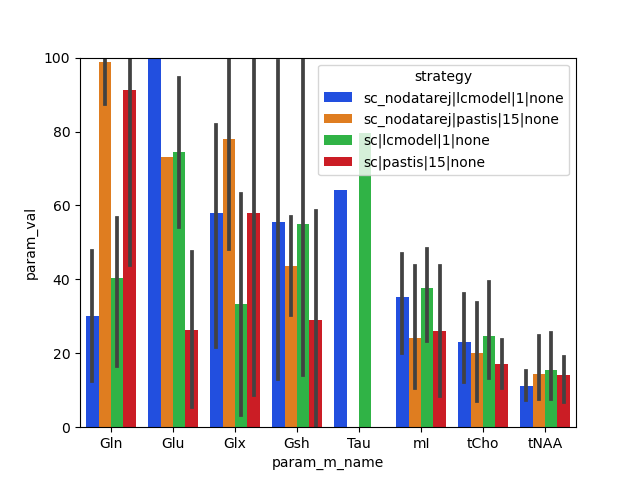

(0.0, 100.0)

In [76]:
plt.figure()
g = sns.barplot(x="param_m_name", 
                y="param_val",
                hue="strategy",
                palette = "bright",
                data=this_df_p1p2_grp_disp.reset_index())

plt.ylim([0, 100])